This notebook:
- isolating nanorod events
- clustering on nanorods and nanospheres

In [1]:
import importlib
import all_funcs
importlib.reload(all_funcs)
from all_funcs import *

In [28]:
base_path_NR = "/Users/joehart/Desktop/chemistry/Year 4/MSci project/MATLAB/Nanorods_dataset/"
file_template_NR = "p84_647_NRsPEG5kCOOH_2PEG35k_50KCl_1TE_50PEG35k_{}.abf"
paths_NR = [base_path_NR + file_template_NR.format(str(i).zfill(4)) for i in range(3, 5)]

base_path_NS = "/Users/joehart/Desktop/chemistry/Year 4/MSci project/MATLAB/Nanorods_dataset/"
file_template_NS = "p84_649_Seeds9PEG5kCOOH_2PEG35k_50KCl_1TE_50PEG35k_{}.abf"
paths_NS = [base_path_NS + file_template_NS.format(str(i).zfill(4)) for i in range(3, 5)]

base_path_mix = "/Users/joehart/Desktop/chemistry/Year 4/MSci project/MATLAB/Nanorods_dataset/"
file_template_mix = "p84_647_mix100NRs50Seeds9PEG5kCOOH_2PEG35k_50KCl_1TE_50PEG35k_{}.abf"
paths_mix = [base_path_mix + file_template_mix.format(str(i).zfill(4)) for i in range(3, 5)]

#### event_isolation_NRNS + testing

In [206]:
def pad_single_event(event_time, event_data, mean_noise, custom_length):
    # Determine the length to pad to
    max_length = custom_length
    
    # Pad the event data
    data_padding = ((max_length - len(event_data) + 1) // 2, (max_length - len(event_data)) // 2)
    data_padded = np.pad(event_data, data_padding, 'constant', constant_values=mean_noise)

    # Pad the event time
    if len(event_time) < max_length:
        start_padding_size = (max_length - len(event_time) + 1) // 2
        end_padding_size = (max_length - len(event_time)) // 2

        increment = (event_time[-1] - event_time[-2]) if len(event_time) > 1 else 2e-6
        start_pad_values = event_time[0] - np.arange(start_padding_size, 0, -1) * increment
        end_pad_values = event_time[-1] + np.arange(1, end_padding_size + 1) * increment

        time_padded = np.concatenate([start_pad_values, event_time, end_pad_values])
    else:
        time_padded = event_time

    return time_padded, data_padded


In [52]:
import numpy as np

def pad_single_event_smooth(event_time, event_data, mean_noise, sd_noise, custom_length=None, transition_length=200, noise_frequency=5):
    if custom_length is None:
        custom_length = len(event_data)

    # Ensure that transition_length is not greater than the custom length
    transition_length = min(transition_length, custom_length // 2)

    # Calculate the padding size on each side of the event
    padding_length = custom_length - len(event_data)
    padding_each_side = padding_length // 2

    # Function to create a transition with a predefined noise level
    def transition_with_noise(start_value, end_value, length, noise_level, noise_frequency = noise_frequency):
        transition = np.linspace(start_value, end_value, length)
        # Apply noise at specified frequency, otherwise transition is very fuzzy
        noise_indices = np.arange(0, length, noise_frequency)
        noise = np.zeros(length)
        noise[noise_indices] = np.random.normal(0, noise_level, len(noise_indices))
        return transition + noise

    # Create transition padding
    start_transition = transition_with_noise(mean_noise, event_data[0], transition_length, sd_noise)
    end_transition = transition_with_noise(event_data[-1], mean_noise, transition_length, sd_noise)

    # Create full padding with transition
    start_padding = np.concatenate([np.full(padding_each_side - transition_length, mean_noise), start_transition])
    end_padding = np.concatenate([end_transition, np.full(padding_each_side + padding_length % 2 - transition_length, mean_noise)])

    data_padded = np.concatenate([start_padding, event_data, end_padding])

    # Pad the event time
    increment = (event_time[-1] - event_time[-2]) if len(event_time) > 1 else 2e-6
    start_pad_time = np.linspace(event_time[0] - padding_each_side * increment, event_time[0] - increment, padding_each_side)
    end_pad_time = np.linspace(event_time[-1] + increment, event_time[-1] + (padding_each_side + padding_length % 2) * increment, padding_each_side + padding_length % 2)

    time_padded = np.concatenate([start_pad_time, event_time, end_pad_time])

    return time_padded, data_padded


In [168]:
def event_isolation_NRNS(x_base, y_base, peaks_above, NR = False, NP = False):
    
    """ made for data with a small resistive part you still want to capture
    
    Returns:
        event_time_NP, event_data_NP, event_data_smoothed
    """
    
    
    event_data_NP = []
    event_time_NP = []

    
    if NR:
        for peak in peaks_above:
            start = peak - 1000
            end = peak + 1000
        
            event = y_base[int(start):int(end)]
            time = x_base[int(start):int(end)]
            event_data_NP.append(event)
            event_time_NP.append(time)
    
    else:
        mean_noise = np.mean(y_base)
        sd_noise = np.std(y_base)
        
        for peak in peaks_above:
            start = peak - 400 if NP else peak - 500
            end = peak + 400 if NP else peak + 500 
            
            event = y_base[int(start):int(end)]
            time = x_base[int(start):int(end)]
            
            # to avoid picking up 2 events at once and make sure same length as NR events
            if NP:
                time, event = pad_single_event_smooth(time, event, mean_noise, sd_noise/7, custom_length = 1000) 
            else:
                time, event = pad_single_event_smooth(time, event, mean_noise, sd_noise/7, custom_length = 2000) 
            

            event_data_NP.append(event)
            event_time_NP.append(time)
    

    return event_time_NP, event_data_NP

: 

In [100]:
def event_isolation_new(x_base, y_base, peaks_above, properties_above, peaks_below = None, properties_below = None):
    
    """ made for nanorods data
    
    Returns:
        event_time_NP, event_data_NP, event_data_smoothed
    """
    
    event_data_NP = []
    event_time_NP = []
    count = 0
    processed_peaks = set()
    
    mean_noise = np.mean(y_base)

    
    if peaks_below is None:
        for peak, width in zip(peaks_above, properties_above['widths']):
            # if the next peak along is in peaks_below, then contatenate the two peaks, then skip the peak in peaks_below
            
            start_candidates = np.where((y_base[:peak] <= 0) | (np.arange(peak) < peak - 1000))[0]
            start = start_candidates[-1] if len(start_candidates) > 0 else max(0, peak - 1000)

            end_candidates = np.where((y_base[peak:] <= 0) | (np.arange(peak, len(y_base)) > peak + 1000))[0]
            end = end_candidates[0] + peak if len(end_candidates) > 0 else min(len(y_base), peak + 1000)

            event = y_base[start:end]
            time = x_base[start:end]
            event_data_NP.append((peak, event))
            event_time_NP.append((peak, time))

    else:
        
        for trough in peaks_below:
            peak = None # added to correct error
            previous_peak = find_previous_peak(trough, peaks_above)
            next_peak = find_next_peak(trough, peaks_above)
            
            # work out if trough is closer to previous or next peak
            # need check for the case where there is no previous or next peak
            
            if previous_peak is not None and next_peak is not None:
                if abs(trough - previous_peak) < abs(trough - next_peak): # if previous peak is closer to trough
                    peak = previous_peak
                    peak_width_start = properties_above['widths'][np.where(peaks_above == previous_peak)[0][0]]
                    peak_width_end = properties_below['left_ips'][np.where(peaks_below == trough)[0][0]]
                else: # main case: if next peak is closer to trough
                    peak = next_peak
                    peak_width_start_candidates = np.where((y_base[:peak] >= 0) | (np.arange(peak) < peak - 1000))[0]
                    peak_width_start = peak_width_start_candidates[-1] if len(peak_width_start_candidates) > 0 else max(0, peak - 1000)

                    peak_width_end_candidates = np.where((y_base[peak:] <= 0) | (np.arange(peak, len(y_base)) > peak + 1000))[0]
                    peak_width_end = peak_width_end_candidates[0] + peak if len(peak_width_end_candidates) > 0 else min(len(y_base), peak + 1000)
                    
                    # peak_width_start = properties_below['right_ips'][np.where(peaks_below == trough)[0][0]]
                    # peak_width_end = properties_above['widths'][np.where(peaks_above == next_peak)[0][0]]
            elif previous_peak is not None: # if there is no next peak
                peak = previous_peak
                peak_width_start = properties_above['widths'][np.where(peaks_above == previous_peak)[0][0]]
                peak_width_end = properties_below['left_ips'][np.where(peaks_below == trough)[0][0]]
            elif next_peak is not None: # if there is no previous peak
                peak = next_peak
                peak_width_start = properties_below['right_ips'][np.where(peaks_below == trough)[0][0]]
                peak_width_end = properties_above['widths'][np.where(peaks_above == next_peak)[0][0]]
                

            if peak is not None and peak not in processed_peaks: # was: if peak not in processed_peaks:
                if trough < peak:
                    # start = peak_width_start  -300 # here peak_width_start is the left_ips of the peak below -> ips isnt a width, its a position so we dont need to add/takw away half from the trough position 
                    # end = min(len(y_base), peak + peak_width_end // 2) +200 # End at the peak
                    start = peak_width_start
                    end = min(len(y_base), peak_width_end)
                    
                else:
                    start = max(0, peak - peak_width_start // 2) -200 # Start at the peak
                    end = + peak_width_end +300 # End at the trough

                event = y_base[int(start):int(end)]
                time = x_base[int(start):int(end)]
                
                if (end-start) <= 1000:
                    event_data_NP.append((peak, event))
                    event_time_NP.append((peak, time))
                    count += 1
                
                else: #just take a 1000 point window around the peak
                    start = peak - 500
                    end = peak + 500
                    event = y_base[int(start):int(end)]
                    time = x_base[int(start):int(end)]
                    event_data_NP.append((peak, event))
                    event_time_NP.append((peak, time))
                    
                processed_peaks.add(peak)
                


        # Isolate peaks that don't have a corresponding trough
        for peak, width in zip(peaks_above, properties_above['widths']):
            if peak not in processed_peaks:
                start_candidates = np.where((y_base[:peak] <= 0) | (np.arange(peak) < peak - 1000))[0]
                start = start_candidates[-1] if len(start_candidates) > 0 else max(0, peak - 1000)

                end_candidates = np.where((y_base[peak:] <= 0) | (np.arange(peak, len(y_base)) > peak + 1000))[0]
                end = end_candidates[0] + peak if len(end_candidates) > 0 else min(len(y_base), peak + 1000)

                event = y_base[start:end]
                time = x_base[start:end]
                event_data_NP.append((peak, event))
                event_time_NP.append((peak, time))
            
        # sort the events by the index to ensure original order
        event_data_NP.sort(key=lambda x: x[0]) # sort
        event_data_NP = [np.array(data) for _, data in sorted(event_data_NP, key=lambda x: x[0])] # Remove index from event_data_NP and convert to list of arrays
        event_time_NP.sort(key=lambda x: x[0])
        event_time_NP = [np.array(time) for _, time in sorted(event_time_NP, key=lambda x: x[0])]
    
    # smoothed data
    event_data_smoothed=[]
    for i in range(len(event_data_NP)): 
        vetor=event_data_NP[i]
        z=signal.savgol_filter(vetor, window_length=71, polyorder=2, mode="nearest")
        event_data_smoothed.append(z)



    return event_time_NP, event_data_NP, event_data_smoothed

In [3]:
def load_to_event_data_nofeatures_even(path, resistive = False, plot = False):
    # even event isolation
    x, y, sma, y_corrected, y_base, x_base = importABF_movingavg(path, resistive) 
    
    threshold, mean_noise, sd_noise = define_threshold(y_base, 12)
    
    sd_threshold, sd_threshold_lower, peaks_above, properties_above, peaks_below, properties_below = find_peaks_troughs(mean_noise, sd_noise, y_base, x_base, resistive, plot = plot)
    
    event_time, event_data, smo = event_isolation_even(x_base, y_base, peaks_above, properties_above)     

    return event_time, event_data, smo, sd_threshold, sd_threshold_lower, mean_noise

In [27]:
def load_to_event_data_nofeatures_NRNS(path, resistive = False, small_resistive = False, NR = False, plot = False):
    """ allows analysis of nanorods and nanospheres data as well

    Returns:
        event_time, event_data, smo, sd_threshold, sd_threshold_lower, mean_noise
    """
    x, y, sma, y_corrected, y_base, x_base = importABF_movingavg(path, resistive) 
    
    threshold, mean_noise, sd_noise = define_threshold(y_base, 12) # only uses mean and sd, next func calcs uneven thresholds
    
    sd_threshold, sd_threshold_lower, peaks_above, properties_above, peaks_below, properties_below = find_peaks_troughs(mean_noise, sd_noise, y_base, x_base, resistive, plot = plot)
    
    if resistive and small_resistive:
        event_time, event_data = event_isolation_NRNS(x_base, y_base, peaks_above, NR = NR)
        smo = None
    elif resistive:
        event_time, event_data, smo = event_isolation(x_base, y_base, peaks_above, properties_above, peaks_below, properties_below)
    else:
        event_time, event_data, smo = event_isolation(x_base, y_base, peaks_above, properties_above)
    
    return event_time, event_data, smo, sd_threshold, sd_threshold_lower, mean_noise

NR test

In [163]:
%matplotlib inline

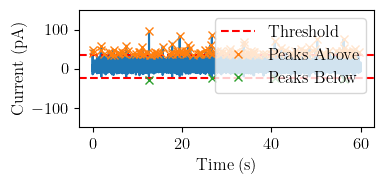

In [29]:
event_time_NRtest, event_data_NRtest, smo_NRtest, sd_threshold_NRtest, sd_threshold_lower_NRtest, mean_noise_NRtest = load_to_event_data_nofeatures_NRNS(paths_NR[0], resistive = True, small_resistive = True, NR = True, plot = True)

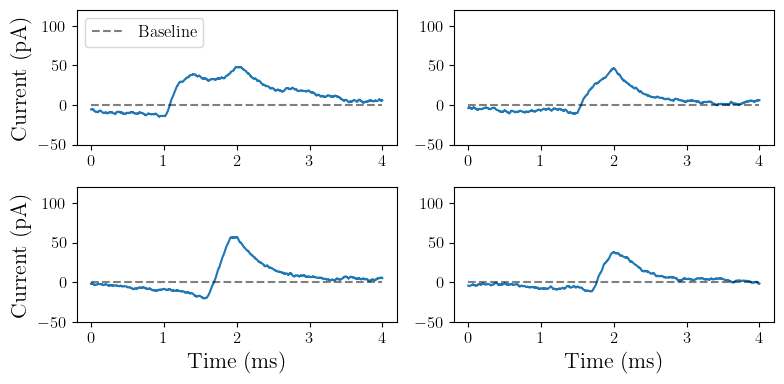

In [45]:
fig, axes = plt.subplots(2, 2, figsize=(8, 4))
#fig.suptitle('Nanorods')
time = np.linspace(0, 2000*2e-3, 2000)
axes_flat = axes.flatten()  # Flatten the array for easier iteration

for idx, i in enumerate(range(1,5)):
    ax = axes_flat[idx]
    ax.plot(time, event_data_NRtest[i])
    ax.hlines(0, time[0], time[-1], color='k', linestyle='--', alpha=0.5, label="Baseline")

    
    ax.set_ylabel('Current (pA)', fontsize = 16) if idx in [0,2] else None
    ax.set_xlabel('Time (ms)', fontsize = 16) if idx in [2,3] else None
    ax.legend(loc = "upper left") if idx == 0 else None 

    ax.set_ylim(-50, 120)
    

plt.tight_layout()
#plt.savefig("/Users/joehart/Desktop/chemistry/Year 4/MSci project/Python_nanopores/MSci_python_images/NR_event_isolation.png", dpi=300)
plt.show()

NS test

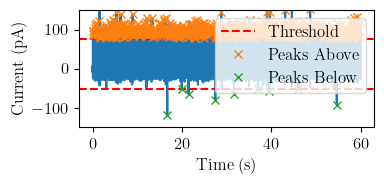

In [31]:
event_time_NStest, event_data_NStest, smo_NStest, sd_threshold_NStest, sd_threshold_lower_NStest, mean_noise_NStest = load_to_event_data_nofeatures_NRNS(paths_NS[0], resistive = True, small_resistive = True, NR = False, plot = True)

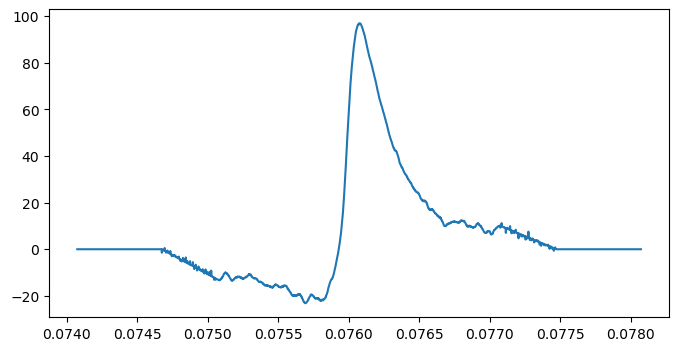

In [59]:
plt.figure(figsize=(8, 4))
plt.plot(event_time_NStest[0], event_data_NStest[0])

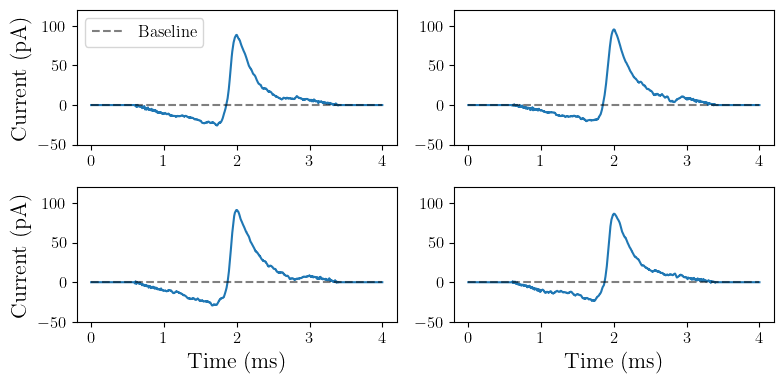

In [46]:
fig, axes = plt.subplots(2, 2, figsize=(8, 4))
#fig.suptitle('Nanorods')

axes_flat = axes.flatten()  # Flatten the array for easier iteration

for idx, i in enumerate(range(1,5)):
    ax = axes_flat[idx]
    ax.plot(time, event_data_NStest[i])
    ax.hlines(0, time[0], time[-1], color='k', linestyle='--', alpha=0.5, label="Baseline")
    
    ax.set_ylabel('Current (pA)', fontsize = 16) if idx in [0,2] else None
    ax.set_xlabel('Time (ms)', fontsize = 16) if idx in [2,3] else None
    ax.legend(loc = "upper left") if idx == 0 else None 

    ax.set_ylim(-50, 120)

plt.tight_layout()
#plt.savefig("/Users/joehart/Desktop/chemistry/Year 4/MSci project/Python_nanopores/MSci_python_images/NS_event_isolation.png", dpi=300)
plt.show()

/var/folders/br/67qx_45113s31sykxddgpjyw0000gn/T/ipykernel_84233/2917895482.py:16: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


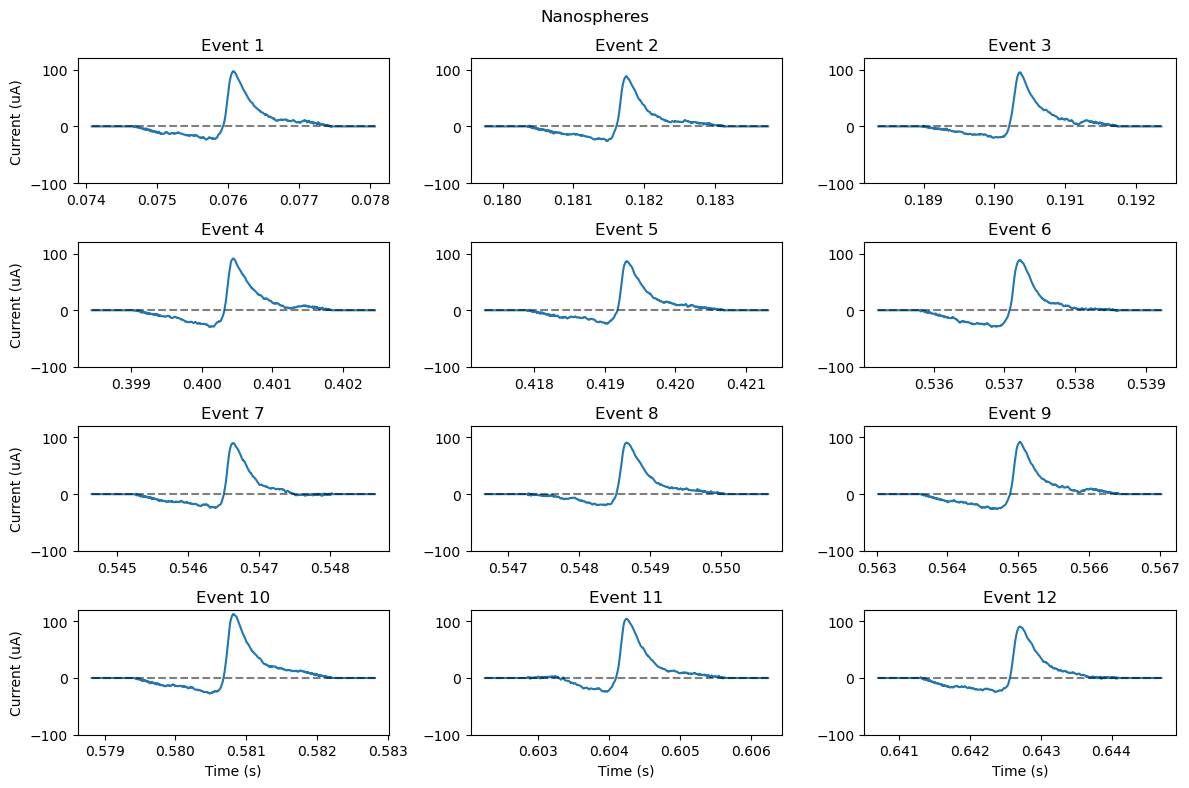

In [69]:
fig, axes = plt.subplots(4, 3, figsize=(12, 8))
fig.suptitle('Nanospheres')

for i in range(12):
    row = i // 3
    col = i % 3
    ax = axes[row, col]
    ax.plot(event_time_NStest[i], event_data_NStest[i])
    ax.hlines(0, event_time_NStest[i][0], event_time_NStest[i][-1], color = 'k', linestyle = '--', alpha = 0.5)
    ax.set_title(f'Event {i+1}')
    if i in [0, 3, 6, 9]:
        ax.set_ylabel('Current (uA)')
    if i in [9, 10, 11]:
        ax.set_xlabel('Time (s)')
    ax.set_ylim(-100, 120)
    plt.tight_layout()
    
#plt.savefig("MSci_python_images/NS_events.png", dpi=300)
plt.show()

#### Loading data

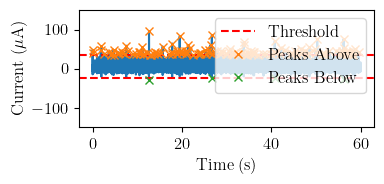

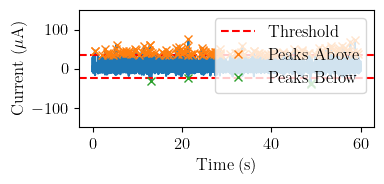

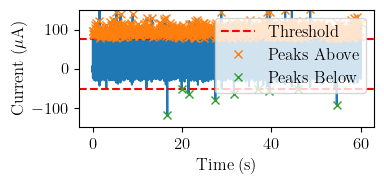

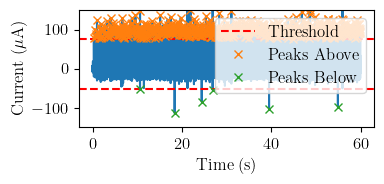

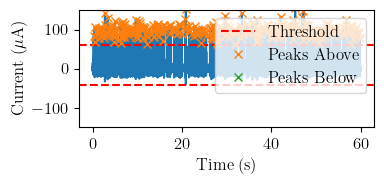

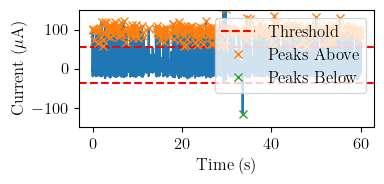

event_time  \
run_1  [[0.22688999999999998, 0.22689199999999998, 0....   
run_2  [[0.02838, 0.028381999999999998, 0.028384, 0.0...   

                                              event_data   smo  sd_threshold  \
run_1  [[-5.500474414058317, -5.378672656245726, -5.5...  None     61.260980   
run_2  [[-8.826536859126918, -8.827244866939395, -8.7...  None     55.931503   

       sd_threshold_lower  mean_noise  
run_1          -40.834404    0.003750  
run_2          -37.282557    0.003067

In [3]:
data_NR_df = pd.DataFrame(columns = ["event_time", "event_data", "smo", "sd_threshold", "sd_threshold_lower", "mean_noise"])
data_NS_df = pd.DataFrame(columns = ["event_time", "event_data", "smo", "sd_threshold", "sd_threshold_lower", "mean_noise"])
data_mix_df = pd.DataFrame(columns = ["event_time", "event_data", "smo", "sd_threshold", "sd_threshold_lower", "mean_noise"])


for i in range(len(paths_NR)):
    data = load_to_event_data_nofeatures_NRNS(paths_NR[i], resistive = True, small_resistive = True, NR = True, plot = True)
    data_NR_df.loc[f"run_{i+1}"] = data
    
data_NR_df
    
for i in range(len(paths_NS)):  
    data = load_to_event_data_nofeatures_NRNS(paths_NS[i], resistive = True, small_resistive = True, NR = False, plot = True)
    data_NS_df.loc[f"run_{i+1}"] = data

data_NS_df

for i in range(len(paths_mix)):  
    data = load_to_event_data_nofeatures_NRNS(paths_mix[i], resistive = True, small_resistive = True, NR = True, plot = True)
    data_mix_df.loc[f"run_{i+1}"] = data

data_mix_df

In [106]:
data_NR_df.to_pickle("data_NR_df.pkl")
data_NS_df.to_pickle("data_NS_df.pkl")
data_mix_df.to_pickle("data_mix_df.pkl")

In [4]:
data_NR_df = unpickle("data_NR_df.pkl")
data_NS_df = unpickle("data_NS_df.pkl")
data_mix_df = unpickle("data_mix_df.pkl")


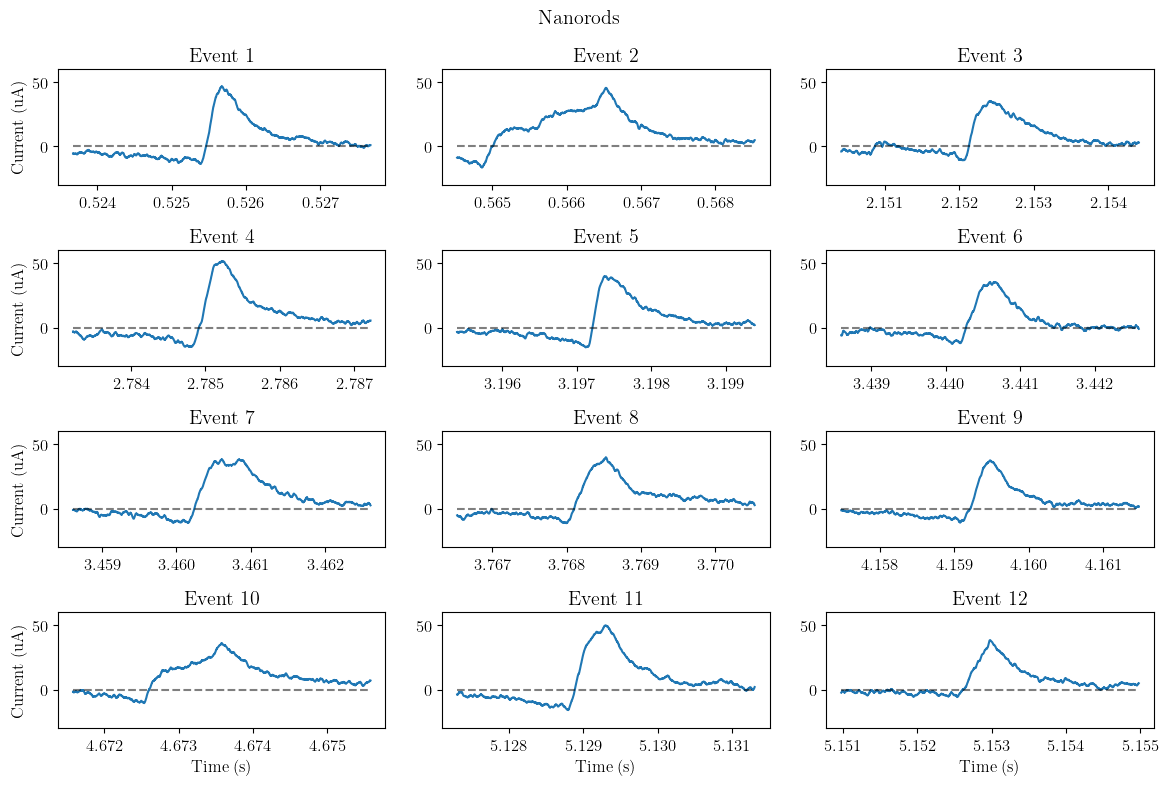

In [10]:
fig, axes = plt.subplots(4, 3, figsize=(12, 8))
fig.suptitle('Nanorods')

for i in range(12):
    row = i // 3
    col = i % 3
    ax = axes[row, col]
    ax.plot(data_NR_df["event_time"][1][i], data_NR_df["event_data"][1][i])
    ax.hlines(0, data_NR_df["event_time"][1][i][0], data_NR_df["event_time"][1][i][-1], color = "k", linestyle = "--", alpha = 0.5)
    
    if i in [0, 3, 6, 9]:
        ax.set_ylabel('Current (uA)')
    if i in [9, 10, 11]:
        ax.set_xlabel('Time (s)')
    ax.set_title(f'Event {i+1}')
    #ax.set_ylim(-100, 120)
    ax.set_ylim(-30, 60)

plt.tight_layout()
#plt.savefig("MSci_python_images/NR_events.png", dpi = 300)
plt.show()

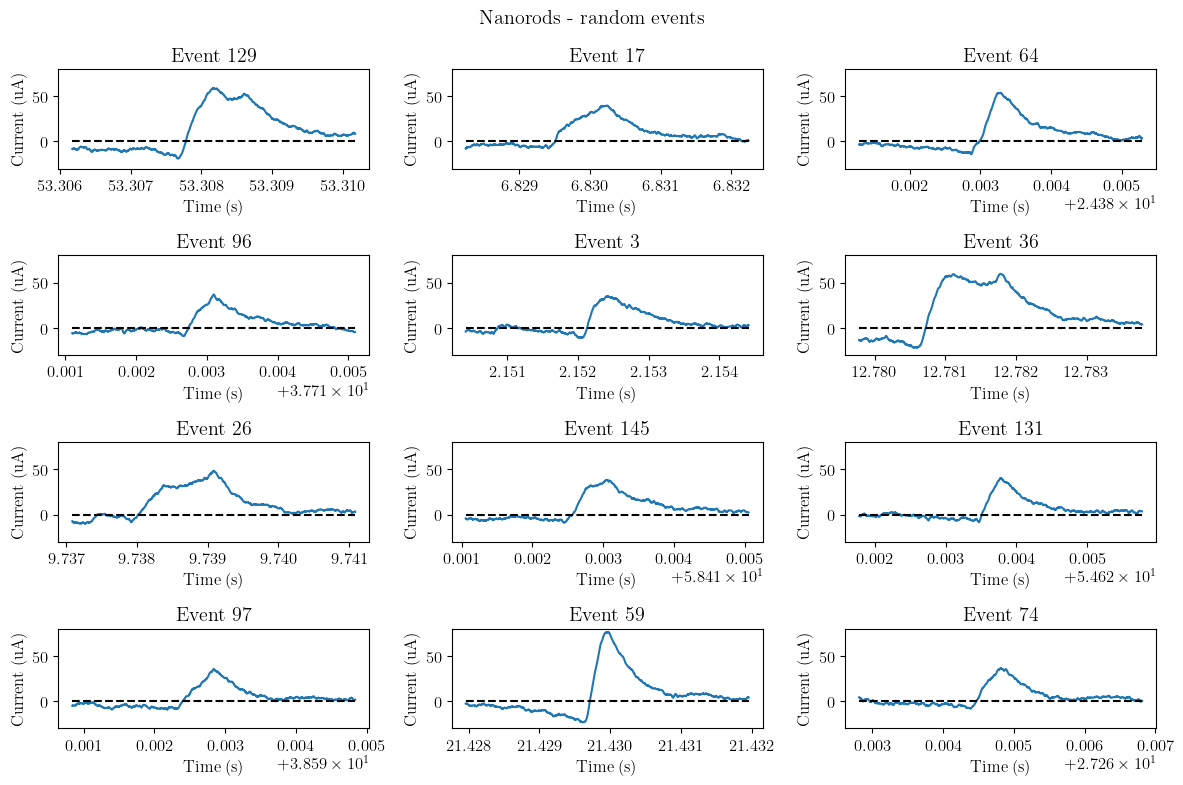

In [11]:
number_of_events = len(data_NR_df["event_time"][1])  # Get the total number of events
random_indices = np.random.choice(number_of_events, 12, replace=False)  # Generate 12 unique random indices

fig, axes = plt.subplots(4, 3, figsize=(12, 8))
fig.suptitle('Nanorods - random events')

for idx, random_index in enumerate(random_indices):
    row = idx // 3
    col = idx % 3
    ax = axes[row, col]

    # Use the random index to plot data
    ax.plot(data_NR_df["event_time"][1][random_index], data_NR_df["event_data"][1][random_index])
    ax.hlines(0, data_NR_df["event_time"][1][random_index][0], data_NR_df["event_time"][1][random_index][-1], color="k", linestyle="--")
    
    ax.set_title(f'Event {random_index + 1}')
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Current (uA)')
    ax.set_ylim(-30, 80)

plt.tight_layout()
plt.show()

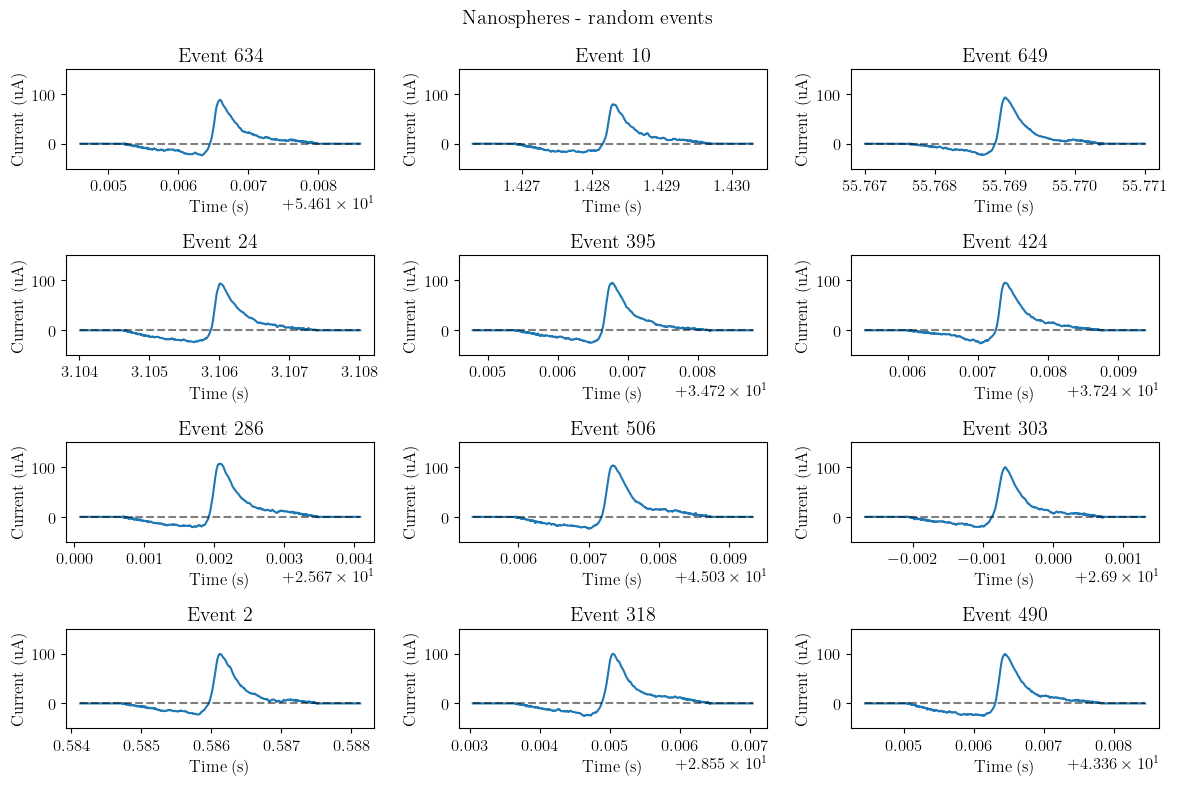

In [12]:
number_of_events = len(data_NS_df["event_time"][1])  # Get the total number of events
random_indices = np.random.choice(number_of_events, 12, replace=False)  # Generate 12 unique random indices

fig, axes = plt.subplots(4, 3, figsize=(12, 8))
fig.suptitle('Nanospheres - random events')

for idx, random_index in enumerate(random_indices):
    row = idx // 3
    col = idx % 3
    ax = axes[row, col]

    # Use the random index to plot data
    ax.plot(data_NS_df["event_time"][1][random_index], data_NS_df["event_data"][1][random_index])
    ax.hlines(0, data_NS_df["event_time"][1][random_index][0], data_NS_df["event_time"][1][random_index][-1], color="k", linestyle="--", alpha = 0.5)
    
    ax.set_title(f'Event {random_index + 1}')
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Current (uA)')
    ax.set_ylim(-50, 150)

plt.tight_layout()
plt.show()

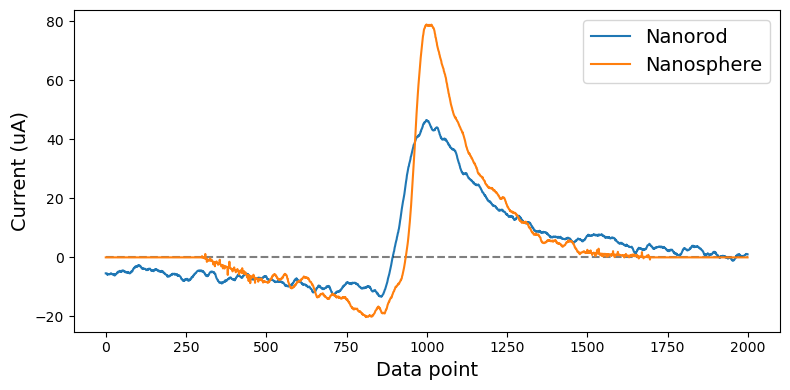

In [77]:
plt.figure(figsize=(8, 4))
plt.plot(data_NR_df["event_data"][1][0], label="Nanorod")
plt.hlines(0, 0, 2000, color="k", linestyle="--", alpha = 0.5)
plt.plot(data_NS_df["event_data"][1][0], label="Nanosphere")
plt.legend(loc = "upper right", fontsize = 14)
plt.ylabel("Current (uA)", fontsize = 14)
plt.xlabel("Data point", fontsize = 14)
plt.tight_layout()
#plt.savefig("MSci_python_images/NR_NS_comparison.png", dpi = 300)
plt.show()

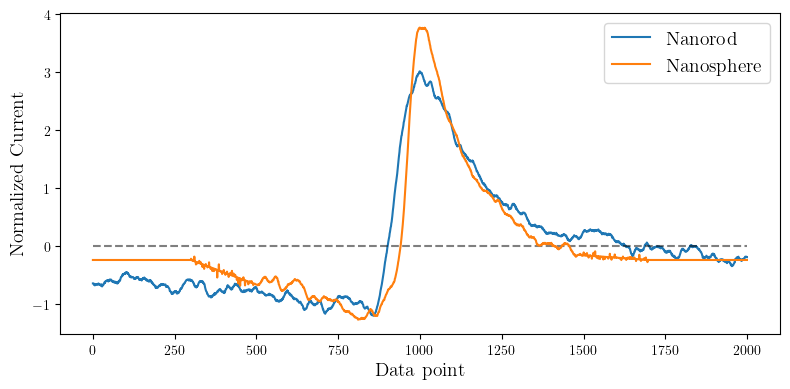

In [167]:
nanorod_data_test = np.array(data_NR_df["event_data"][1][0])
nanosphere_data_test = np.array(data_NS_df["event_data"][1][0])

# Normalizing the data (Z-score normalization)
nanorod_data_normalized = (nanorod_data_test - np.mean(nanorod_data_test)) / np.std(nanorod_data_test)
nanosphere_data_normalized = (nanosphere_data_test - np.mean(nanosphere_data_test)) / np.std(nanosphere_data_test)

plt.figure(figsize=(8, 4))
plt.plot(nanorod_data_normalized, label="Nanorod")
plt.hlines(0, 0, len(nanorod_data_normalized), color="k", linestyle="--", alpha=0.5)
plt.plot(nanosphere_data_normalized, label="Nanosphere")
plt.legend(loc="upper right", fontsize=14)
plt.ylabel("Normalized Current", fontsize=14)
plt.xlabel("Data point", fontsize=14)
plt.tight_layout()
# Uncomment the following line to save the figure
# plt.savefig("MSci_python_images/NR_NS_comparison.png", dpi=300)
plt.show()

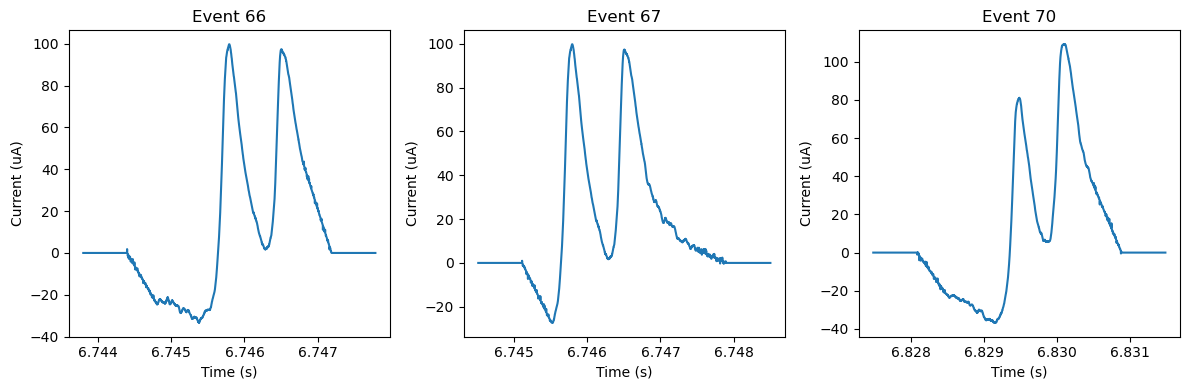

In [87]:
fig, axs = plt.subplots(1, 3, figsize=(12, 4))  # Adjust the size as needed

# Flatten the axs array for easy iteration
axs = axs.flatten()

for i, ax in zip([66,67,70], axs):
    ax.plot(data_NS_df["event_time"][1][i], data_NS_df["event_data"][1][i])
    ax.set_title(f"Event {i}")
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("Current (uA)")

# If there's an extra subplot, turn it off
if len(axs) > (72 - 67 + 1):
    axs[-1].axis('off')

plt.tight_layout()
#plt.savefig("MSci_python_images/NS_double_events.png", dpi=300)
plt.show()

In [21]:
event_test = data_NS_df["event_data"][1][0]
time_test = data_NS_df["event_time"][1][0]

### Threshold testing (+ peak tracing checking)

In [133]:
DWT_rec_test, event_time_padded_test, DWT_rec_padded_test, features_df_test, features_list_test, labels_test, all_coeffs_test = DWT_and_features_thresh_trace(data_NR_df["event_time"][0], data_NR_df["event_data"][0], data_NR_df["mean_noise"][0], data_NR_df["sd_threshold"][0], data_NR_df["sd_threshold_lower"][0], ["NR", "NR"], wavelet = "coif4", threshold = 0.1, NRNS = True)

Inspecting thresholding and peak tracing

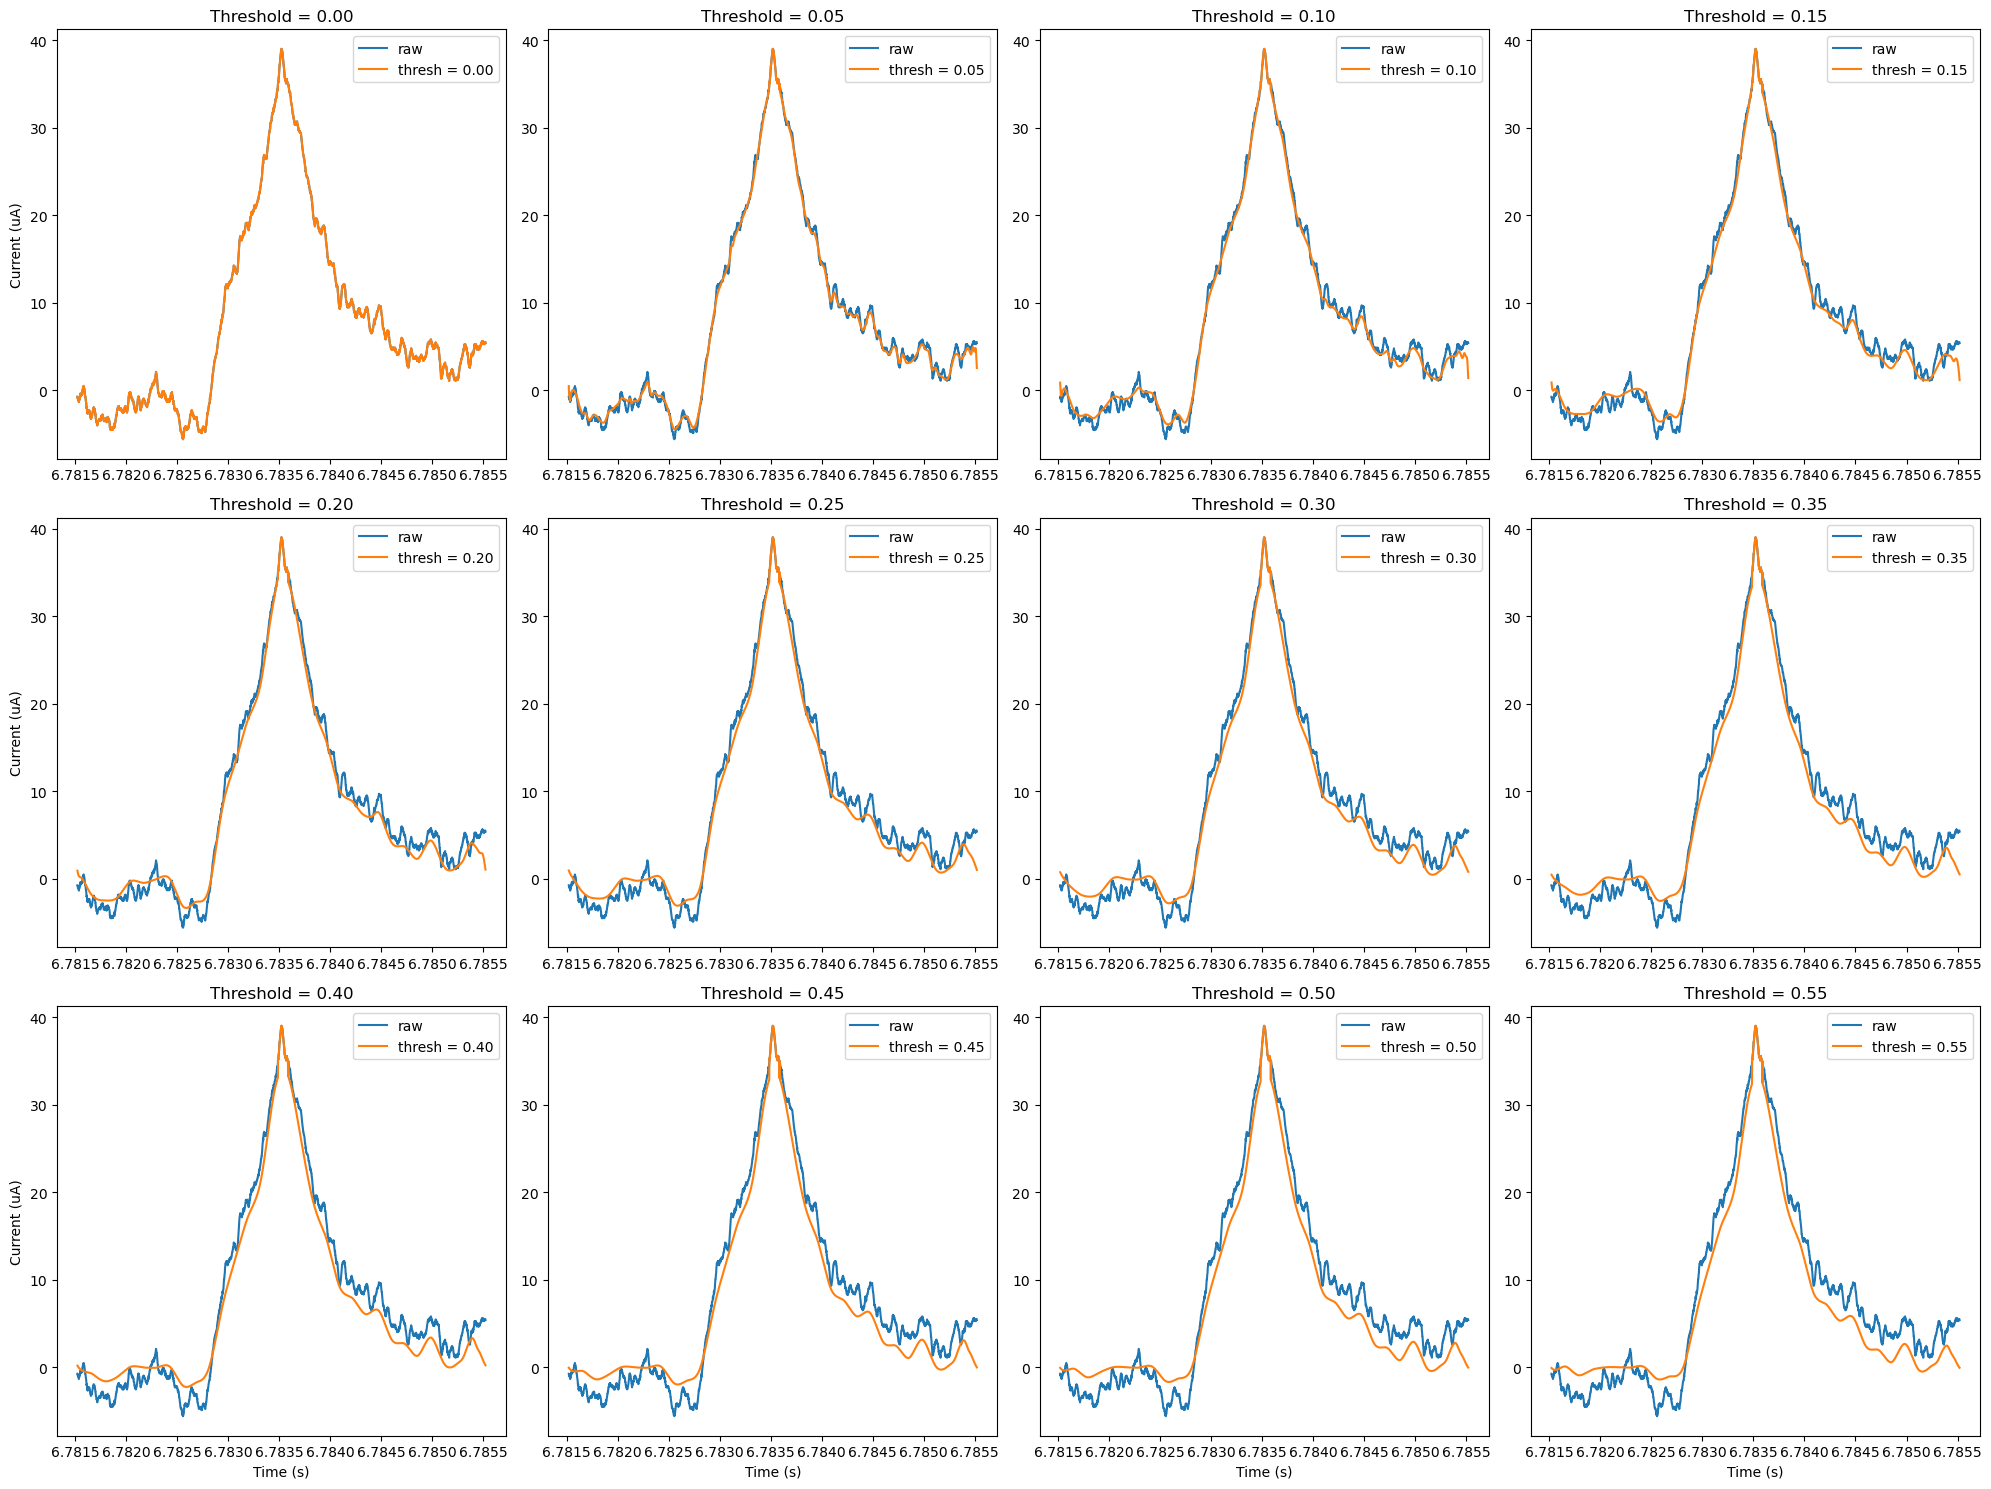

In [134]:
fig, axs = plt.subplots(3, 4, figsize=(20, 15))

for i in range(12):
    thresh = i * 0.05
    DWT_rec_test, event_time_padded_test, DWT_rec_padded_test, features_df_test, features_list_test, labels_test, all_coeffs_test = DWT_and_features_thresh_trace(data_NR_df["event_time"][0], data_NR_df["event_data"][0], data_NR_df["mean_noise"][0], data_NR_df["sd_threshold"][0], data_NR_df["sd_threshold_lower"][0], ["NR", "NR"], wavelet="coif4", threshold=thresh, NRNS = True)
    
    # Determine the row and column to place the subplot
    row = i // 4
    col = i % 4

    # Plot on the appropriate subplot
    axs[row, col].plot(data_NR_df["event_time"][0][13], data_NR_df["event_data"][0][13], label="raw")
    axs[row, col].plot(event_time_padded_test[13], DWT_rec_padded_test[13], label=f"thresh = {thresh:.2f}")
    axs[row, col].legend()
    axs[row, col].set_title(f"Threshold = {thresh:.2f}")
    
    if col == 0:
        axs[row, col].set_ylabel("Current (uA)")
    if row == 2:    
        axs[row, col].set_xlabel("Time (s)")
        

# Adjust layout for better display
plt.tight_layout()
plt.show()


Inspecting DWT replacement around peaks

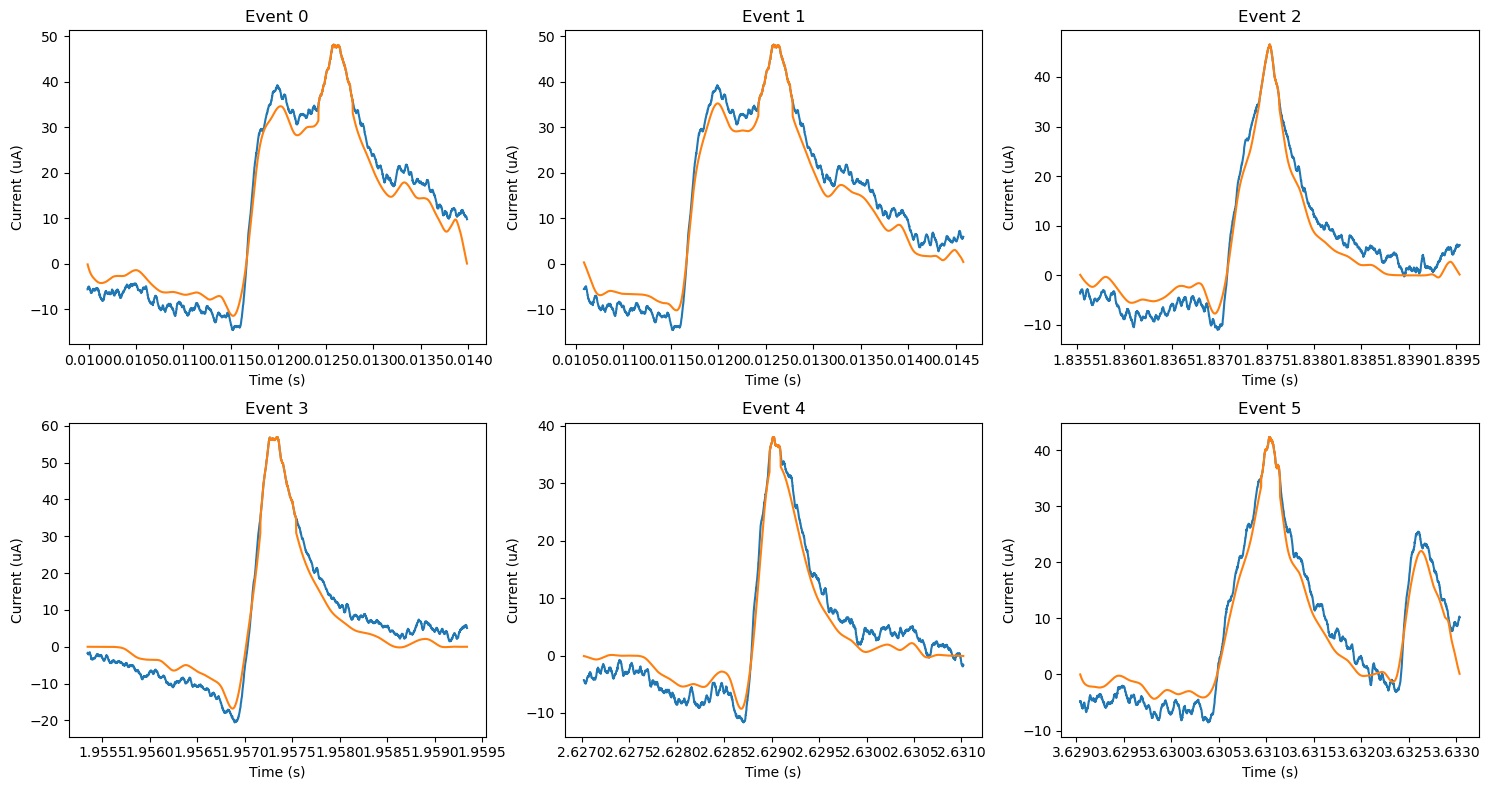

In [89]:
fig, axs = plt.subplots(2, 3, figsize=(15, 8))  # Adjust the size as needed

# Flatten the axs array for easy iteration
axs = axs.flatten()

for i, ax in zip(range(6), axs):
    ax.plot(data_NR_df["event_time"][0][i], data_NR_df["event_data"][0][i])
    ax.plot(event_time_padded_test[i], DWT_rec_padded_test[i])
    ax.set_title(f"Event {i}")
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("Current (uA)")

plt.tight_layout()
plt.show()

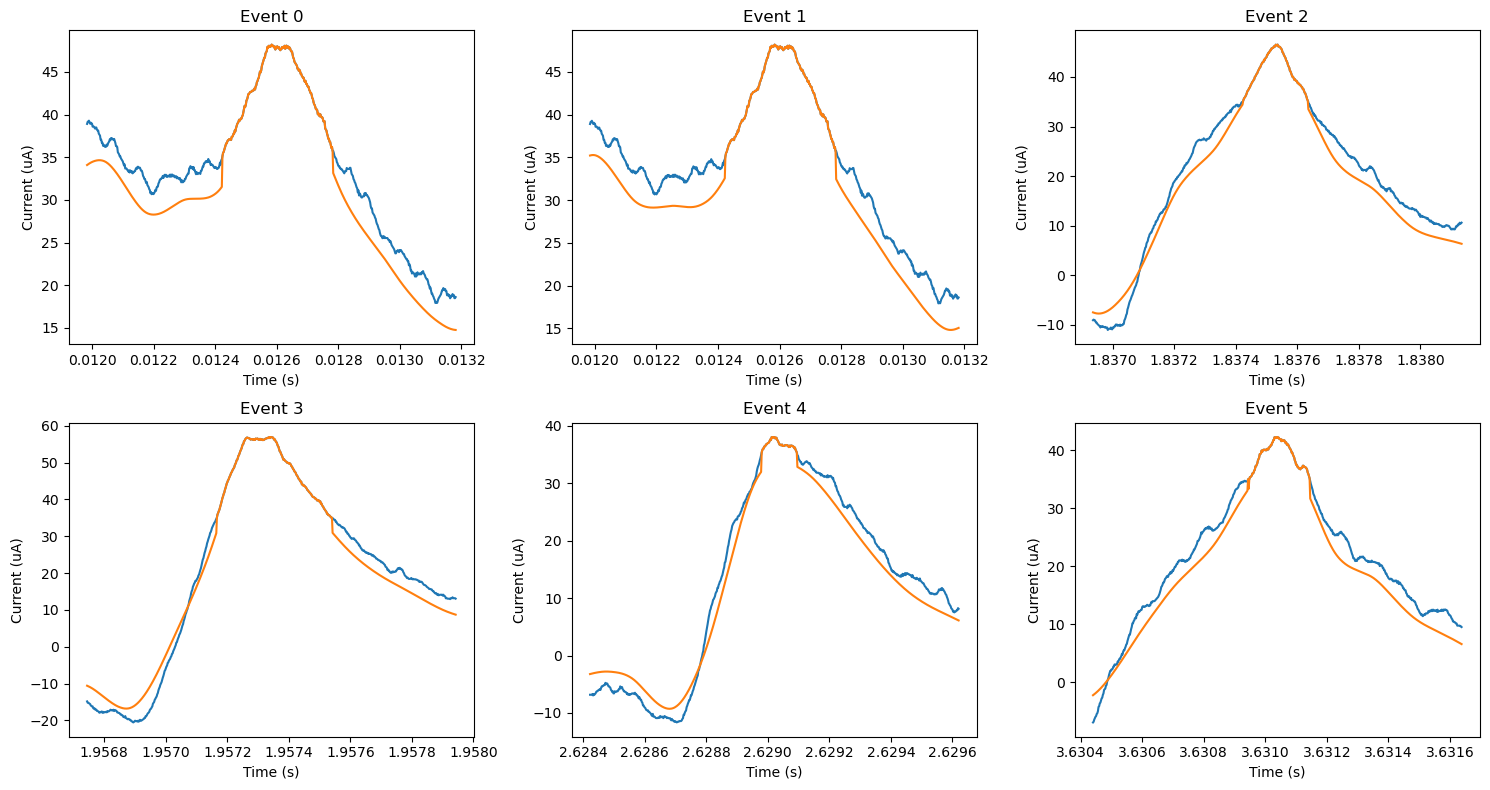

In [90]:

fig, axs = plt.subplots(2, 3, figsize=(15, 8))  # Adjust the size as needed
axs = axs.flatten()

# Define the range to plot around each peak (number of data points on each side of the peak)
points_around_peak = 300  # Adjust this number as needed

for i, ax in zip(range(6), axs):
    # Identify the peak of the event
    peak_index = np.argmax(data_NR_df["event_data"][0][i])

    # Determine the range around the peak to plot
    start = max(peak_index - points_around_peak, 0)
    end = min(peak_index + points_around_peak, len(data_NR_df["event_data"][0][i]))

    # Plot the original event data around the peak
    ax.plot(data_NR_df["event_time"][0][i][start:end], data_NR_df["event_data"][0][i][start:end])

    # Plot the DWT reconstructed data around the peak
    ax.plot(event_time_padded_test[i][start:end], DWT_rec_padded_test[i][start:end])

    ax.set_title(f"Event {i}")
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("Current (uA)")

plt.tight_layout()
plt.show()


##### Dwell times

In [51]:
for i in range(len(event_test)):
    # Check for a trough-peak pattern
    #if event[i] < lower_threshold:
    if event_test[i] < -20 or event_test[i] < data_NS_df["sd_threshold_lower"][1]:
        event_type_test = "trough-peak"
        break
    # Check for a peak-only pattern
    elif event_test[i] > data_NS_df["sd_threshold"][1]:
        event_type_test = "peak-only"
        break


In [74]:
def find_dwell_time_FWHM2(time, event, event_type):
    # sometimes we encounter many points at the half maximum
    # event_smooth is a single event
    start, end = 0, 0

    
    if event_type == "trough-peak" and event[0] >= np.min(event)/2 and event[-1] <= np.max(event)/2:
        half_max_peak = np.max(event)/2
        intercept_peak = np.where(np.diff(np.sign(event - half_max_peak)))[0]
        half_max_trough = np.min(event)/2
        intercept_trough = np.where(np.diff(np.sign(event - half_max_trough)))[0]
        start = intercept_trough[intercept_trough < np.argmin(event)][-1]
        end = intercept_peak[intercept_peak > np.argmax(event)][0]
        
    elif event_type == "peak-only" and event[0] <= np.max(event)/2 and event[-1] <= np.max(event)/2:
        half_max_peak = np.max(event)/2
        intercepts = np.where(np.diff(np.sign(event - half_max_peak)))[0] # find where the signal crosses the half max value
        start = intercepts[intercepts < np.argmax(event)][-1]
        end = intercepts[intercepts > np.argmax(event)][0]
    
    else:
        start = 0
        end = len(event) - 1
        
    dwell_time = time[end] - time[start]
        
    return dwell_time

In [75]:
dwell_test = find_dwell_time_FWHM2(time_test, event_test, event_type_test)
dwell_test

0.0009440000000000004

In [76]:
half_max_peak_test = np.max(event_test)/2
intercept_peak_test= np.where(np.diff(np.sign(event_test - half_max_peak_test)))[0]
half_max_trough_test= np.min(event_test)/2
intercept_trough_test = np.where(np.diff(np.sign(event_test - half_max_trough_test)))[0]
start_test = intercept_trough_test[intercept_trough_test < np.argmin(event_test)][-1]
end_test = intercept_peak_test[intercept_peak_test > np.argmax(event_test)][0]

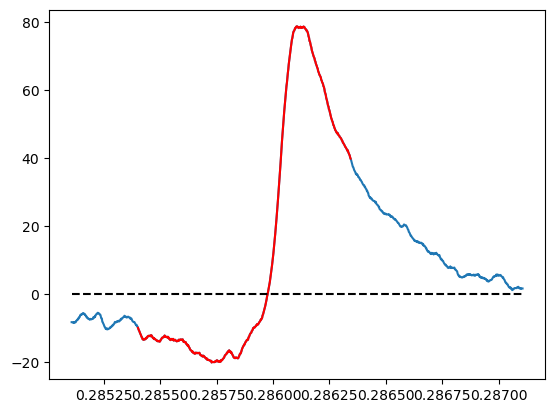

In [79]:
plt.plot(time_test, event_test)

#plot the FWHM of the trough and peak
plt.plot(time_test[start_test:end_test], event_test[start_test:end_test], color = "r")

plt.hlines(0, time_test[0], time_test[-1], color = "k", linestyle = "--")

In [80]:
event_test2 = data_NR_df["event_data"][1][0]
time_test2 = data_NR_df["event_time"][1][0]

In [81]:
for i in range(len(event_test2)):
    # Check for a trough-peak pattern
    #if event[i] < lower_threshold:
    if event_test2[i] < -20 or event_test2[i] < data_NR_df["sd_threshold_lower"][1]:
        event_type_test = "trough-peak"
        break
    # Check for a peak-only pattern
    elif event_test2[i] > data_NR_df["sd_threshold"][1]:
        event_type_test2 = "peak-only"
        break
event_type_test2

'peak-only'

In [82]:
dwell_test2 = find_dwell_time_FWHM2(time_test2, event_test2, event_type_test2)
dwell_test2

0.00047199999999991693

In [84]:
half_max_peak_test2 = np.max(event_test2)/2
intercept_peak_test2 = np.where(np.diff(np.sign(event_test2 - half_max_peak_test2)))[0]
# half_max_trough_test2 = np.min(event_test2)/2
# intercept_trough_test2 = np.where(np.diff(np.sign(event_test2 - half_max_trough_test2)))[0]
start_test2 = intercept_peak_test2[intercept_peak_test2 < np.argmax(event_test2)][-1]
end_test2 = intercept_peak_test2[intercept_peak_test2 > np.argmax(event_test2)][0]

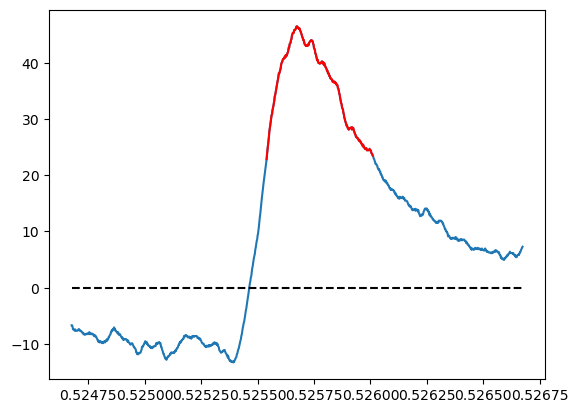

In [86]:
plt.plot(time_test2, event_test2)

#plot the FWHM of the trough and peak
plt.plot(time_test2[start_test2:end_test2], event_test2[start_test2:end_test2], color = "r")

plt.hlines(0, time_test2[0], time_test2[-1], color = "k", linestyle = "--")

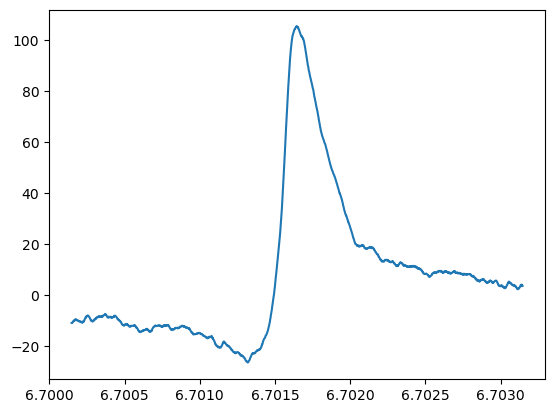

In [210]:
plt.plot(data_NS_df["event_time"][1][65], data_NS_df["event_data"][1][65])

In [213]:
# save to csv
np.savetxt("chatgpt_event_time_NR.csv", data_NR_df["event_time"][1][65], delimiter=",")
np.savetxt("chatgpt_event_data_NR.csv", data_NR_df["event_data"][1][65], delimiter=",")

In [338]:
event_test3 = data_NS_df["event_data"][1][65]
time_test3 = data_NS_df["event_time"][1][65]

In [339]:
event_test3 = data_NS_df["event_data"][1][68]
time_test3 = data_NS_df["event_time"][1][68]

In [340]:
for i in range(len(event_test3)):
    # Check for a trough-peak pattern
    #if event[i] < lower_threshold:
    if event_test3[i] < -20 or event_test3[i] < data_NS_df["sd_threshold_lower"][1]:
        event_type_test = "trough-peak"
        break
    # Check for a peak-only pattern
    elif event_test3[i] > data_NS_df["sd_threshold"][1]:
        event_type_test2 = "peak-only"
        break
event_type_test2

NameError: name 'event_type_test2' is not defined

In [342]:
half_max_peak_test3 = event_test3[int((len(event_test3)+1)/2)] / 2
intercept_peak_test3 = np.where(np.diff(np.sign(event_test3 - half_max_peak_test3)))[0]

half_max_trough_test3 = np.min(event_test3)/2
intercept_trough_test3 = np.where(np.diff(np.sign(event_test3 - half_max_trough_test3)))[0]

start_cond = (intercept_trough_test3 < np.argmin(event_test3)) & (intercept_trough_test3 < (len(event_test3) + 1) / 2)
start_test3 = intercept_trough_test3[start_cond][-1]
#start_test3 = intercept_peak_test3[intercept_peak_test3 < (len(event_test3)+1)/2][0] # an argmax condition could cause errors if theres a second peak present which is larger


end_test3 = intercept_peak_test3[intercept_peak_test3 > (len(event_test3)+1)/2][0] # an argmax condition could cause errors if theres a second peak present which is larger


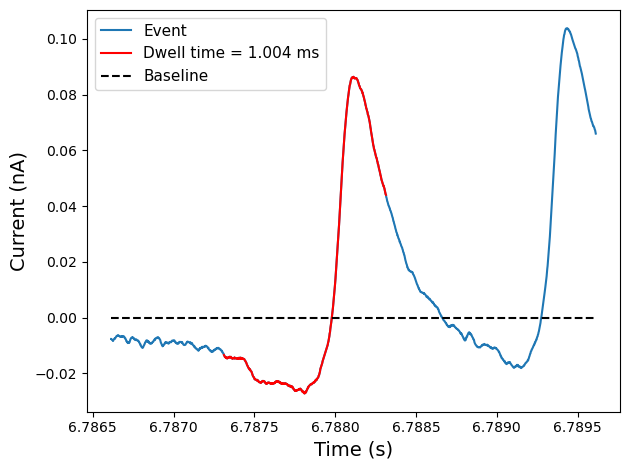

In [367]:
plt.plot(time_test3, event_test3/1000, label = "Event")

#plot the FWHM of the trough and peak
plt.plot(time_test3[start_test3:end_test3], event_test3[start_test3:end_test3]/1000, color = "r", label = f"Dwell time = {(end_test3 - start_test3)*2e-6 * 1000:.3f} ms")

plt.hlines(0, time_test3[0], time_test3[-1], color = "k", linestyle = "--", label = "Baseline")
plt.xlabel("Time (s)", fontsize = 14)
plt.ylabel("Current (nA)", fontsize = 14)
plt.legend(loc = "upper left", fontsize = 11)
plt.tight_layout()
#plt.savefig("MSci_python_images/double_peak_dwelltime_success.png", dpi = 300)
#plt.savefig("MSci_python_images/dwelltime_comparision_NS.png", dpi = 300)
plt.show()

python(2599) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(2600) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(2601) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(2602) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(2603) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(2604) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(2605) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(2606) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(2607) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(2608) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(2609) MallocStackLoggin

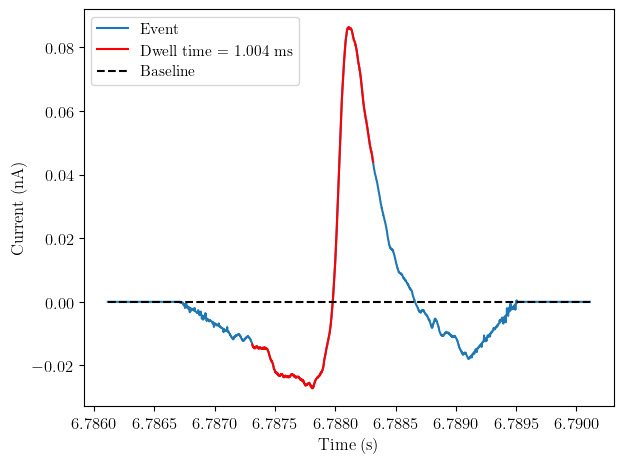

In [344]:
plt.plot(time_test3, event_test3/1000, label = "Event")

#plot the FWHM of the trough and peak
plt.plot(time_test3[start_test3:end_test3], event_test3[start_test3:end_test3]/1000, color = "r", label = f"Dwell time = {(end_test3 - start_test3)*2e-6 * 1000:.3f} ms")

plt.hlines(0, time_test3[0], time_test3[-1], color = "k", linestyle = "--", label = "Baseline")
plt.xlabel("Time (s)")
plt.ylabel("Current (nA)")
plt.legend(loc = "upper left", fontsize = 11)
plt.tight_layout()
#plt.savefig("MSci_python_images/double_peak_dwelltime_success.png", dpi = 300)
#plt.savefig("MSci_python_images/dwelltime_comparision_NS_2.png", dpi = 500)
plt.show()

In [346]:
# import csv to 1d array
event_comparison = np.genfromtxt("event_87_dwelltimecomparision.csv", delimiter=",")
time_comparison = np.genfromtxt("time_87_dwelltimecomparision.csv", delimiter=",")

In [299]:
import matplotlib.ticker as ticker

In [307]:
time_comparison[-1] - time_comparison[0]

0.00030800000000041905

In [347]:
half_max_peak_comp = np.max(event_comparison) / 2
intercept_peak_comp = np.where(np.diff(np.sign(event_comparison - half_max_peak_comp)))[0]


start_comp = intercept_peak_comp[intercept_peak_comp < np.argmax(event_comparison)][-1]

#start_test3 = intercept_peak_test3[intercept_peak_test3 < (len(event_test3)+1)/2][0] # an argmax condition could cause errors if theres a second peak present which is larger


end_comp = intercept_peak_comp[intercept_peak_comp > np.argmax(event_comparison)][0]


python(2660) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(2661) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(2662) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(2663) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(2664) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(2665) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(2666) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(2667) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(2668) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(2669) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(2670) MallocStackLoggin

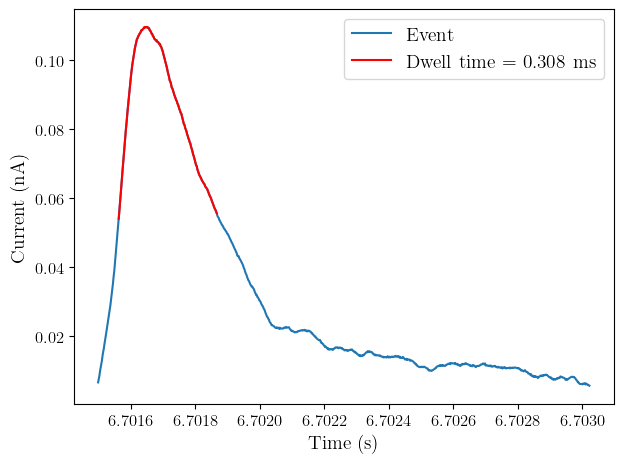

In [349]:
plt.plot(time_comparison, event_comparison, label = "Event")
plt.plot(time_comparison[start_comp:end_comp], event_comparison[start_comp:end_comp], color = "r", label = f"Dwell time = 0.308 ms")
#plt.xticks(np.arange(6.7014, 6.702, 0.0002))
#plt.xlim(6.7015, 6.7019)
#plt.ylim(0,120)
plt.legend(loc = "upper right", fontsize = 14)
plt.xlabel("Time (s)", fontsize = 14)
plt.ylabel("Current (nA)", fontsize = 14)
plt.tight_layout()
plt.savefig("MSci_python_images/dwelltime_NPapp_pythonplot2.png", dpi = 500)
plt.show()


### Feature extraction

NR

In [7]:
def DWT_and_features_multi(data_df, label, thresh = 0.2, wavelet = "bior3.3", NRNS = False):
    results = pd.DataFrame(columns = ["event_time_padded", "DWT_rec_padded", "features_df", "features_list", "labels", "all_coeffs"])
    
    for i in range(len(data_df)):
        event_data = data_df["event_data"][i]
        event_time = data_df["event_time"][i]
        DWT_rec, event_time_padded, DWT_rec_padded, features_df, features_list, labels, all_coeffs = DWT_and_features_thresh_trace(data_df["event_time"][i], data_df["event_data"][i], data_df["mean_noise"][i], data_df["sd_threshold"][i], data_df["sd_threshold_lower"][i], label, wavelet=wavelet, threshold=thresh, NRNS = NRNS)
        
        results.loc[f"run_{i+1}"] = [event_time_padded, DWT_rec_padded, features_df, features_list, labels, all_coeffs]
    
    return results

In [32]:
len(data_NR_df["event_data"][0][12])

2000

In [236]:
data_NR_df

event_time  \
run_1  [[0.009989999999999999, 0.009992, 0.009994, 0....   
run_2  [[0.523676, 0.523678, 0.5236799999999999, 0.52...   

                                              event_data   smo  sd_threshold  \
run_1  [[-5.578137207031432, -5.578161621093841, -5.2...  None     34.961392   
run_2  [[-5.402246093749909, -5.402612304687409, -5.4...  None     34.271066   

       sd_threshold_lower  mean_noise  
run_1          -23.303651    0.002366  
run_2          -22.843753    0.002174

In [8]:
results_NR_df = DWT_and_features_multi(data_NR_df, "NR", NRNS = True)

In [115]:
scaler = MinMaxScaler(feature_range=(-1, 1))
scaled_data = []
features_list_scaled = []

for i in range(len(results_NR_df)):
    scaled_row = []

    # Scale each inner list (event data) individually
    for inner_list in results_NR_df['DWT_rec_padded'].iloc[i]:
        inner_array = np.array(inner_list).reshape(-1, 1)
        scaled_inner_list = scaler.fit_transform(inner_array)
        scaled_row.append(scaled_inner_list.flatten().tolist())
    
    scaled_row_shifted = shift_up(scaled_row)
    scaled_data.append(scaled_row_shifted)
    
    _, _, _, _, features_list, _, _ = DWT_and_features_thresh_trace(
        data_NR_df["event_time"].iloc[i],  # Event time for the current row
        scaled_row,  # Scaled event data for the current row
        data_NR_df["mean_noise"].iloc[i],
        data_NR_df["sd_threshold"].iloc[i],
        data_NR_df["sd_threshold_lower"].iloc[i],
        "NR", 
        wavelet="bior3.3", 
        threshold=0.2, 
        NRNS=True
    )
    features_list_scaled.append(features_list)


results_NR_df['features_list_scaled'] = features_list_scaled


In [15]:
results_NR_df

event_time_padded  \
run_1  [[0.009989999999999999, 0.009992, 0.009994, 0....   
run_2  [[0.523676, 0.523678, 0.5236799999999999, 0.52...   

                                          DWT_rec_padded  \
run_1  [[3.3417438912621584, 0.493500132763398, -1.48...   
run_2  [[-0.15826187850381426, -0.81815438202592, -1....   

                                             features_df  \
run_1        deltaI_c   deltaI_r  deltaI_c/deltaI_r  ...   
run_2        deltaI_c   deltaI_r  deltaI_c/deltaI_r  ...   

                                           features_list  \
run_1  [[48.195693080789965, -13.751862186989678, 3.5...   
run_2  [[46.453111448576365, -12.682996039768662, 3.6...   

                                                  labels  \
run_1  [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...   
run_2  [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...   

                                              all_coeffs  \
run_1  [[[-234.84532368864228, -75.65575613844274, -2...   
run_2  [[[-130.50245526977616, -83.70633214249969, -2...   

                                   DWT_rec_padded_scaled  \
run_1  [[-0.44820291928774286, -0.5401595347243555, -...   
run_2  [[-0.5764834549593026, -0.5988012073968354, -0...   

                                    features_list_scaled  
run_1  [[0.9572525746442947, -1.0007913358783318, 0.9...  
run_2  [[0.9466833912519592, -0.974090000657283, 0.97...

In [81]:
event_time_padded_NR = results_NR_df["event_time_padded"][0] + results_NR_df["event_time_padded"][1]
DWT_rec_padded_NR = results_NR_df["DWT_rec_padded"][0] + results_NR_df["DWT_rec_padded"][1]

In [100]:
DWT_rec_padded_NR_norm = np.concatenate((results_NR_df["DWT_rec_padded_scaled"].iloc[0], 
                                         results_NR_df["DWT_rec_padded_scaled"].iloc[1]))

In [240]:
features_list_NR = results_NR_df["features_list"][0] + results_NR_df["features_list"][1]
labels_NR = list(results_NR_df["labels"][0]) + list(results_NR_df["labels"][1])

In [243]:
save_with_pickle("features_list_NR_25_feat.pkl", features_list_NR)

In [116]:
features_list_NR_norm = results_NR_df["features_list_scaled"][0] + results_NR_df["features_list_scaled"][1]

In [41]:
len(labels_NR)

286

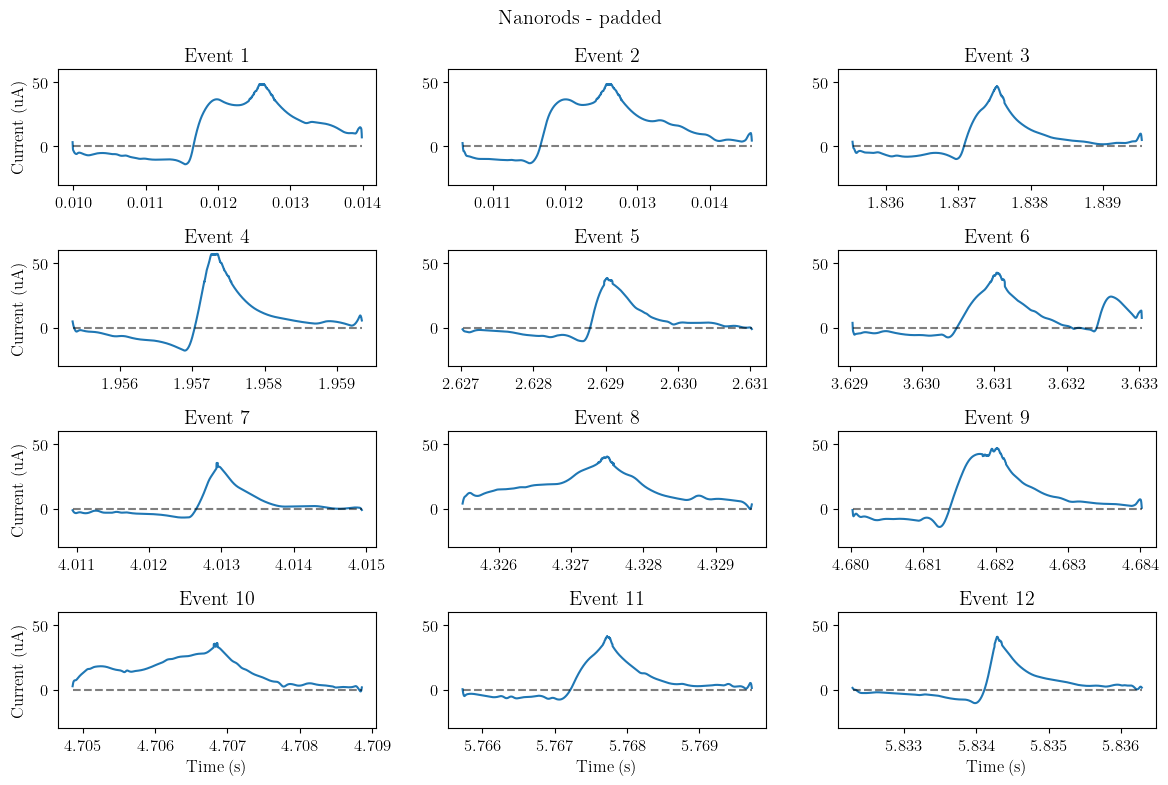

In [42]:
fig, axes = plt.subplots(4, 3, figsize=(12, 8))
fig.suptitle('Nanorods - padded')

for i in range(12):
    row = i // 3
    col = i % 3
    ax = axes[row, col]
    ax.plot(event_time_padded_NR[i], DWT_rec_padded_NR[i])
    ax.hlines(0, event_time_padded_NR[i][0], event_time_padded_NR[i][-1], color = "k", linestyle = "--", alpha = 0.5)
    
    if i in [0, 3, 6, 9]:
        ax.set_ylabel('Current (uA)')
    if i in [9, 10, 11]:
        ax.set_xlabel('Time (s)')
    ax.set_title(f'Event {i+1}')
    #ax.set_ylim(-100, 120)
    ax.set_ylim(-30, 60)

plt.tight_layout()
#plt.savefig("MSci_python_images/NR_events.png", dpi = 300)
plt.show()

NS

In [39]:
results_NS_df = DWT_and_features_multi(data_NS_df, "NS", NRNS = True)

In [117]:
# normlised data
scaler = MinMaxScaler(feature_range=(-1, 1))
scaled_data = []
features_list_scaled = []

# Assuming results_NR_df['DWT_rec_padded'] and data_NR_df are properly aligned by index
for i in range(len(results_NS_df)):
    scaled_row = []

    # Scale each inner list (event data) individually
    for inner_list in results_NS_df['DWT_rec_padded'].iloc[i]:
        inner_array = np.array(inner_list).reshape(-1, 1)
        scaled_inner_list = scaler.fit_transform(inner_array)
        scaled_row.append(scaled_inner_list.flatten().tolist())
    scaled_row_shifted = shift_up(scaled_row)
    scaled_data.append(scaled_row_shifted)
        
    # Here, you should pass each scaled_row as event_data to your function
    # Ensure this function can handle the input format correctly
    _, _, _, _, features_list, _, _ = DWT_and_features_thresh_trace(
        data_NS_df["event_time"].iloc[i],  # Event time for the current row
        scaled_row,  # Scaled event data for the current row
        data_NS_df["mean_noise"].iloc[i],
        data_NS_df["sd_threshold"].iloc[i],
        data_NS_df["sd_threshold_lower"].iloc[i],
        "NR", 
        wavelet="bior3.3", 
        threshold=0.2, 
        NRNS=True
    )
    features_list_scaled.append(features_list)

results_NS_df['DWT_rec_padded_scaled'] = scaled_data
results_NS_df['features_list_scaled'] = features_list_scaled


In [94]:
results_NS_df

event_time_padded  \
run_1  [[0.074073999999999, 0.074075999999999, 0.0740...   
run_2  [[0.284107999999999, 0.284109999999999, 0.2841...   

                                          DWT_rec_padded  \
run_1  [[-0.3273413900591978, -0.3374298148126644, -0...   
run_2  [[-0.2506773625688431, -0.2580067640588041, -0...   

                                             features_df  \
run_1         deltaI_c   deltaI_r  deltaI_c/deltaI_r ...   
run_2         deltaI_c   deltaI_r  deltaI_c/deltaI_r ...   

                                           features_list  \
run_1  [[96.93714474384568, -21.87381567634321, 4.431...   
run_2  [[78.79835658051965, -18.79193992201079, 4.193...   

                                                  labels  \
run_1  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
run_2  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   

                                              all_coeffs  \
run_1  [[[0.0, -90.43080856004946, -281.493516804314,...   
run_2  [[[0.0, -58.257728927666285, -190.955503932182...   

                                   DWT_rec_padded_scaled  \
run_1  [[0.0, -0.0001698231327781352, -0.000333462410...   
run_2  [[0.0, -0.0001502075872834574, -0.000294806859...   

                                    features_list_scaled  
run_1  [[0.9644497789564018, -0.9741320009011716, 0.9...  
run_2  [[0.9956705295452554, -0.9789583722217277, 1.0...

In [70]:
def shift_up(DWT_padded):
    DWT_padded = np.array([np.array(DWT_padded[i]) for i in range(len(DWT_padded))])
    
    for i in DWT_padded:
        start_shift = 0 - i[0]
        i += start_shift
    return DWT_padded

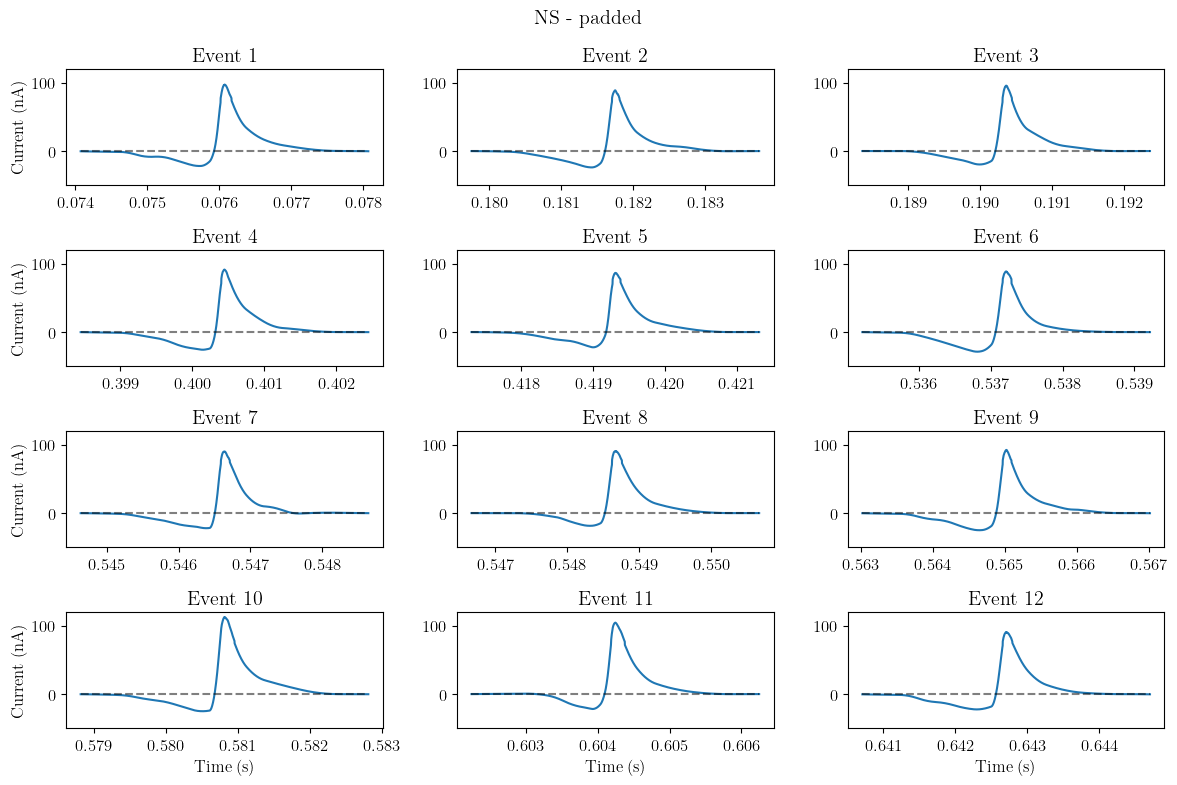

In [211]:
fig, axes = plt.subplots(4, 3, figsize=(12, 8))
fig.suptitle('NS - padded')

for i in range(12):
    row = i // 3
    col = i % 3
    ax = axes[row, col]
    ax.plot(event_time_padded_NS[i], DWT_rec_padded_NS[i])
    ax.hlines(0, event_time_padded_NS[i][0], event_time_padded_NS[i][-1], color = "k", linestyle = "--", alpha = 0.5)
    
    if i in [0, 3, 6, 9]:
        ax.set_ylabel('Current (nA)')
    if i in [9, 10, 11]:
        ax.set_xlabel('Time (s)')
    ax.set_title(f'Event {i+1}')
    #ax.set_ylim(-100, 120)
    ax.set_ylim(-50, 120)

plt.tight_layout()
#plt.savefig("MSci_python_images/NR_events.png", dpi = 300)
plt.show()

In [55]:
event_time_padded_NS = results_NS_df["event_time_padded"][0] + results_NS_df["event_time_padded"][1]
DWT_rec_padded_NS = results_NS_df["DWT_rec_padded"][0] + results_NS_df["DWT_rec_padded"][1]

In [56]:
save_with_pickle("event_time_padded_NS", event_time_padded_NS)
save_with_pickle("DWT_rec_padded_NS", DWT_rec_padded_NS)

In [57]:
save_with_pickle("event_time_padded_NR", event_time_padded_NR)
save_with_pickle("DWT_rec_padded_NR", DWT_rec_padded_NR)

In [228]:
features_list_NS = results_NS_df["features_list"][0] + results_NS_df["features_list"][1]
labels_NS = list(results_NS_df["labels"][0]) + list(results_NS_df["labels"][1])

In [118]:
features_list_NS_norm = results_NS_df["features_list_scaled"][0] + results_NS_df["features_list_scaled"][1]

In [59]:
len(labels_NS)

1426

In [60]:
event_time_padded_NRNS = event_time_padded_NR + event_time_padded_NS
DWT_rec_padded_NRNS = DWT_rec_padded_NR + DWT_rec_padded_NS

In [99]:
DWT_rec_padded_NS_norm = np.concatenate((results_NS_df["DWT_rec_padded_scaled"].iloc[0], 
                                         results_NS_df["DWT_rec_padded_scaled"].iloc[1]))

In [61]:
save_with_pickle("event_time_padded_NRNS", event_time_padded_NRNS)
save_with_pickle("DWT_rec_padded_NRNS", DWT_rec_padded_NRNS)

In [2]:
event_time_padded_NR = unpickle("event_time_padded_NR")
DWT_rec_padded_NR = unpickle("DWT_rec_padded_NR")
event_time_padded_NS = unpickle("event_time_padded_NS")
DWT_rec_padded_NS = unpickle("DWT_rec_padded_NS")
event_time_padded_NRNS = unpickle("event_time_padded_NRNS")
DWT_rec_padded_NRNS = unpickle("DWT_rec_padded_NRNS")

In [229]:
features_list_NRNS = features_list_NR + features_list_NS
labels_NRNS = labels_NR + labels_NS

ValueError: operands could not be broadcast together with shapes (286,20) (1426,25) 

In [119]:
features_list_NRNS_norm = features_list_NR_norm + features_list_NS_norm

In [120]:
save_with_pickle("features_list_NRNS_norm.pkl", features_list_NRNS_norm)


In [114]:
save_with_pickle("features_list_NRNS_norm2.pkl", features_list_NRNS_norm)


In [96]:
save_with_pickle("features_list_NRNS.pkl", features_list_NRNS)
save_with_pickle("labels_NRNS.pkl", labels_NRNS)

In [3]:
features_list_NRNS = unpickle("features_list_NRNS.pkl")
labels_NRNS = unpickle("labels_NRNS.pkl")

##### ML Models

In [521]:
X_train_02_bior33_NRNS, X_test_02_bior33_NRNS, y_train_02_bior33_NRNS, y_test_02_bior33_NRNS, y_pred_02_bior33_NRNS, search_02_bior33_NRNS, best_params_02_bior33_NRNS = hyperparam_op(
    "XG", "random", features_list_NRNS, labels_NRNS)


XG best params using random: {'XG__colsample_bytree': 0.8, 'XG__gamma': 0.3, 'XG__learning_rate': 0.07673852499523488, 'XG__max_depth': 18, 'XG__min_child_weight': 7, 'XG__n_estimators': 708, 'XG__subsample': 0.5}
Average CV accuracy: 1.0 ± 0.0


In [522]:
X_train_02_bior33_NRNS_norm, X_test_02_bior33_NRNS_norm, y_train_02_bior33_NRNS_norm, y_test_02_bior33_NRNS_norm, y_pred_02_bior33_NRNS_norm, search_02_bior33_NRNS_norm, best_params_02_bior33_NRNS_norm = hyperparam_op(
    "XG", "random", features_list_NRNS_norm, labels_NRNS)


XG best params using random: {'XG__colsample_bytree': 0.5, 'XG__gamma': 0.2, 'XG__learning_rate': 0.3565320964602151, 'XG__max_depth': 5, 'XG__min_child_weight': 1, 'XG__n_estimators': 104, 'XG__subsample': 0.75}
Average CV accuracy: 0.9992700729927007 ± 0.0


In [269]:
X_train_02_bior33, X_test_02_bior33, y_train_02_bior33, y_test_02_bior33 = train_test_split(X_02_bior33, y_02_bior33, test_size=0.2, random_state=42, stratify=y_02_bior33)


In [270]:
X_train_02_bior33_NRNS, X_test_02_bior33_NRNS, y_train_02_bior33_NRNS, y_test_02_bior33_NRNS, y_pred_02_bior33_NRNS, search_02_bior33_NRNS, best_params_02_bior33_NRNS = hyperparam_op(
    "XG", "random", X_train_02_bior33, y_train_02_bior33)


XG best params using random: {'XG__colsample_bytree': 0.8, 'XG__gamma': 0.3, 'XG__learning_rate': 0.07912237979817976, 'XG__max_depth': 14, 'XG__min_child_weight': 3, 'XG__n_estimators': 301, 'XG__subsample': 0.75}
Average CV accuracy: 0.9990825688073395 ± 0.0


train

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      1140
         1.0       1.00      1.00      1.00       229

    accuracy                           1.00      1369
   macro avg       1.00      1.00      1.00      1369
weighted avg       1.00      1.00      1.00      1369

Accuracy: 1.0
Specificity: 1.0


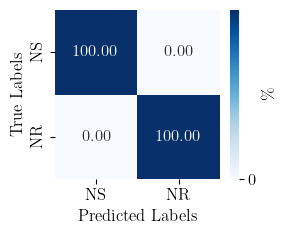

In [523]:
print(classification_report(y_train_02_bior33_NRNS, y_pred_02_bior33_NRNS))
print("Accuracy:", accuracy_score(y_train_02_bior33_NRNS, y_pred_02_bior33_NRNS))


cm_CV_XG_02_bior33_NRNS = confusion_matrix(y_train_02_bior33_NRNS, y_pred_02_bior33_NRNS)
cm_percentages_bior33_NRNS = cm_CV_XG_02_bior33_NRNS / cm_CV_XG_02_bior33_NRNS.sum(axis=1)[:, np.newaxis]

tn, fp, fn, tp = cm_CV_XG_02_bior33_NRNS.ravel()
specificity = tn / (tn + fp)
print("Specificity:", specificity)

classes = ['NS', 'NR']

plt.figure(figsize=(3, 2.5))
sns.heatmap(cm_percentages_bior33_NRNS, annot=True, fmt=".2%", cbar = True, cmap='Blues', cbar_kws={'ticks': [0, 20, 40, 60, 80, 100]}, xticklabels=classes, yticklabels=classes)  # Use .2% to format numbers as percentages
plt.gcf().axes[-1].set_ylabel('$\%$', size=12)

plt.ylabel('True Labels')
plt.xlabel('Predicted Labels')
plt.tight_layout()
#plt.savefig("MSci_python_images/NRNS_XG_02_bior33_cm_train.png", dpi=300)
plt.show()

norm train

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      1140
         1.0       1.00      1.00      1.00       229

    accuracy                           1.00      1369
   macro avg       1.00      1.00      1.00      1369
weighted avg       1.00      1.00      1.00      1369

Accuracy: 0.9992695398100804
Specificity: 0.9991228070175439


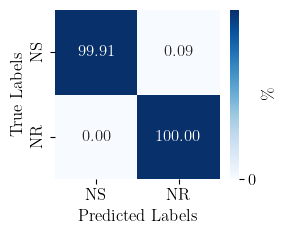

In [524]:
print(classification_report(y_train_02_bior33_NRNS_norm, y_pred_02_bior33_NRNS_norm))
print("Accuracy:", accuracy_score(y_train_02_bior33_NRNS_norm, y_pred_02_bior33_NRNS_norm))


cm_CV_XG_02_bior33_NRNS_norm = confusion_matrix(y_train_02_bior33_NRNS_norm, y_pred_02_bior33_NRNS_norm)
cm_percentages_bior33_NRNS_norm = cm_CV_XG_02_bior33_NRNS_norm / cm_CV_XG_02_bior33_NRNS_norm.sum(axis=1)[:, np.newaxis]

tn, fp, fn, tp = cm_CV_XG_02_bior33_NRNS_norm.ravel()
specificity = tn / (tn + fp)
print("Specificity:", specificity)

classes = ['NS', 'NR']

plt.figure(figsize=(3, 2.5))
sns.heatmap(cm_percentages_bior33_NRNS_norm, annot=True, fmt=".2%", cbar = True, cmap='Blues', cbar_kws={'ticks': [0, 20, 40, 60, 80, 100]}, xticklabels=classes, yticklabels=classes)  # Use .2% to format numbers as percentages
plt.gcf().axes[-1].set_ylabel('$\%$', size=12)

plt.ylabel('True Labels')
plt.xlabel('Predicted Labels')
plt.tight_layout()
#plt.savefig("MSci_python_images/NRNS_XG_02_bior33_cm_train_norm.png", dpi=300)
plt.show()

best model test

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       286
         1.0       1.00      0.98      0.99        57

    accuracy                           1.00       343
   macro avg       1.00      0.99      0.99       343
weighted avg       1.00      1.00      1.00       343

Accuracy: 0.9970845481049563


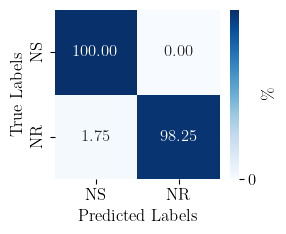

In [525]:
best_model_XG_random_02_bior33_NRNS = search_02_bior33_NRNS.best_estimator_
predictions_best_model_XG_02_bior33_NRNS = best_model_XG_random_02_bior33_NRNS.predict(X_test_02_bior33_NRNS)

cm_best_model_XG_02_bior33_NRNS = confusion_matrix(y_test_02_bior33_NRNS, predictions_best_model_XG_02_bior33_NRNS)
cm_percentages_best_model_XG_02_bior33_NRNS = cm_best_model_XG_02_bior33_NRNS / cm_best_model_XG_02_bior33_NRNS.sum(axis=1)[:, np.newaxis]

print(classification_report(y_test_02_bior33_NRNS, predictions_best_model_XG_02_bior33_NRNS))
print("Accuracy:", accuracy_score(y_test_02_bior33_NRNS, predictions_best_model_XG_02_bior33_NRNS))

plt.figure(figsize=(3, 2.5))
sns.heatmap(cm_percentages_best_model_XG_02_bior33_NRNS, annot=True, fmt=".2%", cbar = True, cmap='Blues', cbar_kws={'ticks': [0, 20, 40, 60, 80, 100]}, xticklabels=classes, yticklabels=classes)  # Use .2% to format numbers as percentages
plt.gcf().axes[-1].set_ylabel('$\%$', size=12)

plt.ylabel('True Labels')
plt.xlabel('Predicted Labels')
plt.tight_layout()
#plt.savefig("MSci_python_images/NRNS_XG_02_bior33_cm_test.png", dpi=300)
plt.show()

norm best model test

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       286
         1.0       0.98      1.00      0.99        57

    accuracy                           1.00       343
   macro avg       0.99      1.00      0.99       343
weighted avg       1.00      1.00      1.00       343

Accuracy: 0.9970845481049563


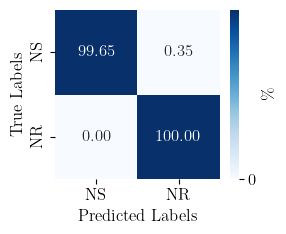

In [526]:
best_model_XG_random_02_bior33_NRNS_norm = search_02_bior33_NRNS_norm.best_estimator_
predictions_best_model_XG_02_bior33_NRNS_norm = best_model_XG_random_02_bior33_NRNS_norm.predict(X_test_02_bior33_NRNS_norm)

cm_best_model_XG_02_bior33_NRNS_norm = confusion_matrix(y_test_02_bior33_NRNS_norm, predictions_best_model_XG_02_bior33_NRNS_norm)
cm_percentages_best_model_XG_02_bior33_NRNS_norm = cm_best_model_XG_02_bior33_NRNS_norm / cm_best_model_XG_02_bior33_NRNS_norm.sum(axis=1)[:, np.newaxis]

print(classification_report(y_test_02_bior33_NRNS_norm, predictions_best_model_XG_02_bior33_NRNS_norm))
print("Accuracy:", accuracy_score(y_test_02_bior33_NRNS_norm, predictions_best_model_XG_02_bior33_NRNS_norm))

plt.figure(figsize=(3, 2.5))
sns.heatmap(cm_percentages_best_model_XG_02_bior33_NRNS_norm, annot=True, fmt=".2%", cbar = True, cmap='Blues', cbar_kws={'ticks': [0, 20, 40, 60, 80, 100]}, xticklabels=classes, yticklabels=classes)  # Use .2% to format numbers as percentages
plt.gcf().axes[-1].set_ylabel('$\%$', size=12)

plt.ylabel('True Labels')
plt.xlabel('Predicted Labels')
plt.tight_layout()
#plt.savefig("MSci_python_images/NRNS_XG_02_bior33_cm_test_norm.png", dpi=300)
plt.show()

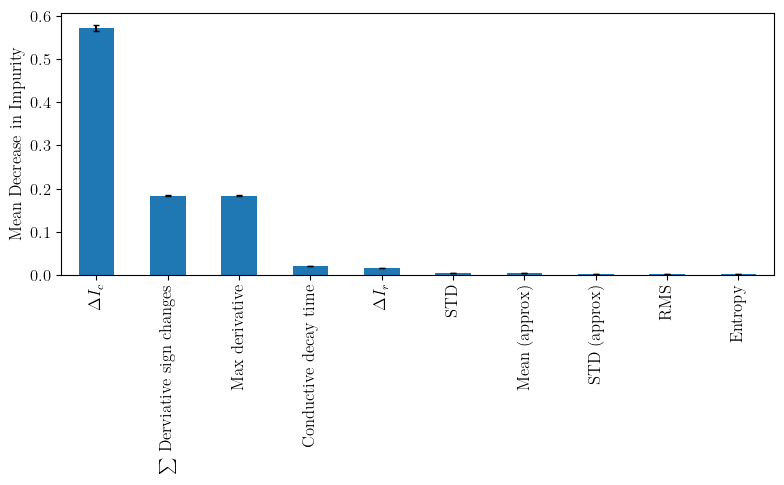

In [585]:
feature_names = ["$\Delta I_c$", "$\Delta I_r$", "$\Delta I_c$ / $\Delta I_r$", "Dwell time", "skew", "kurtosis", "Total area", "Conductive area", "Resistive area", "Entropy", "Mean", "STD", "Variance", "RMS", "Max derivative", "Min derivative", "$\sum$ $\|$ Derivative changes $\|$", "$\sum$ Derviative sign changes", "Resistive decay time", "Conductive decay time", "Mean (approx)", "STD (approx)", "Energy (approx)", "Spectral entropy (approx)", "Band power (approx)"]

result = permutation_importance(best_model_XG_random_02_bior33_NRNS, X_test_02_bior33_NRNS, y_test_02_bior33_NRNS, n_repeats=10, random_state=0, n_jobs=2)

xgboost_model = best_model_XG_random_02_bior33_NRNS.named_steps['XG']
importances_MDI = xgboost_model.feature_importances_
forest_importances = pd.Series(importances_MDI, index=feature_names)

# Assuming 'result.importances_std' contains the standard deviation of permutation importance
# Make sure this standard deviation is relevant or meaningful to display alongside MDI importances
forest_importances_sd = pd.Series(result.importances_std, index=feature_names)

forest_importances, forest_importances_sd = forest_importances.drop(["skew", "kurtosis"]), forest_importances_sd.drop(["skew", "kurtosis"])

# Sort the importances in descending order for plotting
sorted_idx = forest_importances.argsort()[::-1]

# Plotting
plt.figure(figsize=(8, 5))
ax = plt.gca()  # Get current axis for plotting

# Plot MDI importances with error bars from permutation importance's standard deviation
forest_importances.iloc[sorted_idx][:10].plot.bar(yerr=forest_importances_sd.iloc[sorted_idx][:10], ax=ax, capsize=2)

ax.set_ylabel("Mean Decrease in Impurity")
plt.tight_layout()
plt.savefig("MSci_python_images/NRNS_feature_importance_MDI_XG_02_bior33.png", dpi=500)
plt.show()

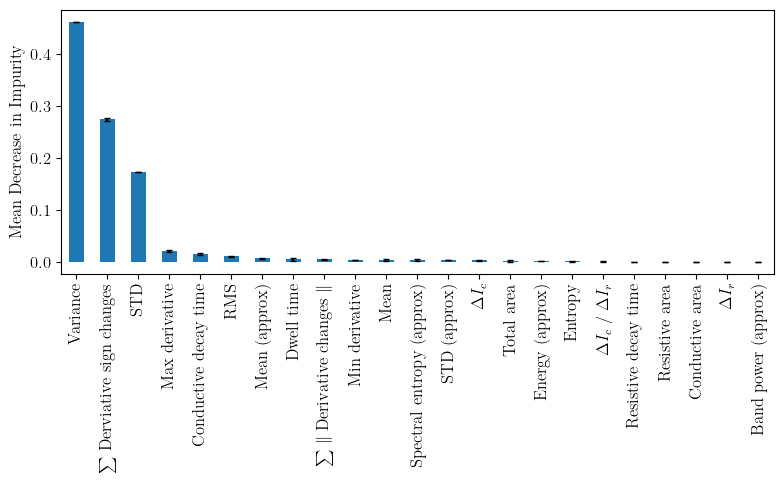

In [547]:
feature_names = ["$\Delta I_c$", "$\Delta I_r$", "$\Delta I_c$ / $\Delta I_r$", "Dwell time", "skew", "kurtosis", "Total area", "Conductive area", "Resistive area", "Entropy", "Mean", "STD", "Variance", "RMS", "Max derivative", "Min derivative", "$\sum$ $\|$ Derivative changes $\|$", "$\sum$ Derviative sign changes", "Resistive decay time", "Conductive decay time", "Mean (approx)", "STD (approx)", "Energy (approx)", "Spectral entropy (approx)", "Band power (approx)"]

result_norm = permutation_importance(best_model_XG_random_02_bior33_NRNS_norm, X_test_02_bior33_NRNS_norm, y_test_02_bior33_NRNS_norm, n_repeats=10, random_state=42, n_jobs=-1)

xgboost_model_norm = best_model_XG_random_02_bior33_NRNS_norm.named_steps['XG']
importances_MDI_norm = xgboost_model_norm.feature_importances_
forest_importances_norm = pd.Series(importances_MDI_norm, index=feature_names)

# Assuming 'result.importances_std' contains the standard deviation of permutation importance
# Make sure this standard deviation is relevant or meaningful to display alongside MDI importances
forest_importances_sd_norm = pd.Series(result_norm.importances_std, index=feature_names)

forest_importances_norm, forest_importances_sd_norm = forest_importances_norm.drop(["skew", "kurtosis"]), forest_importances_sd_norm.drop(["skew", "kurtosis"])

# Sort the importances in descending order for plotting
sorted_idx_norm = forest_importances_norm.argsort()[::-1]

# Plotting
plt.figure(figsize=(8, 5))
ax = plt.gca()  # Get current axis for plotting

# Plot MDI importances with error bars from permutation importance's standard deviation
forest_importances_norm.iloc[sorted_idx_norm].plot.bar(yerr=forest_importances_sd_norm.iloc[sorted_idx_norm], ax=ax, capsize=2)

ax.set_ylabel("Mean Decrease in Impurity")
plt.tight_layout()
#plt.savefig("MSci_python_images/feature_importance_MDI_XG_02_bior33.png", dpi=300)
plt.show()

In [151]:
from joblib import dump

dump(best_model_XG_random_02_bior33_NRNS, 'best_model_XG_random_02_bior33_NRNS.pkl')

['best_model_XG_random_02_bior33_NRNS.pkl']

CV

In [554]:
from imblearn.pipeline import Pipeline as IMBPipeline # Use this pipeline to handle imblearn steps like SMOTE
from sklearn.metrics import log_loss, roc_auc_score

kf = KFold(n_splits=10, shuffle=True, random_state=42)

scaler = RobustScaler()

    
features_list_NRNS_norm_edit = [lst[:16] + lst[17:] for lst in features_list_NRNS_norm]
#X_02_bior33 = features_list_NRNS_norm_edit #features_list_NRNS_norm
X_02_bior33 = features_list_NRNS_norm
y_02_bior33 = labels_NRNS

X_train_02_bior33, X_test_02_bior33, y_train_02_bior33, y_test_02_bior33 = train_test_split(X_02_bior33, y_02_bior33, test_size=0.3, random_state=42, stratify=y_02_bior33)


#X_train_02_bior33 = scaler.fit_transform(X_train_02_bior33)

clf_pipeline = IMBPipeline([
    ('scaler', RobustScaler()),
    ('smote', SMOTE(random_state=42)),
    ('XG', XGBClassifier(random_state=42, reg_lambda = 5, reg_alpha = 0.1))
])

# Perform k-fold CV
accuracies_02_bior33 = cross_val_score(clf_pipeline, X_train_02_bior33, y_train_02_bior33, cv=kf, scoring='accuracy', n_jobs=-1)  # Use parallel processing

clf_pipeline.fit(X_train_02_bior33, y_train_02_bior33)


# Calculate average accuracy
average_accuracy_02_bior33 = np.mean(accuracies_02_bior33)
sd_accuracy_02_bior33 = np.std(accuracies_02_bior33) / np.sqrt(len(accuracies_02_bior33))
log_loss_02_bior33 = log_loss(y_test_02_bior33, clf_pipeline.predict_proba(X_test_02_bior33))
roc_auc_02_bior33 = roc_auc_score(y_test_02_bior33, clf_pipeline.predict_proba(X_test_02_bior33)[:, 1])

print(f'Average accuracy: {average_accuracy_02_bior33:.5f} $\pm$ {sd_accuracy_02_bior33:.5f}')
print(f'Log loss: {log_loss_02_bior33:.5f}')
print(f'ROC AUC: {roc_auc_02_bior33:.5f}')


Average accuracy: 0.99833 $\pm$ 0.00106
Log loss: 0.00308
ROC AUC: 1.00000


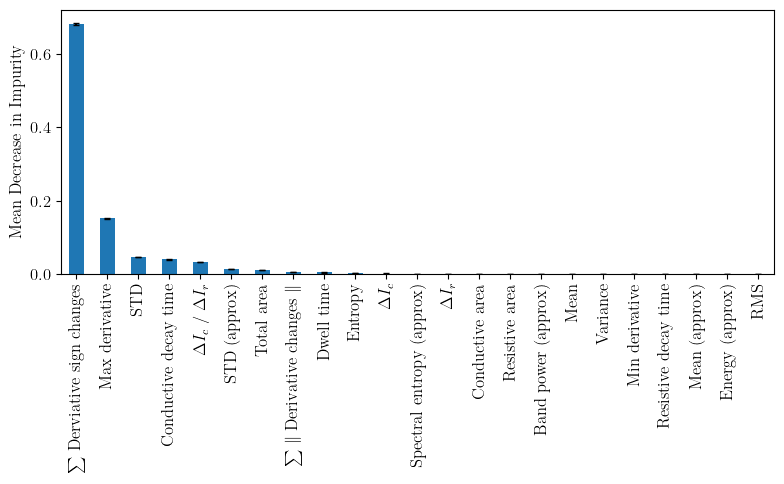

In [555]:
feature_names = ["$\Delta I_c$", "$\Delta I_r$", "$\Delta I_c$ / $\Delta I_r$", "Dwell time", "skew", "kurtosis", "Total area", "Conductive area", "Resistive area", "Entropy", "Mean", "STD", "Variance", "RMS", "Max derivative", "Min derivative", "$\sum$ $\|$ Derivative changes $\|$", "$\sum$ Derviative sign changes", "Resistive decay time", "Conductive decay time", "Mean (approx)", "STD (approx)", "Energy (approx)", "Spectral entropy (approx)", "Band power (approx)"]

result_norm = permutation_importance(clf_pipeline, X_test_02_bior33_NRNS_norm, y_test_02_bior33_NRNS_norm, n_repeats=10, random_state=42, n_jobs=-1)

xgboost_model_norm = clf_pipeline.named_steps['XG']
importances_MDI_norm = xgboost_model_norm.feature_importances_
forest_importances_norm = pd.Series(importances_MDI_norm, index=feature_names)

# Assuming 'result.importances_std' contains the standard deviation of permutation importance
# Make sure this standard deviation is relevant or meaningful to display alongside MDI importances
forest_importances_sd_norm = pd.Series(result_norm.importances_std, index=feature_names)

forest_importances_norm, forest_importances_sd_norm = forest_importances_norm.drop(["skew", "kurtosis"]), forest_importances_sd_norm.drop(["skew", "kurtosis"])

# Sort the importances in descending order for plotting
sorted_idx_norm = forest_importances_norm.argsort()[::-1]

# Plotting
plt.figure(figsize=(8, 5))
ax = plt.gca()  # Get current axis for plotting

# Plot MDI importances with error bars from permutation importance's standard deviation
forest_importances_norm.iloc[sorted_idx_norm].plot.bar(yerr=forest_importances_sd_norm.iloc[sorted_idx_norm], ax=ax, capsize=2)

ax.set_ylabel("Mean Decrease in Impurity")
plt.tight_layout()
#plt.savefig("MSci_python_images/feature_importance_MDI_XG_02_bior33.png", dpi=300)
plt.show()

Specificity: 1.0


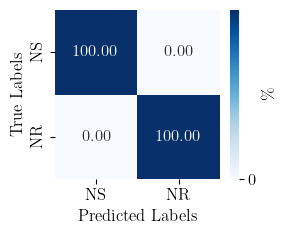

In [507]:
y_pred_02_bior33 = clf_pipeline.predict(X_test_02_bior33)
conf_matrix_02_bior33 = confusion_matrix(y_test_02_bior33, y_pred_02_bior33)

cm_percentages_bior33 = conf_matrix_02_bior33 / conf_matrix_02_bior33.sum(axis=1)[:, np.newaxis]

tn, fp, fn, tp = conf_matrix_02_bior33.ravel()
specificity = tn / (tn + fp)
print("Specificity:", specificity)

classes = ['NS', 'NR']

plt.figure(figsize=(3, 2.5))
sns.heatmap(cm_percentages_bior33, annot=True, fmt=".2%", cbar = True, cmap='Blues', cbar_kws={'ticks': [0, 20, 40, 60, 80, 100]}, xticklabels=classes, yticklabels=classes)  # Use .2% to format numbers as percentages
plt.gcf().axes[-1].set_ylabel('$\%$', size=12)

plt.ylabel('True Labels')
plt.xlabel('Predicted Labels')
plt.tight_layout()
#plt.savefig("MSci_python_images/NRNS_XG_02_bior33_cm_percent.png", dpi=300)
plt.show()

In [417]:
# scaler = RobustScaler()
# X_test_02_bior33_scaled = scaler.fit_transform(X_test_02_bior33)
pred_testtt = clf_pipeline.predict(X_test_02_bior33)


prob_predictions = clf_pipeline.predict_proba(X_test_02_bior33)[:, 1]
log_loss_val = log_loss(y_test_02_bior33, prob_predictions)
auc_score = roc_auc_score(y_test_02_bior33, prob_predictions)

print(classification_report(y_test_02_bior33, pred_testtt))
print("Accuracy:", accuracy_score(y_test_02_bior33, pred_testtt))

print("Log loss:", log_loss_val)
print("AUC score:", auc_score)


              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       428
         1.0       1.00      1.00      1.00        86

    accuracy                           1.00       514
   macro avg       1.00      1.00      1.00       514
weighted avg       1.00      1.00      1.00       514

Accuracy: 1.0
Log loss: 0.003084905416806773
AUC score: 1.0


In [418]:
feature_names

['$\\Delta I_c$',
 '$\\Delta I_r$',
 '$\\Delta I_c$ / $\\Delta I_r$',
 'Dwell time',
 'skew',
 'kurtosis',
 'Total area',
 'Conductive area',
 'Resistive area',
 'Entropy',
 'Mean',
 'STD',
 'Variance',
 'RMS',
 'Max derivative',
 'Min derivative',
 '$\\sum$ absolute derivative changes',
 '$\\sum$ derviative sign changes',
 'Resistive decay time',
 'Conductive decay time',
 'Mean (approx)',
 'STD (approx)',
 'Energy (approx)',
 'Spectral entropy (approx)',
 'Band power (approx)']

In [455]:
y = np.array(y)
# Find indices where y is equal to 0
indices_y_equal_0 = y == 0

# To get the values from X_important_feature where X_important_feature > 12
X_filtered = X_important_feature[X_important_feature > 12]


In [472]:
y2 = np.array(y)[X_important_feature > 7]
len(y2[y2 == 0])

12

In [471]:
y2 = np.array(y)[X_important_feature < 10]
len(y2[y2 == 1])

24

In [479]:
len(x_range_with_intercept)

300

In [498]:
feature_names[16]

'$\\sum$ $\\|$ Derivative changes $\\|$'

##### Logistic regression

- paper: Log-likelihood-based Pseudo-R2 in Logistic Regression: Deriving Sample-sensitive Benchmarks

Optimization terminated successfully.
         Current function value: 0.104989
         Iterations 9


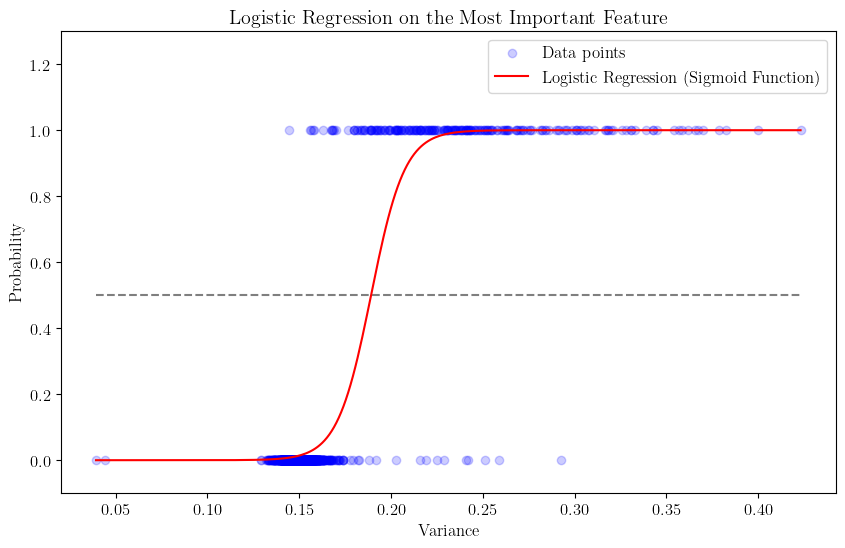

                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                 1369
Model:                          Logit   Df Residuals:                     1367
Method:                           MLE   Df Model:                            1
Date:                Tue, 12 Mar 2024   Pseudo R-squ.:                  0.7675
Time:                        14:44:00   Log-Likelihood:                -143.73
converged:                       True   LL-Null:                       -618.16
Covariance Type:            nonrobust   LLR p-value:                2.353e-208
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -20.5604      1.335    -15.403      0.000     -23.177     -17.944
x1           108.6914      7.713     14.091      0.000      93.573     123.809


In [579]:
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler

# Assuming clf_pipeline['XG'] is your trained XGBoost model
xg_model = best_model_XG_random_02_bior33_NRNS_norm.named_steps['XG']

# Get feature importances and identify the most important feature
feature_importances = xg_model.feature_importances_
most_important_feature_index = np.argmax(feature_importances) #for automatic detection

# Extract the most important feature and target variable
X_important_feature = np.array(X_train_02_bior33_NRNS_norm)[:, most_important_feature_index]
y = y_train_02_bior33_NRNS_norm


# Fit logistic regression
X_with_intercept = sm.add_constant(X_important_feature)  # Adds a constant term to the predictor
logit_model = sm.Logit(y, X_with_intercept).fit()

# To visualize the fit, we need to create a sequence of predictions across the range of X values
# This requires calculating the sigmoid function manually or plotting probabilities for classification
x_range = np.linspace(X_important_feature.min(), X_important_feature.max(), 300)
x_range_with_intercept = sm.add_constant(x_range)

# Predicting probabilities
y_pred = logit_model.predict(x_range_with_intercept)

# Plotting
plt.figure(figsize=(10, 6))
plt.hlines(0.5, X_important_feature.min(), X_important_feature.max(), color='k', linestyle='--', alpha=0.5)
plt.scatter(X_important_feature, y, color='blue', label='Data points', alpha = 0.2)
plt.plot(x_range, y_pred, color='red', label='Logistic Regression (Sigmoid Function)')

plt.xlabel(f'{feature_names[most_important_feature_index]}')
plt.ylabel('Probability')
plt.title('Logistic Regression on the Most Important Feature')
plt.legend()
#plt.xticks(np.arange(2,21,2))
plt.ylim(-0.1, 1.3)
plt.show()

# You can print the summary of the logistic regression model to see how it performs
print(logit_model.summary())

y_pred_probs = logit_model.predict(X_with_intercept)

# Convert probabilities to class predictions using 0.5 as the threshold
y_pred_class = (y_pred_probs >= 0.5).astype(int)



In [580]:
X_test_important_feature = np.array(X_test_02_bior33_NRNS_norm)[:, most_important_feature_index]
X_test_with_intercept = sm.add_constant(X_test_important_feature)

# Predicting probabilities for the test set
y_test_pred_probs = logit_model.predict(X_test_with_intercept)

# Convert probabilities to class labels based on a threshold (e.g., 0.5)
y_test_pred_labels = np.where(y_test_pred_probs > 0.5, 1, 0)

accuracy = accuracy_score(y_test_02_bior33_NRNS_norm, y_test_pred_labels)

conf_matrix = confusion_matrix(y_test_02_bior33_NRNS_norm, y_test_pred_labels)

precision = precision_score(y_test_02_bior33_NRNS_norm, y_test_pred_labels)

recall = recall_score(y_test_02_bior33_NRNS_norm, y_test_pred_labels)

f1 = f1_score(y_test_02_bior33_NRNS_norm, y_test_pred_labels)

fpr, tpr, thresholds = roc_curve(y_test_02_bior33_NRNS_norm, y_test_pred_probs)
roc_auc = auc(fpr, tpr)

# Print metrics
print(f"Accuracy: {accuracy}")
print(f"Confusion Matrix:\n{conf_matrix}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"AUC: {roc_auc}")


Accuracy: 0.9737609329446064
Confusion Matrix:
[[282   4]
 [  5  52]]
Precision: 0.9285714285714286
Recall: 0.9122807017543859
F1 Score: 0.9203539823008849
AUC: 0.9939271255060729


Optimization terminated successfully.
         Current function value: 0.025109
         Iterations 11


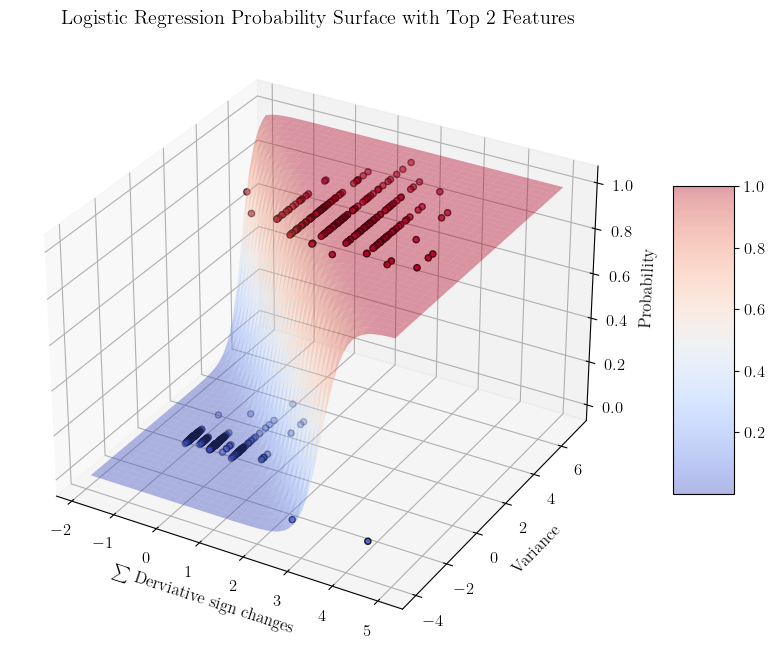

                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                 1369
Model:                          Logit   Df Residuals:                     1366
Method:                           MLE   Df Model:                            2
Date:                Tue, 12 Mar 2024   Pseudo R-squ.:                  0.9444
Time:                        14:44:02   Log-Likelihood:                -34.374
converged:                       True   LL-Null:                       -618.16
Covariance Type:            nonrobust   LLR p-value:                2.925e-254
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -4.9133      0.613     -8.010      0.000      -6.116      -3.711
x1             4.1256      0.543      7.598      0.000       3.061       5.190
x2             2.3249      0.400      5.814      0.0

In [581]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler

import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler

# Assuming clf_pipeline['XG'] is your trained XGBoost model
xg_model = best_model_XG_random_02_bior33_NRNS_norm.named_steps['XG']

# Get feature importances and identify the top 2 features
feature_importances = xg_model.feature_importances_
top_features_indices = np.argsort(feature_importances)[-2:]  # Gets the indices of the top 2 features

# Extract the top 2 features and target variable
X_top_features = np.array(X_train_02_bior33_NRNS_norm)[:, top_features_indices]
y = y_train_02_bior33_NRNS_norm

# Scale features
scaler = StandardScaler()
X_top_features_scaled = scaler.fit_transform(X_top_features)

# Fit logistic regression with 2D features
X_with_intercept = sm.add_constant(X_top_features_scaled)  # Adds a constant term to the predictors
logit_model_2d = sm.Logit(y, X_with_intercept).fit()

# Visualization setup for 3D
x_min, x_max = X_top_features_scaled[:, 0].min() - 1, X_top_features_scaled[:, 0].max() + 1
y_min, y_max = X_top_features_scaled[:, 1].min() - 1, X_top_features_scaled[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))
grid = np.c_[xx.ravel(), yy.ravel()]
grid_with_intercept = sm.add_constant(grid)

# Predict probabilities over the grid
probs = logit_model_2d.predict(grid_with_intercept).reshape(xx.shape)

# Plot
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Surface plot
surf = ax.plot_surface(xx, yy, probs, cmap='coolwarm', edgecolor='none', alpha=0.4)

# Scatter plot of actual points
ax.scatter(X_top_features_scaled[:, 0], X_top_features_scaled[:, 1], y, c=y, marker='o', edgecolor='k', cmap='coolwarm')

# Labels and titles
ax.set_xlabel(f'{feature_names[top_features_indices[0]]}')
ax.set_ylabel(f'{feature_names[top_features_indices[1]]}')
ax.set_zlabel('Probability')
plt.title('Logistic Regression Probability Surface with Top 2 Features')
plt.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

print(logit_model_2d.summary())



In [582]:
# Extract the top 2 features from the test dataset
X_test_top_features = np.array(X_test_02_bior33_NRNS_norm)[:, top_features_indices]

X_test_top_features_scaled = scaler.transform(X_test_top_features)  # Assuming 'scaler' is already fitted on the training data

X_test_with_intercept = sm.add_constant(X_test_top_features_scaled)

y_test_pred_probs = logit_model_2d.predict(X_test_with_intercept)

y_test_pred_labels = np.where(y_test_pred_probs > 0.5, 1, 0)

# Calculate evaluation metrics
accuracy = accuracy_score(y_test_02_bior33_NRNS_norm, y_test_pred_labels)
conf_matrix = confusion_matrix(y_test_02_bior33_NRNS_norm, y_test_pred_labels)
precision = precision_score(y_test_02_bior33_NRNS_norm, y_test_pred_labels)
recall = recall_score(y_test_02_bior33_NRNS_norm, y_test_pred_labels)
f1 = f1_score(y_test_02_bior33_NRNS_norm, y_test_pred_labels)
fpr, tpr, thresholds = roc_curve(y_test_02_bior33_NRNS_norm, y_test_pred_probs)
roc_auc = auc(fpr, tpr)

# Print metrics
print(f"Accuracy: {accuracy}")
print(f"Confusion Matrix:\n{conf_matrix}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"AUC: {roc_auc}")

Accuracy: 0.9970845481049563
Confusion Matrix:
[[286   0]
 [  1  56]]
Precision: 1.0
Recall: 0.9824561403508771
F1 Score: 0.9911504424778761
AUC: 0.999815973500184


Optimization terminated successfully.
         Current function value: 0.050040
         Iterations 10


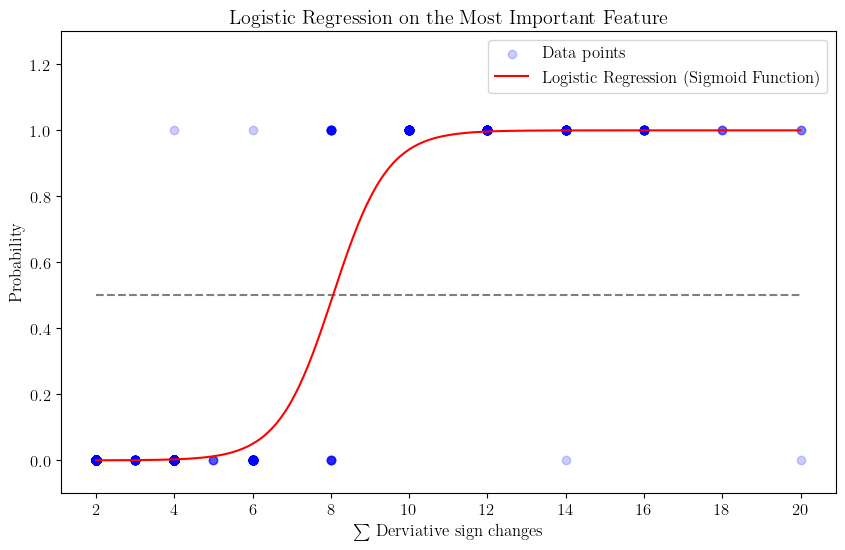

                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                 1198
Model:                          Logit   Df Residuals:                     1196
Method:                           MLE   Df Model:                            1
Date:                Mon, 11 Mar 2024   Pseudo R-squ.:                  0.8890
Time:                        20:15:32   Log-Likelihood:                -59.948
converged:                       True   LL-Null:                       -540.31
Covariance Type:            nonrobust   LLR p-value:                6.198e-211
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -11.5421      1.003    -11.508      0.000     -13.508      -9.576
x1             1.4333      0.132     10.827      0.000       1.174       1.693


In [497]:
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler

# Assuming clf_pipeline['XG'] is your trained XGBoost model
xg_model = clf_pipeline.named_steps['XG']

# Get feature importances and identify the most important feature
feature_importances = xg_model.feature_importances_
most_important_feature_index = 17 # or np.argmax(feature_importances) for automatic detection

# Extract the most important feature and target variable
X_important_feature = np.array(X_train_02_bior33)[:, most_important_feature_index]
y = y_train_02_bior33

# Fit logistic regression
X_with_intercept = sm.add_constant(X_important_feature)  # Adds a constant term to the predictor
logit_model = sm.Logit(y, X_with_intercept).fit()

# To visualize the fit, we need to create a sequence of predictions across the range of X values
# This requires calculating the sigmoid function manually or plotting probabilities for classification
x_range = np.linspace(X_important_feature.min(), X_important_feature.max(), 300)
x_range_with_intercept = sm.add_constant(x_range)

# Predicting probabilities
y_pred = logit_model.predict(x_range_with_intercept)

# Plotting
plt.figure(figsize=(10, 6))
plt.hlines(0.5, X_important_feature.min(), X_important_feature.max(), color='k', linestyle='--', alpha=0.5)
plt.scatter(X_important_feature, y, color='blue', label='Data points', alpha = 0.2)
plt.plot(x_range, y_pred, color='red', label='Logistic Regression (Sigmoid Function)')

plt.xlabel(f'{feature_names[most_important_feature_index]}')
plt.ylabel('Probability')
plt.title('Logistic Regression on the Most Important Feature')
plt.legend()
plt.xticks(np.arange(2,21,2))
plt.ylim(-0.1, 1.3)
plt.show()

# You can print the summary of the logistic regression model to see how it performs
print(logit_model.summary())

y_pred_probs = logit_model.predict(X_with_intercept)

# Convert probabilities to class predictions using 0.5 as the threshold
y_pred_class = (y_pred_probs >= 0.5).astype(int)



In [500]:
# First, prepare the test set similar to how we prepared the training set:
# Assuming X_test_02_bior33 is your test set
X_test_important_feature = np.array(X_test_02_bior33)[:, most_important_feature_index]
X_test_with_intercept = sm.add_constant(X_test_important_feature)

# Predicting probabilities for the test set
y_test_pred_probs = logit_model.predict(X_test_with_intercept)

# Convert probabilities to class labels based on a threshold (e.g., 0.5)
y_test_pred_labels = np.where(y_test_pred_probs > 0.5, 1, 0)

accuracy = accuracy_score(y_test_02_bior33, y_test_pred_labels)

conf_matrix = confusion_matrix(y_test_02_bior33, y_test_pred_labels)

precision = precision_score(y_test_02_bior33, y_test_pred_labels)

recall = recall_score(y_test_02_bior33, y_test_pred_labels)

f1 = f1_score(y_test_02_bior33, y_test_pred_labels)

fpr, tpr, thresholds = roc_curve(y_test_02_bior33, y_test_pred_probs)
roc_auc = auc(fpr, tpr)

# Print metrics
print(f"Accuracy: {accuracy}")
print(f"Confusion Matrix:\n{conf_matrix}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"AUC: {roc_auc}")

# Optionally, you can plot the ROC curve:
# plt.figure(figsize=(8, 6))
# plt.plot(fpr, tpr, color='orange', label=f'ROC curve (area = {roc_auc:.2f})')
# plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Receiver Operating Characteristic (ROC) Curve')
# plt.legend(loc="lower right")
# plt.show()


Accuracy: 0.9844357976653697
Confusion Matrix:
[[428   0]
 [  8  78]]
Precision: 1.0
Recall: 0.9069767441860465
F1 Score: 0.951219512195122
AUC: 0.99978265594436


In [476]:
(len(features_list_NRNS_norm)-36)/len(features_list_NRNS_norm)

0.9789719626168224

In [492]:
feature_names = ["$\Delta I_c$", "$\Delta I_r$", "$\Delta I_c$ / $\Delta I_r$", "Dwell time", "skew", "kurtosis", "Total area", "Conductive area", "Resistive area", "Entropy", "Mean", "STD", "Variance", "RMS", "Max derivative", "Min derivative", "$\sum$ $\|$ Derivative changes $\|$", "$\sum$ Derviative sign changes", "Resistive decay time", "Conductive decay time", "Mean (approx)", "STD (approx)", "Energy (approx)", "Spectral entropy (approx)", "Band power (approx)"]

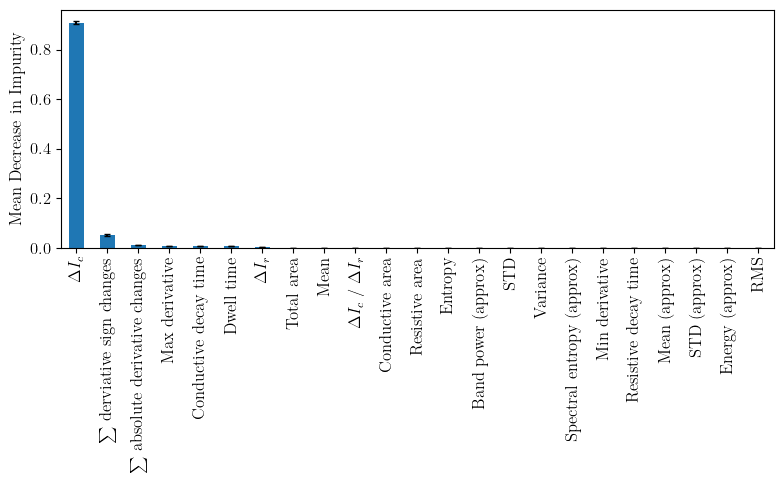

In [399]:
result = permutation_importance(clf_pipeline, X_test_02_bior33, y_test_02_bior33, n_repeats=10, random_state=0, n_jobs=2)

xgboost_model = clf_pipeline.named_steps['XG']
importances_MDI = xgboost_model.feature_importances_
forest_importances = pd.Series(importances_MDI, index=feature_names)

# Assuming 'result.importances_std' contains the standard deviation of permutation importance
# Make sure this standard deviation is relevant or meaningful to display alongside MDI importances
forest_importances_sd = pd.Series(result.importances_std, index=feature_names)

forest_importances, forest_importances_sd = forest_importances.drop(["skew", "kurtosis"]), forest_importances_sd.drop(["skew", "kurtosis"])

# Sort the importances in descending order for plotting
sorted_idx = forest_importances.argsort()[::-1]

# Plotting
plt.figure(figsize=(8, 5))
ax = plt.gca()  # Get current axis for plotting

# Plot MDI importances with error bars from permutation importance's standard deviation
forest_importances.iloc[sorted_idx].plot.bar(yerr=forest_importances_sd.iloc[sorted_idx], ax=ax, capsize=2)

ax.set_ylabel("Mean Decrease in Impurity")
plt.tight_layout()
#plt.savefig("MSci_python_images/feature_importance_MDI_XG_02_bior33.png", dpi=300)
plt.show()

In [331]:
feature_names[17]

'$\\sum$ derviative sign changes'

In [341]:
feature_names_edit = feature_names[:17] + feature_names[18:]

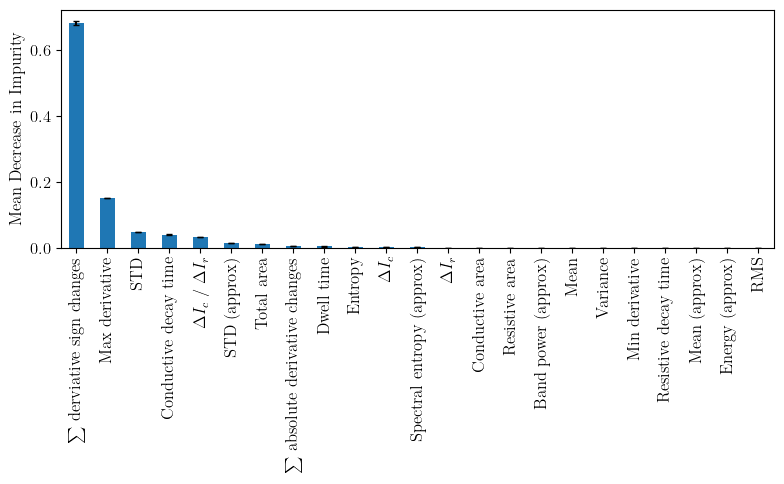

In [397]:
result = permutation_importance(clf_pipeline, X_test_02_bior33, y_test_02_bior33, n_repeats=10, random_state=0, n_jobs=2)

xgboost_model = clf_pipeline.named_steps['XG']
importances_MDI = xgboost_model.feature_importances_
forest_importances = pd.Series(importances_MDI, index=feature_names)

# Assuming 'result.importances_std' contains the standard deviation of permutation importance
# Make sure this standard deviation is relevant or meaningful to display alongside MDI importances
forest_importances_sd = pd.Series(result.importances_std, index=feature_names)

forest_importances, forest_importances_sd = forest_importances.drop(["skew", "kurtosis"]), forest_importances_sd.drop(["skew", "kurtosis"])


# Sort the importances in descending order for plotting
sorted_idx = forest_importances.argsort()[::-1]

# Plotting
plt.figure(figsize=(8, 5))
ax = plt.gca()  # Get current axis for plotting

# Plot MDI importances with error bars from permutation importance's standard deviation
forest_importances.iloc[sorted_idx].plot.bar(yerr=forest_importances_sd.iloc[sorted_idx], ax=ax, capsize=2)

ax.set_ylabel("Mean Decrease in Impurity")
plt.tight_layout()
#plt.savefig("MSci_python_images/feature_importance_MDI_XG_02_bior33.png", dpi=300)
plt.show()

In [583]:
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import pandas as pd

# Assuming clf_pipeline is your trained model pipeline
# And assuming X_test_02_bior33, y_test_02_bior33 are your test datasets

# Calculate permutation importance
result = permutation_importance(clf_pipeline, X_test_02_bior33, y_test_02_bior33, n_repeats=10, random_state=0, n_jobs=2)

# feature_names_edit should be your list of feature names
importances_MDA = result.importances_mean
std_importances_MDA = result.importances_std

# Convert to pandas Series for easier handling
importances_MDA_series = pd.Series(importances_MDA, index=feature_names_edit)
std_importances_MDA_series = pd.Series(std_importances_MDA, index=feature_names_edit)

# Dropping 'skew' and 'kurtosis' if you still want to exclude specific features
importances_MDA_series = importances_MDA_series.drop(["skew", "kurtosis"])
std_importances_MDA_series = std_importances_MDA_series.drop(["skew", "kurtosis"])

# Sort the importances in descending order for plotting
sorted_idx = importances_MDA_series.argsort()[::-1]

# Plotting
plt.figure(figsize=(10, 7))
ax = plt.gca()  # Get current axis for plotting

# Plot MDA importances with error bars from permutation importance's standard deviation
importances_MDA_series.iloc[sorted_idx].plot.bar(yerr=std_importances_MDA_series.iloc[sorted_idx], ax=ax, capsize=4)

ax.set_ylabel("Mean Decrease in Accuracy (Permutation Importance)")
ax.set_title("Feature Importance (MDA)")
plt.tight_layout()
plt.show()


ValueError: Length of values (25) does not match length of index (24)

In [368]:
features_list_NRNS_norm[5][17], features_list_NRNS_norm[-5][17]

(14.0, 2.0)

4.0

In [314]:
feature_names

['$\\Delta I_c$',
 '$\\Delta I_r$',
 '$\\Delta I_c$ / $\\Delta I_r$',
 'Dwell time',
 'skew',
 'kurtosis',
 'Total area',
 'Conductive area',
 'Resistive area',
 'Entropy',
 'Mean',
 'STD',
 'Variance',
 'RMS',
 'Max derivative',
 'Min derivative',
 '$\\sum$ absolute derivative changes',
 '$\\sum$ derviative sign changes',
 'Resistive decay time',
 'Conductive decay time',
 'Mean (approx)',
 'STD (approx)',
 'Energy (approx)',
 'Spectral entropy (approx)',
 'Band power (approx)']

In [29]:
%matplotlib inline

In [31]:
def gaussian(x, A, mu, sigma):
    return A * np.exp(-(x - mu)**2 / (2 * sigma**2))

In [64]:
def gaussian_custom(x, A, sigma):
    mu = NS_peak
    return A * np.exp(-(x - mu)**2 / (2 * sigma**2))

In [36]:
x_data

array([   0.,    1.,    2., ..., 1997., 1998., 1999.])

In [38]:
average_NR_normalized.ravel()

array([-0.7639, -0.8053, -0.839 , ..., -0.6418, -0.6742, -0.7149])

In [69]:

def find_dwell_time_FWHM_test(time, event, event_type):
    # sometimes we encounter many points at the half maximum
    # event_smooth is a single event
    start, end = 0, 0

    
    if event_type == "trough-peak" and event[0] >= np.min(event)/2 and event[-1] <= np.max(event)/2:
        half_max_peak = np.max(event)/2
        intercept_peak = np.where(np.diff(np.sign(event - half_max_peak)))[0]
        half_max_trough = np.min(event)/2
        intercept_trough = np.where(np.diff(np.sign(event - half_max_trough)))[0]

        start = intercept_trough[intercept_trough < np.argmin(event)]
        start = start[-1] if start.size != 0 else 0
        end = intercept_peak[intercept_peak > np.argmax(event)]
        end = end[0] if end.size != 0 else len(event) - 1
        
    elif event_type == "peak-only":
        half_max_peak = np.max(event)/2
        intercepts = np.where(np.diff(np.sign(event - half_max_peak)))[0] # find where the signal crosses the half max value
        
        start = intercepts[intercepts < np.argmax(event)]
        start = start[-1] if start.size != 0 else 0
        end = intercepts[intercepts > np.argmax(event)]
        end = end[0] if end.size != 0 else len(event) - 1
    
    else:
        start = 0
        end = len(event) - 1
        
    dwell_time = time[end] - time[start]
        
    return dwell_time

##### Average profiles

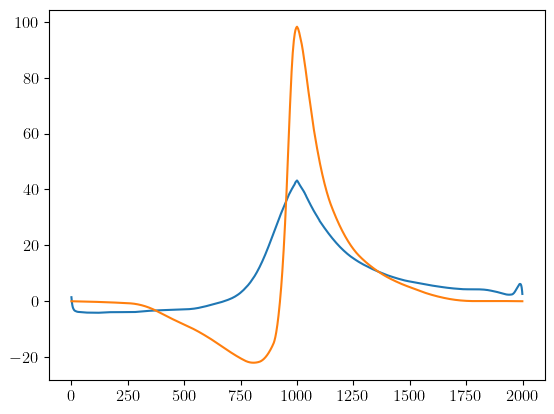

In [5]:
plt.plot(average_NR)
plt.plot(average_NS)

NR FWHM: 152.00
NS FWHM: 94.00


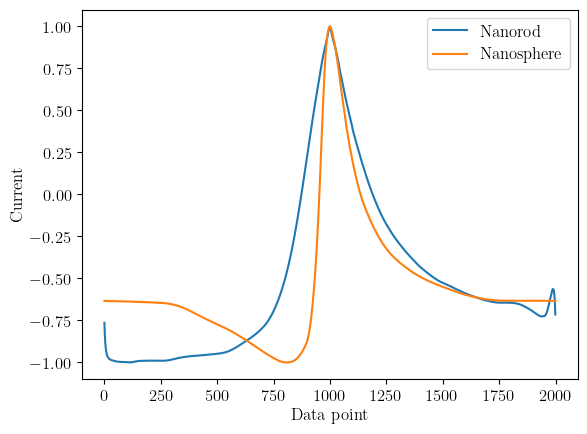

In [5]:
# average NR and NS events
average_NR = np.mean(DWT_rec_padded_NR, axis = 0)
average_NS = np.mean(DWT_rec_padded_NS, axis = 0)


scaler = MinMaxScaler(feature_range=(-1, 1))
average_NR_normalized = scaler.fit_transform(average_NR.reshape(-1, 1))
average_NS_normalized = scaler.fit_transform(average_NS.reshape(-1, 1)) 

NR_peak = np.argmax(average_NR_normalized)
NS_peak = np.argmax(average_NS_normalized)

x_data = np.arange(0, len(average_NR_normalized))
FWHM_NR = find_dwell_time_FWHM(x_data, average_NR_normalized.ravel(), "peak-only")
FWHM_NS = find_dwell_time_FWHM(x_data, average_NS_normalized.ravel(), "peak-only")

print(f"NR FWHM: {FWHM_NR:.2f}")
print(f"NS FWHM: {FWHM_NS:.2f}")

# average_NR_normalized_around_peak = average_NR_normalized[NR_peak-100:NR_peak+100]
# average_NS_normalized_around_peak = average_NS_normalized[NS_peak-200:NS_peak+200]

# x_data = np.arange(NR_peak-100,NR_peak+100)
# x_data_NS = np.arange(NS_peak-200,NS_peak+200)

# params_NR, cov_NR = curve_fit(gaussian, x_data, average_NR_normalized_around_peak.ravel(), p0=[1, NR_peak, 50])
# A_NR, mu_NR, sigma_NR = params_NR

# # Fit for Nanosphere
# params_NS, cov_NS = curve_fit(gaussian_custom, x_data_NS, average_NS_normalized_around_peak.ravel(), p0=[1, 10])
# A_NS, sigma_NS = params_NS

plt.plot(average_NR_normalized, label = "Nanorod")
plt.plot(average_NS_normalized, label = "Nanosphere")

#plt.plot(x_data, gaussian(x_data, *params_NR), label="Fit Nanorod", linestyle='--')
#plt.plot(x_data_NS, gaussian_custom(x_data_NS, *params_NS), label="Fit Nanosphere", linestyle='--')

# print(f"NR STD: {sigma_NR:.2f}")
# print(f"NS STD: {sigma_NS:.2f}")

plt.legend()
plt.ylabel("Current")
plt.xlabel("Data point")
plt.show()

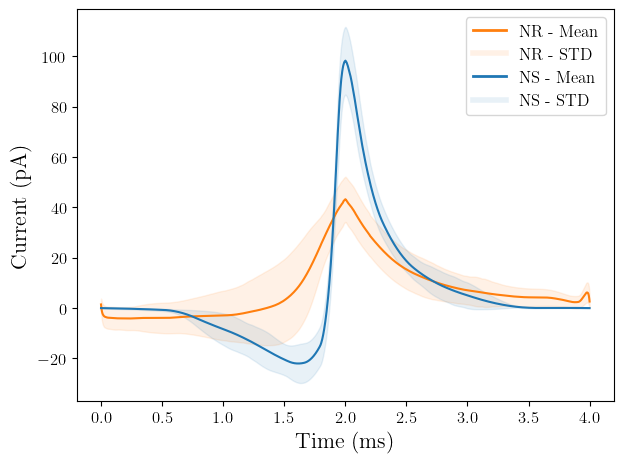

In [42]:

plt.plot(x_values, average_NR, label="Nanorod - Mean", color='tab:orange')
plt.fill_between(x_values, average_NR- std_NR, 
                 average_NR + std_NR, color='tab:orange', alpha=0.1)

plt.plot(x_values, average_NS, label="Nanosphere - Mean", color='tab:blue')
plt.fill_between(x_values, average_NS - std_NS, 
                 average_NS + std_NS, color='tab:blue', alpha=0.1)
custom_lines = [
    Line2D([0], [0], color='tab:orange', lw=2),  # For "5 nm - Mean"
    Line2D([0], [0], color='tab:orange', lw=4, alpha=0.1),  # For "5 nm - STD"
    Line2D([0], [0], color='tab:blue', lw=2),  # For "10 nm - Mean"
    Line2D([0], [0], color='tab:blue', lw=4, alpha=0.1)  # For "10 nm - STD"
]
plt.legend(custom_lines, ['NR - Mean', 'NR - STD', 'NS - Mean', 'NS - STD'])
plt.xlabel("Time (ms)", fontsize = 16)
plt.ylabel("Current (pA)", fontsize = 16)
plt.tight_layout()

#plt.savefig("/Users/joehart/Desktop/chemistry/Year 4/MSci project/Python_nanopores/MSci_python_images/NRNS_event_avg_nm_with_std.png", dpi=500)

plt.show()


In [41]:
2e-6 * 2000

0.004

NR FWHM: 0.30
NS FWHM: 0.19


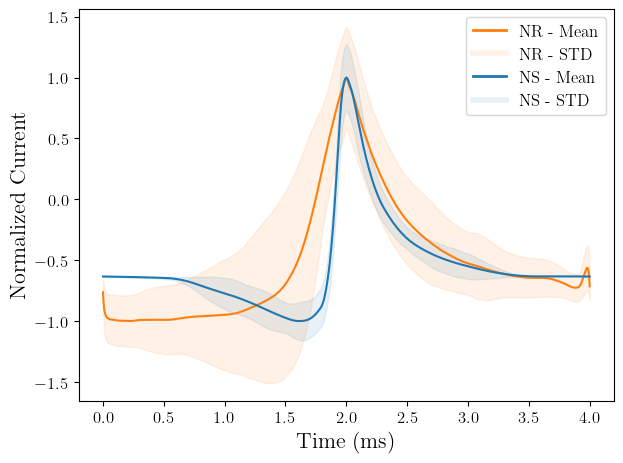

In [40]:
from matplotlib.lines import Line2D

x_values = np.linspace(0, len(average_NR)* 2e-6 * 1000, len(average_NR))


average_NR = np.mean(DWT_rec_padded_NR, axis=0)
average_NS = np.mean(DWT_rec_padded_NS, axis=0)
std_NR = np.std(DWT_rec_padded_NR, axis=0)
std_NS = np.std(DWT_rec_padded_NS, axis=0)

scaler = MinMaxScaler(feature_range=(-1, 1))
average_NR_normalized = scaler.fit_transform(average_NR.reshape(-1, 1)).ravel()
average_NS_normalized = scaler.fit_transform(average_NS.reshape(-1, 1)).ravel()
max_abs_NR = np.max(np.abs(average_NR))
max_abs_NS = np.max(np.abs(average_NS))
std_NR_normalized = (std_NR / max_abs_NR) * (np.max(average_NR_normalized) - np.min(average_NR_normalized))
std_NS_normalized = (std_NS / max_abs_NS) * (np.max(average_NS_normalized) - np.min(average_NS_normalized))

# Finding peaks and FWHM
NR_peak = np.argmax(average_NR_normalized)
NS_peak = np.argmax(average_NS_normalized)

FWHM_NR = find_dwell_time_FWHM(x_values, average_NR_normalized, "peak-only")
FWHM_NS = find_dwell_time_FWHM(x_values, average_NS_normalized, "peak-only")

print(f"NR FWHM: {FWHM_NR:.2f}")
print(f"NS FWHM: {FWHM_NS:.2f}")

# Plotting
plt.plot(x_values, average_NR_normalized, label="Nanorod - Mean", color='tab:orange')
plt.fill_between(x_values, average_NR_normalized - std_NR_normalized, 
                 average_NR_normalized + std_NR_normalized, color='tab:orange', alpha=0.1)

plt.plot(x_values, average_NS_normalized, label="Nanosphere - Mean", color='tab:blue')
plt.fill_between(x_values, average_NS_normalized - std_NS_normalized, 
                 average_NS_normalized + std_NS_normalized, color='tab:blue', alpha=0.1)

custom_lines = [
    Line2D([0], [0], color='tab:orange', lw=2),  # For "5 nm - Mean"
    Line2D([0], [0], color='tab:orange', lw=4, alpha=0.1),  # For "5 nm - STD"
    Line2D([0], [0], color='tab:blue', lw=2),  # For "10 nm - Mean"
    Line2D([0], [0], color='tab:blue', lw=4, alpha=0.1)  # For "10 nm - STD"
]
plt.legend(custom_lines, ['NR - Mean', 'NR - STD', 'NS - Mean', 'NS - STD'])

plt.xlabel("Time (ms)", fontsize = 16)
plt.ylabel("Normalized Current", fontsize = 16)
plt.tight_layout()
#plt.savefig("/Users/joehart/Desktop/chemistry/Year 4/MSci project/Python_nanopores/MSci_python_images/NRNS_event_avg_nm_with_std_norm.png", dpi=500)

plt.show()

NR FWHM: 0.30
NS FWHM: 0.19


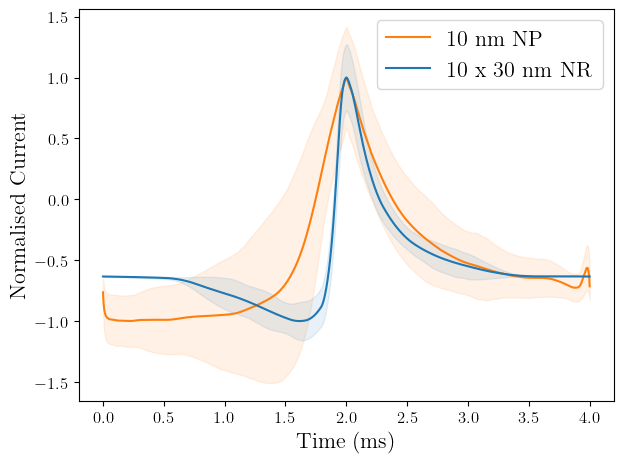

In [5]:
from matplotlib.lines import Line2D




average_NR = np.mean(DWT_rec_padded_NR, axis=0)
average_NS = np.mean(DWT_rec_padded_NS, axis=0)
std_NR = np.std(DWT_rec_padded_NR, axis=0)
std_NS = np.std(DWT_rec_padded_NS, axis=0)

x_values = np.linspace(0, len(average_NR)* 2e-6 * 1000, len(average_NR))

scaler = MinMaxScaler(feature_range=(-1, 1))
average_NR_normalized = scaler.fit_transform(average_NR.reshape(-1, 1)).ravel()
average_NS_normalized = scaler.fit_transform(average_NS.reshape(-1, 1)).ravel()
max_abs_NR = np.max(np.abs(average_NR))
max_abs_NS = np.max(np.abs(average_NS))
std_NR_normalized = (std_NR / max_abs_NR) * (np.max(average_NR_normalized) - np.min(average_NR_normalized))
std_NS_normalized = (std_NS / max_abs_NS) * (np.max(average_NS_normalized) - np.min(average_NS_normalized))

# Finding peaks and FWHM
NR_peak = np.argmax(average_NR_normalized)
NS_peak = np.argmax(average_NS_normalized)

FWHM_NR = find_dwell_time_FWHM(x_values, average_NR_normalized, "peak-only")
FWHM_NS = find_dwell_time_FWHM(x_values, average_NS_normalized, "peak-only")

print(f"NR FWHM: {FWHM_NR:.2f}")
print(f"NS FWHM: {FWHM_NS:.2f}")

# Plotting
plt.plot(x_values, average_NR_normalized, label="10 nm NP", color='tab:orange')
plt.fill_between(x_values, average_NR_normalized - std_NR_normalized, 
                 average_NR_normalized + std_NR_normalized, color='tab:orange', alpha=0.1)

plt.plot(x_values, average_NS_normalized, label="10 x 30 nm NR", color='tab:blue')
plt.fill_between(x_values, average_NS_normalized - std_NS_normalized, 
                 average_NS_normalized + std_NS_normalized, color='tab:blue', alpha=0.1)

custom_lines = [
    Line2D([0], [0], color='tab:orange', lw=2),  # For "5 nm - Mean"
    Line2D([0], [0], color='tab:orange', lw=4, alpha=0.1),  # For "5 nm - STD"
    Line2D([0], [0], color='tab:blue', lw=2),  # For "10 nm - Mean"
    Line2D([0], [0], color='tab:blue', lw=4, alpha=0.1)  # For "10 nm - STD"
]
plt.legend(fontsize = 16)

plt.xlabel("Time (ms)", fontsize = 16)
plt.ylabel("Normalised Current", fontsize = 16)
plt.tight_layout()
#plt.savefig("/Users/joehart/Desktop/chemistry/Year 4/MSci project/Python_nanopores/MSci_python_images/NRNS_event_avg_nm_with_std_norm.png", dpi=500)
plt.savefig("/Users/joehart/Desktop/1_Imperial/Year 4/MSci project/Python_nanopores/MSci_python_images/NRNS_event_avg_nm_with_std_norm.svg")


plt.show()

In [29]:
DWT_rec_padded_NR_norm = np.array([np.array(DWT_rec_padded_NR_norm[i]) for i in range(len(DWT_rec_padded_NR_norm))])
DWT_rec_padded_NS_norm = np.array([np.array(DWT_rec_padded_NS_norm[i]) for i in range(len(DWT_rec_padded_NS_norm))])


In [77]:
DWT_rec_padded_NR_norm[0]

array([-0.4482, -0.5402, -0.6041, ..., -0.1687, -0.2351, -0.3283])

In [78]:
shift_up(DWT_rec_padded_NR_norm)[0]

array([ 0.    , -0.092 , -0.1559, ...,  0.2795,  0.2131,  0.1199])

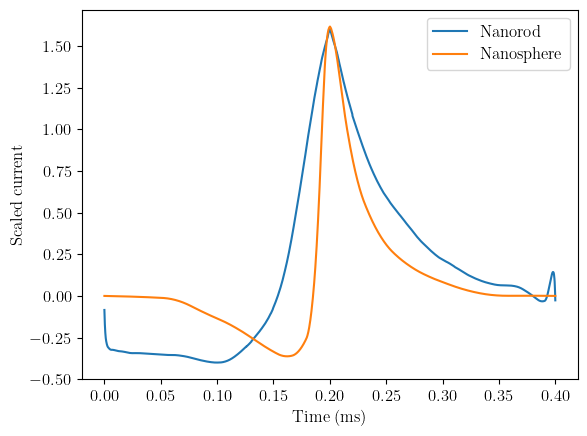

In [136]:
# average NR and NS events where they're scaled individually
average_NR = np.mean(DWT_rec_padded_NR_norm, axis = 0)
average_NS = np.mean(DWT_rec_padded_NS_norm, axis = 0)

scaler = MinMaxScaler(feature_range=(-1, 1))
centroids_normalized = scaler.fit_transform(cluster_centoids_avg_3.reshape(-1, 1))

plt.plot(np.linspace(0, 2000*2e-4, 2000),centroids_normalized +0.6, label = "Nanorod")

#plt.plot(np.linspace(0, 2000*2e-4, 2000), average_NR+0.07, label = "Nanorod")
plt.plot(np.linspace(0, 2000*2e-4, 2000), average_NS, label = "Nanosphere")
plt.legend()
plt.ylabel("Scaled current")
plt.xlabel("Time (ms)")
plt.show()

In [127]:
model_unscaled2 = unpickle("NR_TSKMeans_model_unscaled2.pkl")
labels_unscaled2 = unpickle("NR_TSKMeans_labels_unscaled2.pkl")
flattened_data_unscaled = unpickle("NR_TSKMeans_flattened_data_unscaled.pkl")

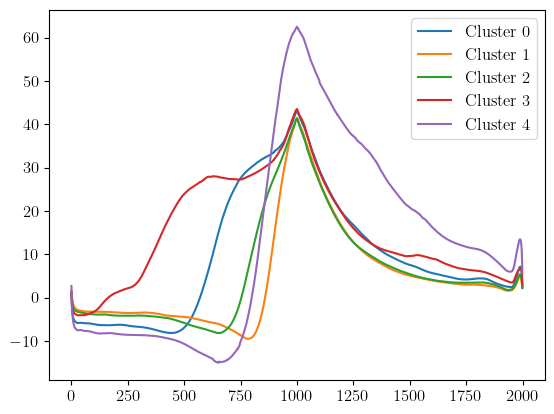

In [132]:
for i in range(5):
    plt.plot(model_unscaled2.cluster_centers_[i], label = f"Cluster {i}")
plt.legend()

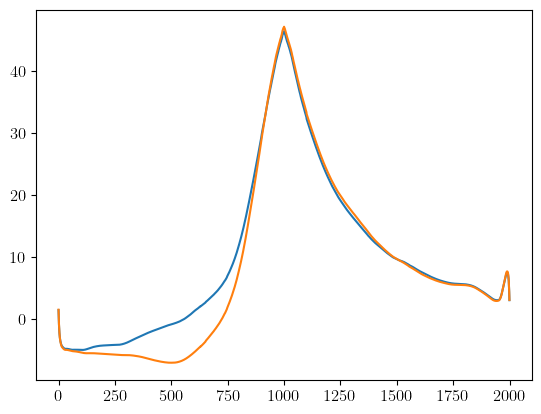

In [133]:
centroids_no3 = np.array([model_unscaled2.cluster_centers_[i] for i in range(5) if i != 3])
cluster_centoids_avg_3 = np.mean(centroids_no3, axis = 0)

cluster_centoids_avg = np.mean(model_unscaled2.cluster_centers_, axis = 0)

plt.plot(cluster_centoids_avg, label = "Average")
plt.plot(cluster_centoids_avg_3, label = "Average without cluster 3")

##### Mixed runs
- have data from start of notebook

In [104]:
data_mix_df

event_time  \
run_1  [[0.22688999999999998, 0.22689199999999998, 0....   
run_2  [[0.02838, 0.028381999999999998, 0.028384, 0.0...   

                                              event_data   smo  sd_threshold  \
run_1  [[-5.500474414058317, -5.378672656245726, -5.5...  None     61.260980   
run_2  [[-8.826536859126918, -8.827244866939395, -8.7...  None     55.931503   

       sd_threshold_lower  mean_noise  
run_1          -40.834404    0.003750  
run_2          -37.282557    0.003067

python(50513) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(50514) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(50515) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(50516) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(50517) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(50518) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(50519) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(50520) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(50521) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(50522) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(50523) Malloc

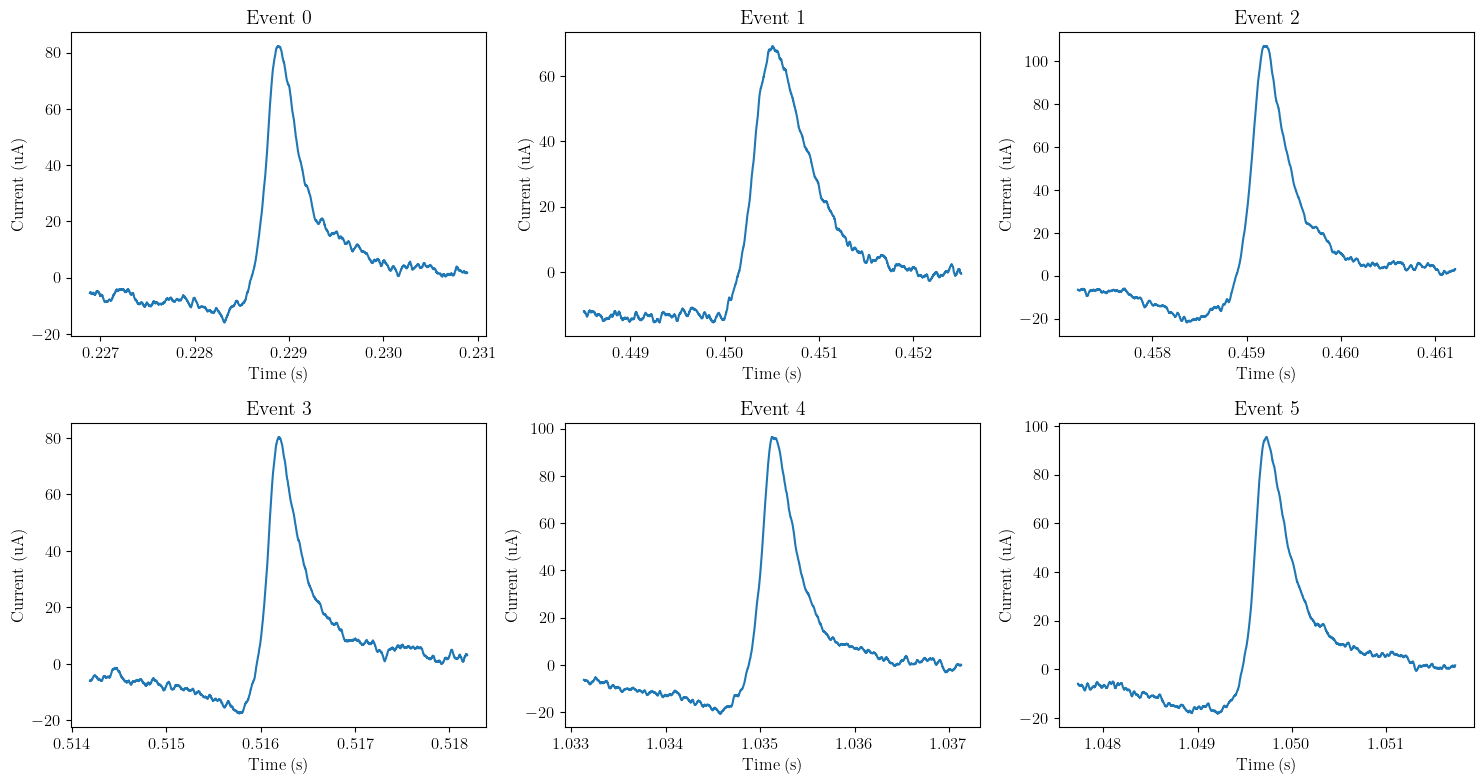

In [105]:
fig, axs = plt.subplots(2, 3, figsize=(15, 8))  # Adjust the size as needed

# Flatten the axs array for easy iteration
axs = axs.flatten()

for i, ax in zip(range(6), axs):
    ax.plot(data_mix_df["event_time"][0][i], data_mix_df["event_data"][0][i])
    #ax.plot(event_time_padded_test[i], DWT_rec_padded_test[i])
    ax.set_title(f"Event {i}")
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("Current (uA)")

plt.tight_layout()
plt.show()

In [139]:
data_mix_df = unpickle("data_mix_df.pkl")

In [140]:
results_mix_df = DWT_and_features_multi(data_mix_df, "NR", NRNS = True)


In [141]:
event_time_padded_mix = results_mix_df["event_time_padded"][0] + results_mix_df["event_time_padded"][1]
DWT_rec_padded_mix = results_mix_df["DWT_rec_padded"][0] + results_mix_df["DWT_rec_padded"][1]

features_list_mix = results_mix_df["features_list"][0] + results_mix_df["features_list"][1]


In [150]:
save_with_pickle("NRNS_event_time_padded_mix.pkl", event_time_padded_mix)
save_with_pickle("NRNS_DWT_rec_padded_mix.pkl", DWT_rec_padded_mix)

In [147]:
save_with_pickle("NRNS_features_list_mix.pkl", features_list_mix)

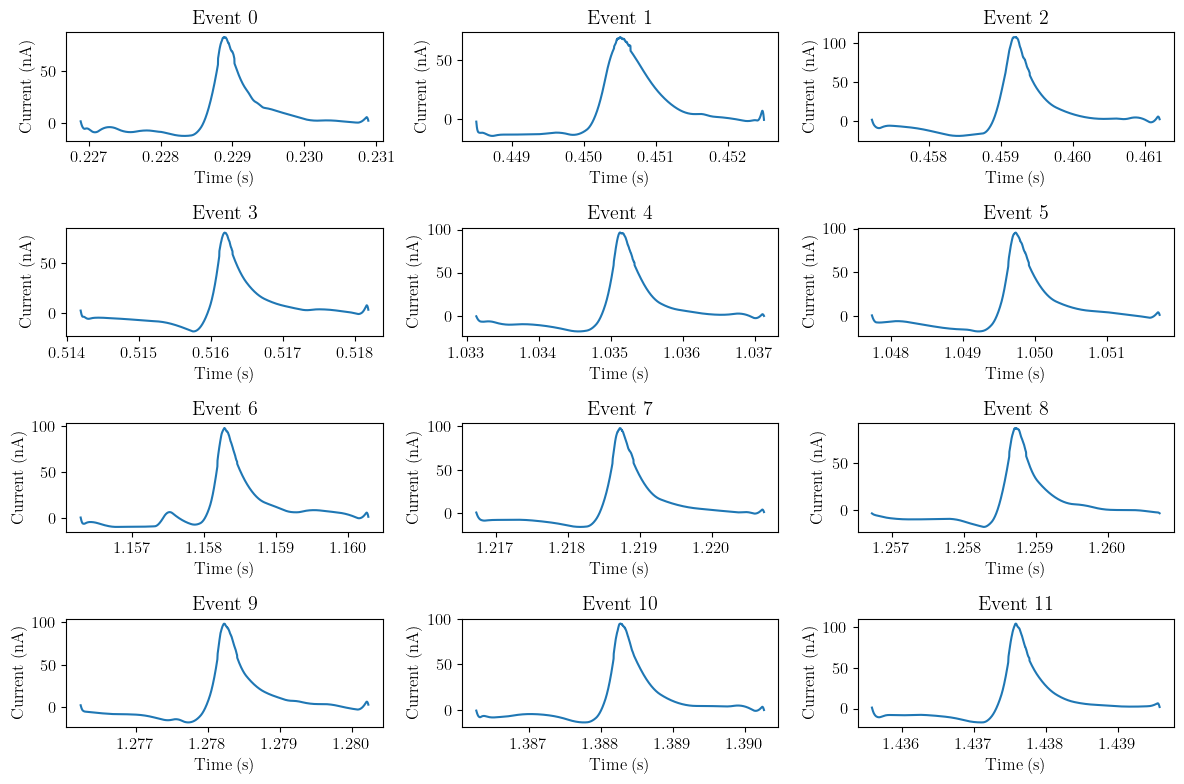

In [85]:
fig, axs = plt.subplots(4, 3, figsize=(12, 8))

# Flatten the axs array for easy iteration
axs = axs.flatten()

for i, ax in zip(range(12), axs):
    ax.plot(event_time_padded_mix[i], DWT_rec_padded_mix[i])

    ax.set_title(f"Event {i}")
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("Current (nA)")

plt.tight_layout()
plt.show()

##### Capture rate

In [238]:
times_between_event_NR = []
times_between_event_NR = time_between_multirun(event_time_padded_NR)
times_between_event_NR = np.array(times_between_event_NR)

In [239]:
times_between_event_NS = []
times_between_event_NS = time_between_multirun(event_time_padded_NS)
times_between_event_NS = np.array(times_between_event_NS)

In [240]:
times_between_event_mix = []
times_between_event_mix = time_between_multirun(event_time_padded_mix)
times_between_event_mix = np.array(times_between_event_mix)

In [156]:
print(times_between_event_mix[times_between_event_mix[i] <0])

[]


In [157]:
def model(t, r1, r2):
    return r1 * np.exp(-r2 * t)

In [158]:
max(times_between_event_mix)

1.615067999999999

In [159]:
max(times_between_event_NR), max(times_between_event_NS)

(2.2451480000000004, 0.5572740000014988)

In [162]:
len(times_between_event_NR), len(times_between_event_NS)

(285, 1425)

NR

[3.4652 0.1037]


python(7550) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


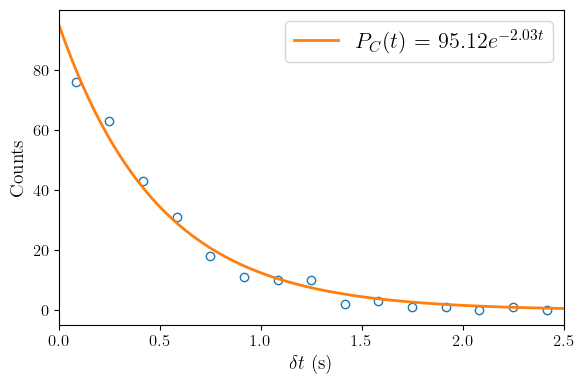

In [368]:
plt.figure(figsize=(6, 4))

no_bins = 15
counts, bin_edges = np.histogram(times_between_event_NR, bins=no_bins, range=(0, 2.5))
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
params_NR, cov_NR = curve_fit(model, bin_centers, counts, p0=[60, 0.3])
errors_NR = np.sqrt(np.diag(cov_NR))
print(errors_NR)


plt.plot(bin_centers, counts, color='tab:blue', linestyle="", marker='o', fillstyle='none', markeredgewidth=1)
plt.plot(np.linspace(0,20,1000), model(np.linspace(0,20,1000), *params_NR), color='tab:orange', linewidth=2, label=f'$P_C(t)$ = {params_NR[0]:.2f}$e^{{-{params_NR[1]:.2f}t}}$')
plt.xlim(0, 2.5)
plt.xlabel('$\delta t$ (s)', fontsize = 14)
plt.ylabel('Counts', fontsize = 14)
plt.legend(fontsize = 16)
plt.tight_layout()
#plt.savefig("MSci_python_images/NR_02_bior33_deltaTplot_2.png", dpi = 500)
plt.show()

[2.4929 0.1273]


python(7464) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(7465) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


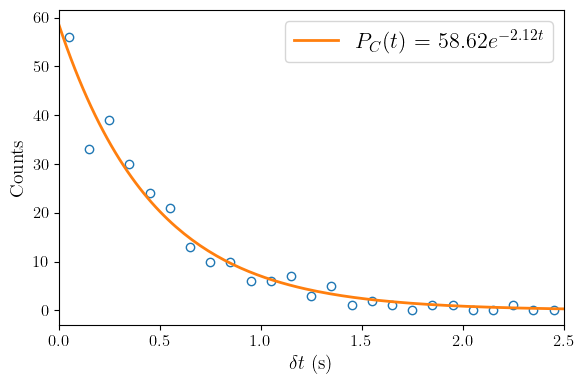

In [355]:
plt.figure(figsize=(6, 4))

no_bins = 25
counts, bin_edges = np.histogram(times_between_event_NR, bins=no_bins, range=(0, 2.5))
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
params_NR, cov_NR = curve_fit(model, bin_centers, counts, p0=[60, 0.3])
errors_NR = np.sqrt(np.diag(cov_NR))
print(errors_NR)


plt.plot(bin_centers, counts, color='tab:blue', linestyle="", marker='o', fillstyle='none', markeredgewidth=1)
plt.plot(np.linspace(0,20,1000), model(np.linspace(0,20,1000), *params_NR), color='tab:orange', linewidth=2, label=f'$P_C(t)$ = {params_NR[0]:.2f}$e^{{-{params_NR[1]:.2f}t}}$')
plt.xlim(0, 2.5)
plt.xlabel('$\delta t$ (s)', fontsize = 14)
plt.ylabel('Counts', fontsize = 14)
plt.legend(fontsize = 16)
plt.tight_layout()
#plt.savefig("MSci_python_images/NR_02_bior33_deltaTplot_2.png", dpi = 500)
plt.show()

NS

In [249]:
np.max(times_between_event_NS)

0.5572740000014988

In [251]:
counts

array([618, 357, 167, ...,   0,   0,   0])

[17.0678  0.2428]


python(7543) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(7544) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


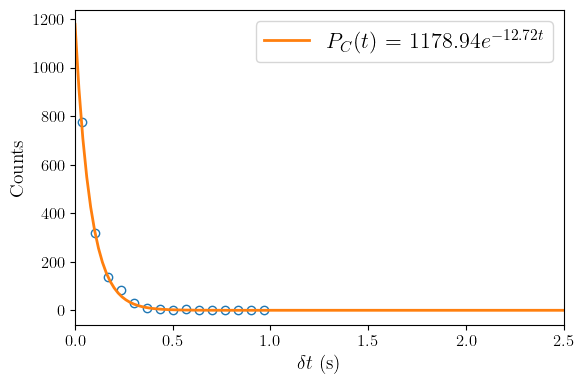

In [367]:
plt.figure(figsize=(6, 4))

no_bins = 15
counts, bin_edges = np.histogram(times_between_event_NS, bins=no_bins, range=(0, 1))
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
params_NS, cov_NS = curve_fit(model, bin_centers, counts, p0=[60, 0.3])
errors_NS = np.sqrt(np.diag(cov_NS))
print(errors_NS)

plt.plot(bin_centers, counts, color='tab:blue', linestyle="", marker='o', fillstyle='none', markeredgewidth=1)
plt.plot(np.linspace(0,20,1000), model(np.linspace(0,20,1000), *params_NS), color='tab:orange', linewidth=2, label=f'$P_C(t)$ = {params_NS[0]:.2f}$e^{{-{params_NS[1]:.2f}t}}$')
plt.xlim(0, 2.5)
plt.xlabel('$\delta t$ (s)', fontsize = 14)
plt.ylabel('Counts', fontsize = 14)
plt.legend(fontsize = 16)
plt.tight_layout()
#plt.savefig("MSci_python_images/NS_02_bior33_deltaTplot_2.png", dpi = 500)
plt.show()

[13.302   0.2621]


python(7508) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


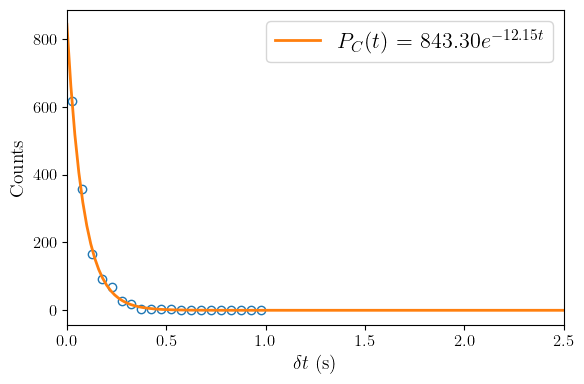

In [362]:
plt.figure(figsize=(6, 4))

no_bins = 20
counts, bin_edges = np.histogram(times_between_event_NS, bins=no_bins, range=(0, 1))
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
params_NS, cov_NS = curve_fit(model, bin_centers, counts, p0=[60, 0.3])
errors_NS = np.sqrt(np.diag(cov_NS))
print(errors_NS)

plt.plot(bin_centers, counts, color='tab:blue', linestyle="", marker='o', fillstyle='none', markeredgewidth=1)
plt.plot(np.linspace(0,20,1000), model(np.linspace(0,20,1000), *params_NS), color='tab:orange', linewidth=2, label=f'$P_C(t)$ = {params_NS[0]:.2f}$e^{{-{params_NS[1]:.2f}t}}$')
plt.xlim(0, 2.5)
plt.xlabel('$\delta t$ (s)', fontsize = 14)
plt.ylabel('Counts', fontsize = 14)
plt.legend(fontsize = 16)
plt.tight_layout()
#plt.savefig("MSci_python_images/NS_02_bior33_deltaTplot_2.png", dpi = 500)
plt.show()


In [108]:
len(times_between_event_NS), len(times_between_event_NR)

(1425, 285)

In [375]:
params_NR[1], errors_NR[1], params_NS[1], errors_NS[1]

(2.031302352617924,
 0.10374825620637952,
 12.719880928500718,
 0.2427697367504954)

In [366]:
ratio_NRNS = params_NS[1] / params_NR[1]

error_ratio_labels_NRNS = ratio_NRNS * ((errors_NS[1] / params_NS[1]) ** 2 + (errors_NR[1] / params_NR[1]) ** 2) ** 0.5

print(f"error in 5/10 nm ratio: {ratio_NRNS} $\pm$ {error_ratio_labels_NRNS}")

error in 5/10 nm ratio: 6.261933833782771 $\pm$ 0.34142757483056374


Mixture

In [177]:
scaler = RobustScaler()
features_mixed_scaled = scaler.fit_transform(features_list_mix)


In [178]:
from joblib import load

best_model_XG_random_02_bior33_NRNS = load('best_model_XG_random_02_bior33_NRNS.pkl')

In [179]:
predictions_02_bior33_NRNS = best_model_XG_random_02_bior33_NRNS.predict(features_list_mix)
len(predictions_02_bior33_NRNS[predictions_02_bior33_NRNS == 0]), len(predictions_02_bior33_NRNS[predictions_02_bior33_NRNS == 1])

(598, 87)

In [180]:
DWT_rec_02_bior33_NRNS_labels_0 = [DWT_rec_padded_mix[i] for i, label in enumerate(predictions_02_bior33_NRNS) if label == 0]
DWT_rec_02_bior33_NRNS_labels_1 = [DWT_rec_padded_mix[i] for i, label in enumerate(predictions_02_bior33_NRNS) if label == 1]
time_02_bior33_NRNS_labels_0 = [event_time_padded_mix[i] for i, label in enumerate(predictions_02_bior33_NRNS) if label == 0]
time_02_bior33_NRNS_labels_1 = [event_time_padded_mix[i] for i, label in enumerate(predictions_02_bior33_NRNS) if label == 1]


In [243]:
time_between_02_bior33_NRNS_label_0 = time_between_multirun(time_02_bior33_NRNS_labels_0)
time_between_02_bior33_NRNS_label_1 = time_between_multirun(time_02_bior33_NRNS_labels_1)

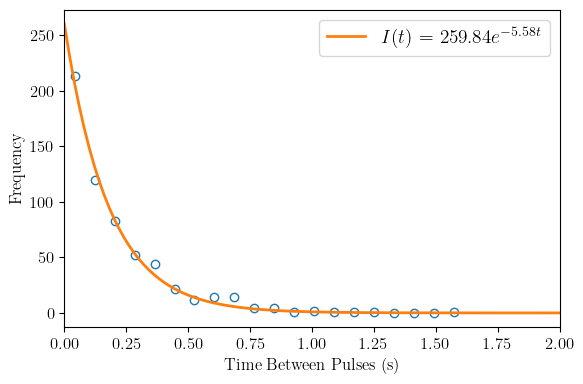

errors label 0 [6.6997 0.1989]


In [296]:
# Data for label 0
plt.figure(figsize=(6, 4))
no_bins = 20
counts, bin_edges = np.histogram(time_between_02_bior33_NRNS_label_0, bins=no_bins)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
params_0, cov_0 = curve_fit(model, bin_centers, counts, p0=[60, 0.3])

# Plot for label 0
plt.plot(bin_centers, counts, color='tab:blue', linestyle="", marker='o', fillstyle='none', markeredgewidth=1)
plt.plot(np.linspace(0,20,1000), model(np.linspace(0,20,1000), *params_0), color='tab:orange', linewidth=2, label=f'$I(t)$ = {params_0[0]:.2f}$e^{{-{params_0[1]:.2f}t}}$')
plt.xlim(0, 2)
plt.xlabel('Time Between Pulses (s)')
plt.ylabel('Frequency')
plt.legend(fontsize = 14)
plt.tight_layout()
#plt.savefig("MSci_python_images/NRNS_02_bior33_deltaTplot_label_0.png", dpi = 300)
plt.show()

errors_label_0 = np.sqrt(np.diag(cov_0))
print("errors label 0", errors_label_0)

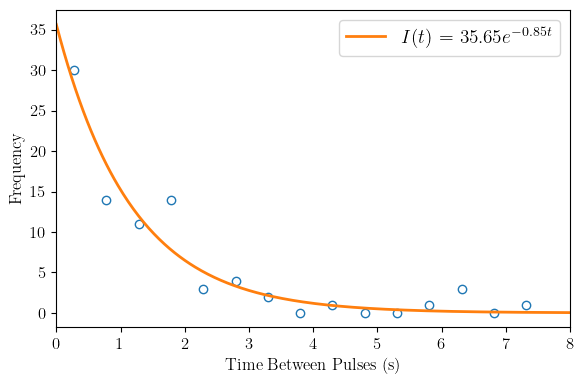

errors label 1 [3.5853 0.1162]


In [293]:
# Data for label 1
plt.figure(figsize=(6, 4))
no_bins = 15
counts, bin_edges = np.histogram(time_between_02_bior33_NRNS_label_1, bins=no_bins)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
params_1, cov_1 = curve_fit(model, bin_centers, counts, p0=[60, 0.3])

# Plot for label 1
plt.plot(bin_centers, counts, color='tab:blue', linestyle="", marker='o', fillstyle='none', markeredgewidth=1)
plt.plot(np.linspace(0,20,1000), model(np.linspace(0,20,1000), *params_1), color='tab:orange', linewidth=2, label=f'$I(t)$ = {params_1[0]:.2f}$e^{{-{params_1[1]:.2f}t}}$')
plt.xlim(0, 8)
plt.xlabel('Time Between Pulses (s)')
plt.ylabel('Frequency')
plt.legend(fontsize = 14)
plt.tight_layout()
#plt.savefig("MSci_python_images/NRNS_02_bior33_deltaTplot_label_1.png", dpi = 300)
plt.show()

errors_label_1 = np.sqrt(np.diag(cov_1))
print("errors label 1", errors_label_1)

In [365]:
ratio_0_1 = params_0[1] / params_1[1]
error_ratio_labels_0_1 = ratio_0_1 * ((errors_label_0[1] / params_0[1]) ** 2 + (errors_label_1[1] / params_1[1]) ** 2) ** 0.5

print(f"error in 5/10 nm ratio: {ratio_0_1} $\pm$ {error_ratio_labels_0_1}")

error in 5/10 nm ratio: 6.555982727500589 $\pm$ 0.9259073400907085


##### Welch's t-test

In [227]:
for i in range(5):
    print(len(subsets_test[i]))

57
57
57
57
57


In [376]:
def plot_many_capturerates(times_between_event, no_splits, no_bins, x_lim, range_bins = None, filename = None):
    fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(18, 7))
    #fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(16, 3.5))
    axes = axes.flatten() 

    np.random.seed(42)
    np.random.shuffle(times_between_event)

    subset_size = len(times_between_event) // no_splits
    subsets = [times_between_event[i*subset_size:(i+1)*subset_size] for i in range(no_splits)]

    capture_rate_many = []
    capture_rate_many_errors = []


    for i in range(no_splits):
        if range_bins is not None:
            counts, bin_edges = np.histogram(subsets[i], bins=no_bins, range=(0,range_bins))
        else:
            counts, bin_edges = np.histogram(subsets[i], bins=no_bins)
        bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
        params_sub, cov_sub = curve_fit(model, bin_centers, counts, p0=[60, 0.3])
        capture_rate_many.append(params_sub[1])
        capture_rate_many_errors.append(np.sqrt(np.diag(cov_sub))[1])
        
        axes[i].plot(bin_centers, counts, color='tab:blue', linestyle="", marker='o', fillstyle='none', markeredgewidth=1)
        axes[i].plot(np.linspace(0,20,1000), model(np.linspace(0,20,1000), *params_sub), color='tab:orange', linewidth=2, label=f'$P_C(t)$ = {params_sub[0]:.2f}$e^{{-{params_sub[1]:.2f}t}}$')
        axes[i].set_xlim(x_lim[0], x_lim[1])
        axes[i].legend(fontsize = 14)
        
        if i in [0, 5]:
            axes[i].set_ylabel("Counts",  fontsize = 14)
        if i in [5, 6, 7, 8, 9]:
            axes[i].set_xlabel('$\delta t$ (s)', fontsize = 14)

    plt.tight_layout()
    if filename is not None:
        plt.savefig(f"MSci_python_images/{filename}.png", dpi=500)
    plt.show()
    
    return capture_rate_many, capture_rate_many_errors

python(7914) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(7915) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(7916) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(7917) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(7918) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(7919) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(7920) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(7921) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(7922) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(7923) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(7924) MallocStackLoggin

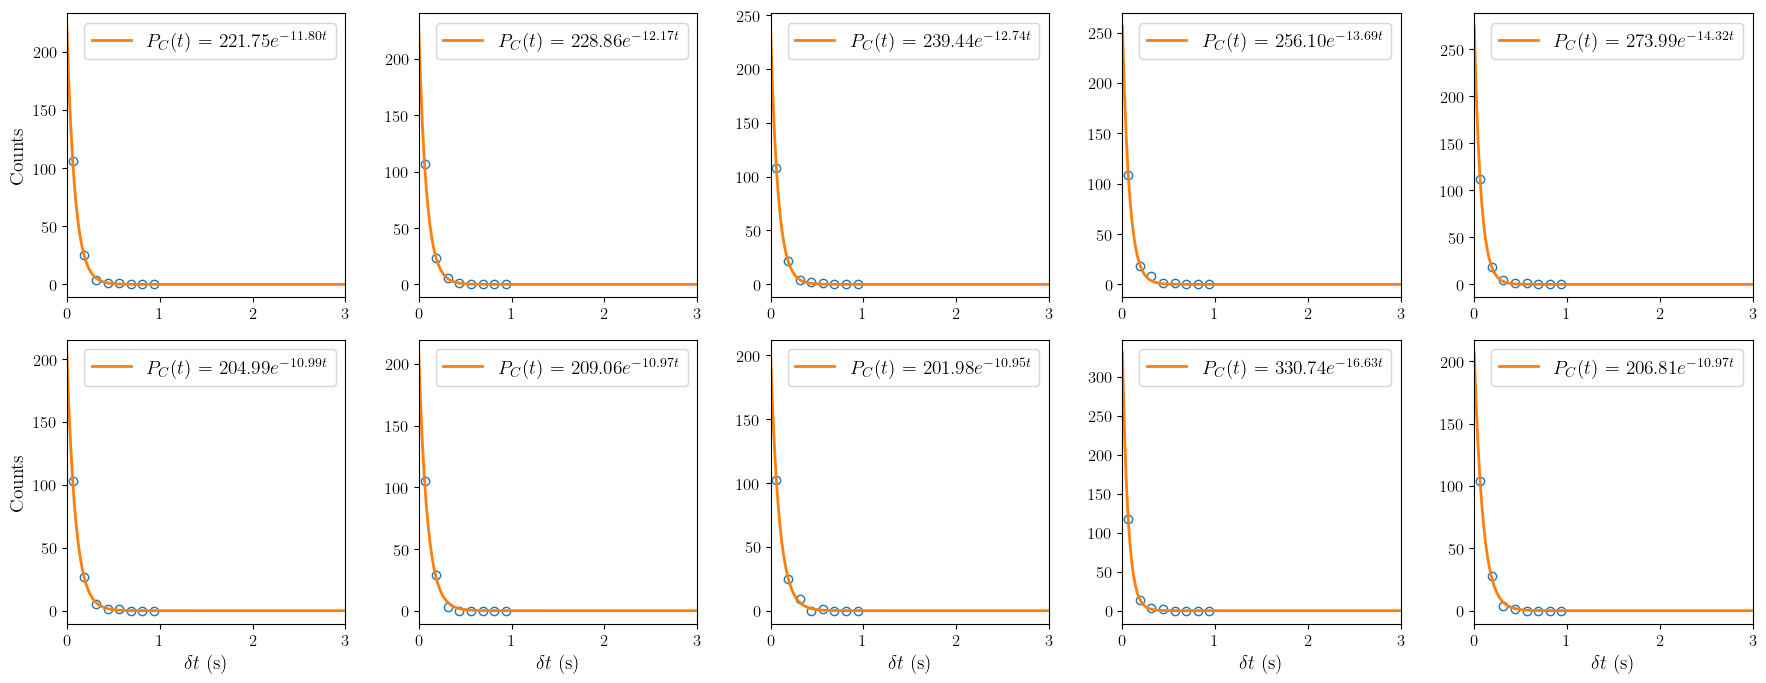

In [377]:
#capture_rate_NS_many, capture_rate_NS_many_errors = plot_many_capturerates(times_between_event_NS, 10,8, range_bins=1, x_lim=[0,3], filename="NS_02_bior33_deltaTplot_many_range3")
capture_rate_NS_many, capture_rate_NS_many_errors = plot_many_capturerates(times_between_event_NS, 10, 8, range_bins=1, x_lim=[0,3])


python(7948) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(7949) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(7950) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(7951) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(7952) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(7953) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(7954) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(7955) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(7956) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(7957) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(7958) MallocStackLoggin

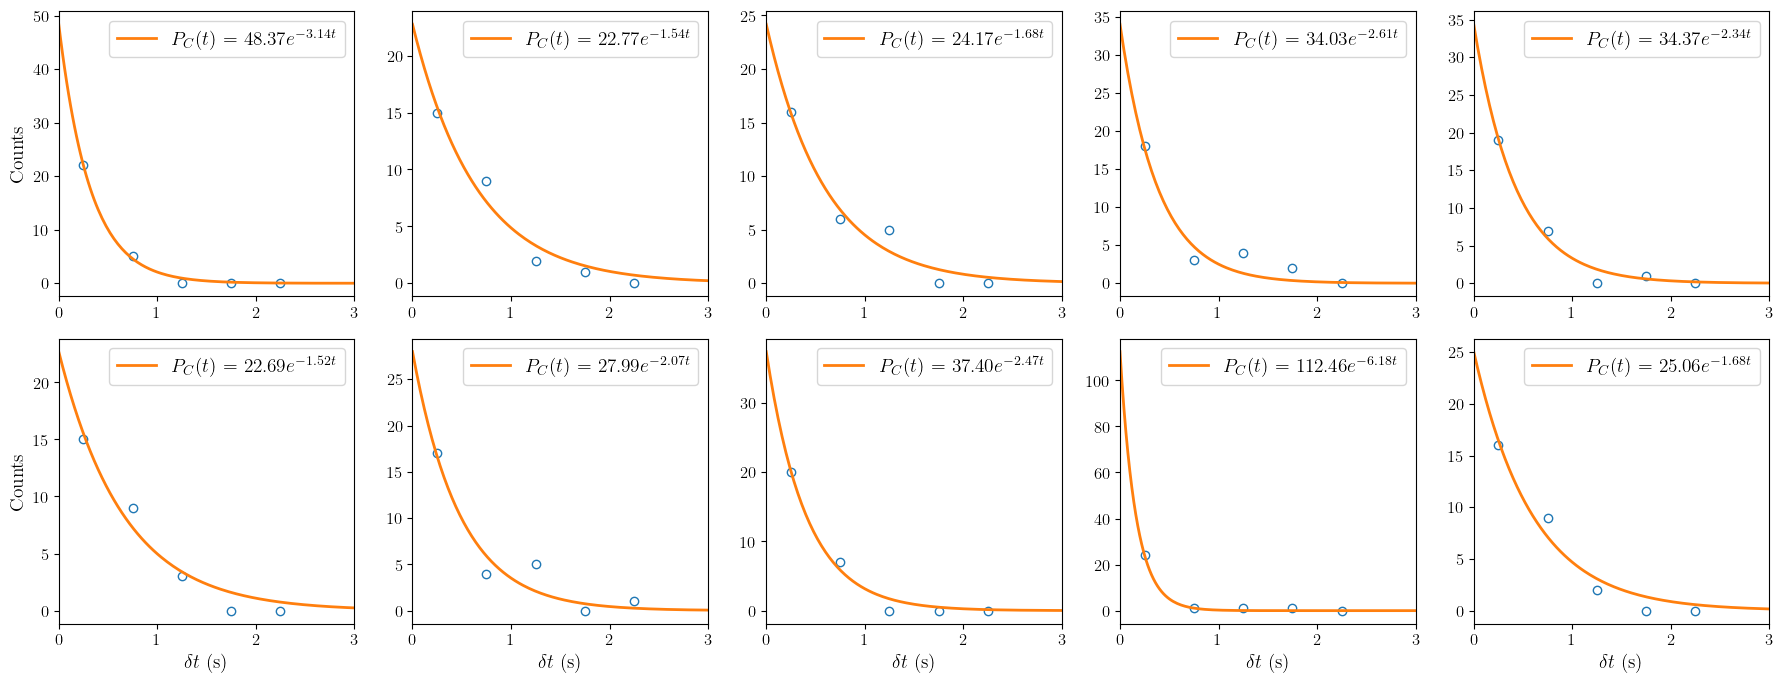

In [378]:
#capture_rate_NR_many, capture_rate_NR_many_errors = plot_many_capturerates(times_between_event_NR, 10, 5, range_bins=2.5 , x_lim=[0,3], filename="NR_02_bior33_deltaTplot_many")
capture_rate_NR_many, capture_rate_NR_many_errors = plot_many_capturerates(times_between_event_NR, 10, 5, range_bins=2.5 , x_lim=[0,3])

In [274]:
capture_rate_NR_many, capture_rate_NR_many_errors = np.array(capture_rate_NR_many), np.array(capture_rate_NR_many_errors)
capture_rate_NS_many, capture_rate_NS_many_errors = np.array(capture_rate_NS_many), np.array(capture_rate_NS_many_errors)

capture_rate_NR_many_errors = capture_rate_NR_many_errors[capture_rate_NR_many>1]
capture_rate_NR_many = capture_rate_NR_many[capture_rate_NR_many>1]

capture_rate_NS_many_errors = capture_rate_NS_many_errors[capture_rate_NS_many>1]
capture_rate_NS_many = capture_rate_NS_many[capture_rate_NS_many>1]

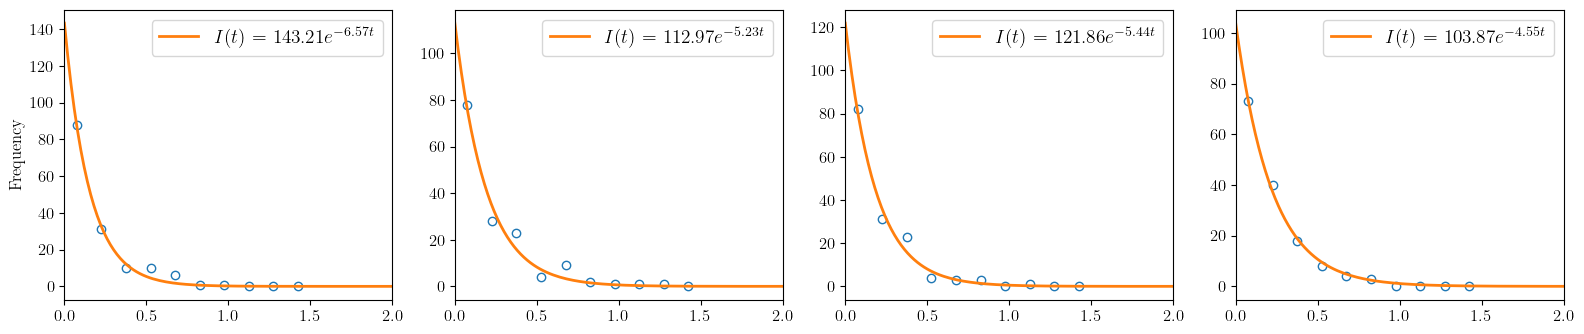

In [321]:
capture_rate_label_0_many, capture_rate_label_0_many_errors = plot_many_capturerates(time_between_02_bior33_NRNS_label_0, 4, 10, range_bins=1.5 , x_lim=[0,2])

In [162]:
len(time_between_02_bior33_NRNS_label_0), len(time_between_02_bior33_NRNS_label_1)

(589, 84)

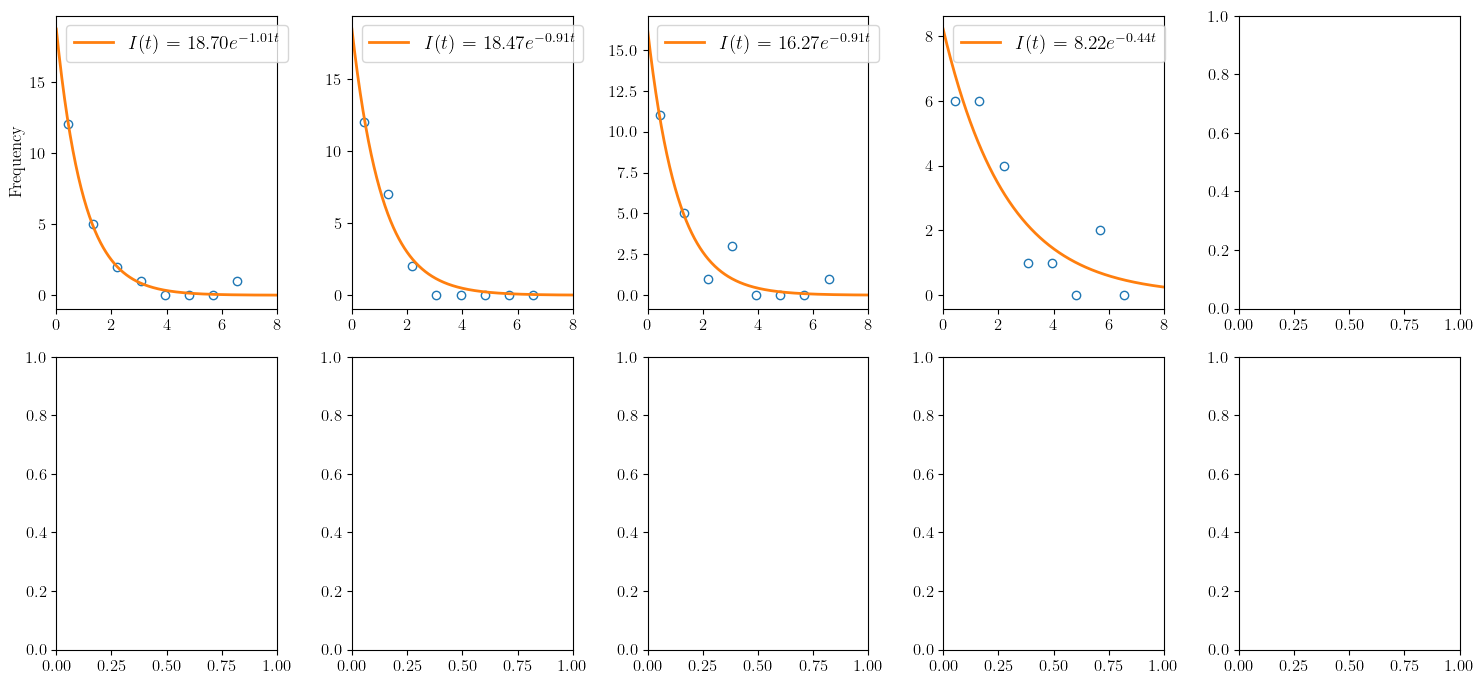

In [279]:
capture_rate_label_1_many, capture_rate_label_1_many_errors = plot_many_capturerates(time_between_02_bior33_NRNS_label_1, 4, 8, range_bins=7 ,x_lim=[0,8])

In [327]:
ratio_many_NRNS = np.array(capture_rate_NS_many) / np.array(capture_rate_NR_many)

In [328]:
ratio_many_NRNS_errors = ratio_many_NRNS * np.sqrt((np.array(capture_rate_NS_many_errors) / np.array(capture_rate_NS_many))**2 + (np.array(capture_rate_NS_many_errors) / np.array(capture_rate_NR_many))**2)

In [329]:
ratio_many_0_1 = np.array(capture_rate_label_0_many) / np.array(capture_rate_label_1_many)

In [330]:
ratio_many_0_1_errors = ratio_many_0_1 * np.sqrt((np.array(capture_rate_label_0_many_errors) / np.array(capture_rate_label_0_many))**2 + (np.array(capture_rate_label_1_many_errors) / np.array(capture_rate_label_1_many))**2)

In [331]:
ratio_many_NRNS, ratio_many_0_1

(array([5.9759, 7.6755, 6.5034, ..., 3.8625, 5.7278, 4.8423]),
 array([ 6.4965,  5.7432,  5.9917, 10.4301]))

In [332]:
save_with_pickle("NRNS_ttest_ratio_many.pkl", ratio_many_NRNS)

In [333]:
t_stat, p_value = stats.ttest_ind(ratio_many_NRNS, ratio_many_0_1, equal_var=False)

print(f"Welch's T-statistic: {t_stat}")
print(f"P-value: {p_value}")

Welch's T-statistic: -1.065538894383414
P-value: 0.34601034443722584


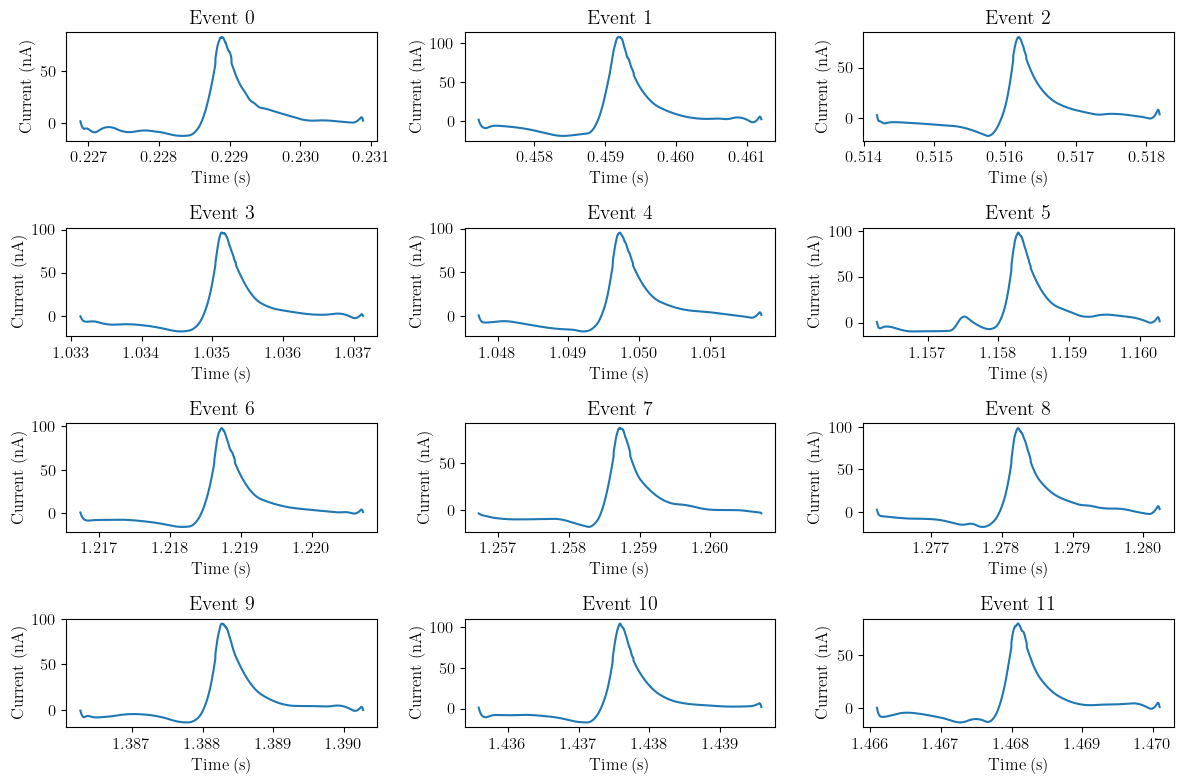

In [212]:
fig, axs = plt.subplots(4, 3, figsize=(12, 8))

# Flatten the axs array for easy iteration
axs = axs.flatten()

for i, ax in zip(range(12), axs):
    ax.plot(time_02_bior33_NRNS_labels_0[i], DWT_rec_02_bior33_NRNS_labels_0[i])

    ax.set_title(f"Event {i}")
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("Current (nA)")

plt.tight_layout()
plt.show()

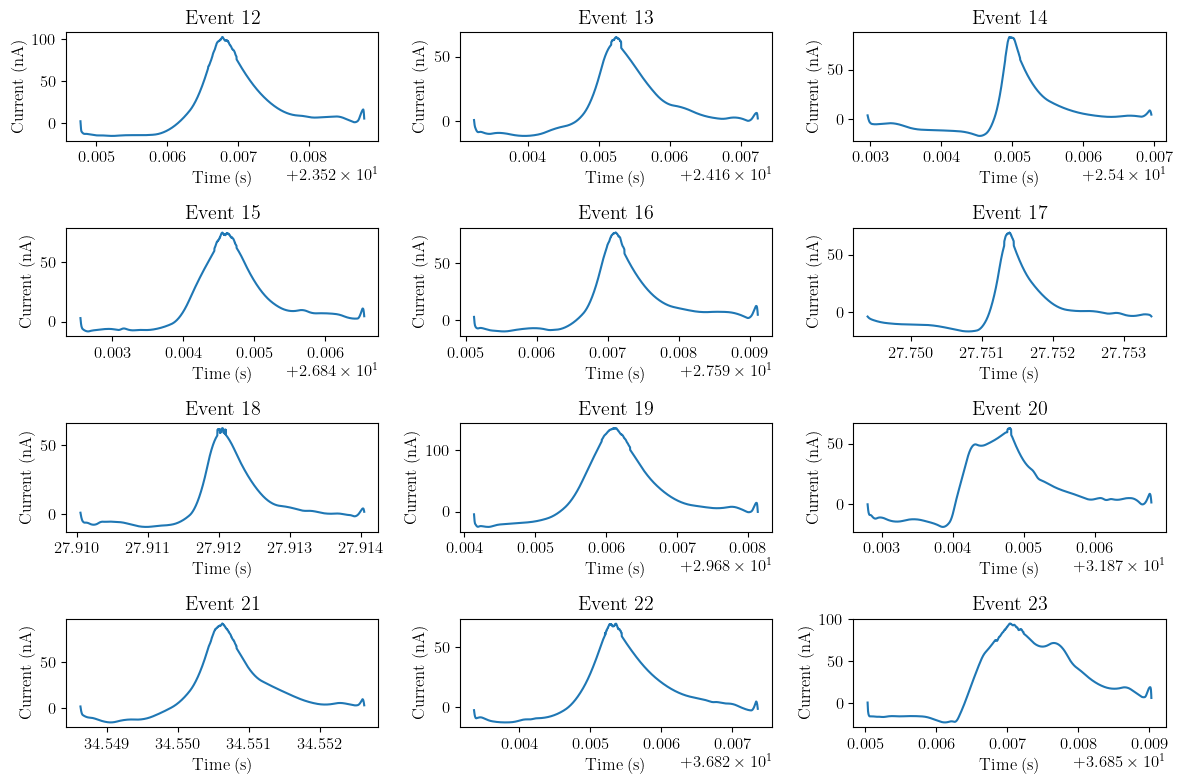

In [213]:
fig, axs = plt.subplots(4, 3, figsize=(12, 8))

# Flatten the axs array for easy iteration
axs = axs.flatten()

for i, ax in zip(range(12,24), axs):
    ax.plot(time_02_bior33_NRNS_labels_1[i], DWT_rec_02_bior33_NRNS_labels_1[i])

    ax.set_title(f"Event {i}")
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("Current (nA)")

plt.tight_layout()
plt.show()

python(51781) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(51782) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


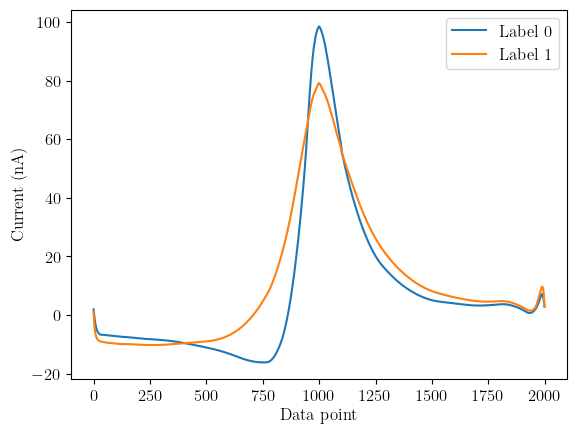

In [215]:
average_profile_label_0 = np.mean(DWT_rec_02_bior33_NRNS_labels_0, axis=0)
average_profile_label_1 = np.mean(DWT_rec_02_bior33_NRNS_labels_1, axis=0)

plt.plot(average_profile_label_0, label = "Label 0")
plt.plot(average_profile_label_1, label = "Label 1")
plt.ylabel("Current (nA)")
plt.xlabel("Data point")
plt.legend()
plt.show()

# NR has less resisgive peak (caused by PEG), backs up further that
# not fully coated with PEG

### Clustering

##### Clustering on NR events

In [213]:
features_list_NR = unpickle("features_list_NR.pkl")

In [200]:
from sklearn.cluster import AgglomerativeClustering

Silhouette Score for 2 clusters: 0.41408381213175044
Cluster centroids:
 [[-0.4395 -0.0413 -0.0411  0.0158 -0.0033]
 [ 1.465   0.1375  0.1371 -0.0528  0.0109]]


/Users/joehart/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


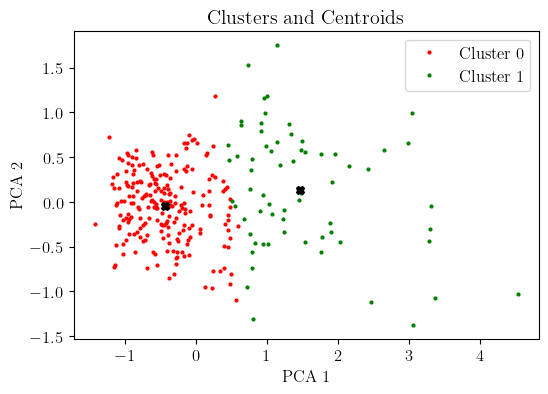

In [206]:
#scaler = StandardScaler()
scaler = MinMaxScaler((-1,1))
#scaler = RobustScaler()

X_scaled = scaler.fit_transform(features_list_NR)

pca = PCA(n_components=5)
X_pca = pca.fit_transform(X_scaled)

n_clusters = 2

kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans.fit(X_pca)

silhouette_avg = silhouette_score(X_scaled, kmeans.labels_)
print(f"Silhouette Score for {n_clusters} clusters: {silhouette_avg}")
centroids = kmeans.cluster_centers_
# You can also examine the cluster centroids
print("Cluster centroids:\n", centroids)

# Assigning labels to your original dataset if needed
labels_kmeans = kmeans.labels_

plt.figure(figsize=(6, 4))
colors = ['r', 'g', 'b', 'y', 'c', 'm']  # Add more colors if you have more clusters

# Plot each cluster
for i in range(centroids.shape[0]):
    # Select only data points with the cluster label == i
    ds = X_pca[np.where(labels_kmeans == i)]
    # Plot the data points
    plt.plot(ds[:, 0], ds[:, 1], 'o', markersize=2, color=colors[i], label=f'Cluster {i}')
    # Plot the centroid
    plt.plot(centroids[i][0], centroids[i][1], 'kX', markersize=5, markeredgewidth=2)

plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title('Clusters and Centroids')
plt.legend()
plt.show()

/Users/joehart/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/joehart/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/joehart/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/joehart/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init

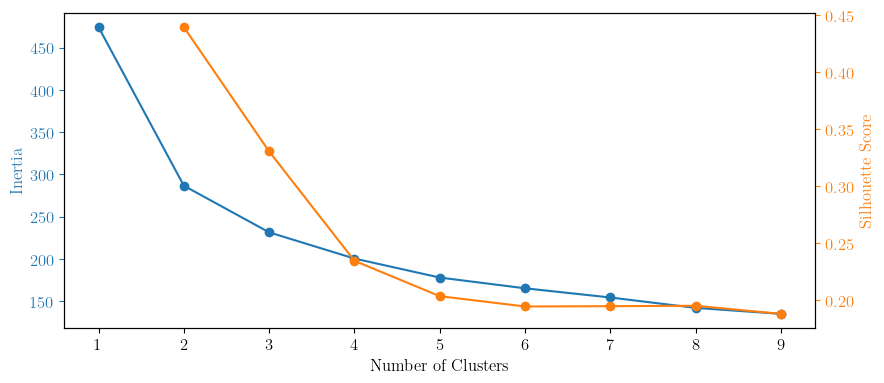

In [205]:
num_clusters_range = range(1, 10)
inertia = []
silhouette_scores = []

for k in num_clusters_range:
    model = KMeans(n_clusters=k, random_state=42)
    labels_k = model.fit_predict(X_pca)

    centroids_k = model.cluster_centers_
    
    

    if k == 1:
        silhouette_scores.append(None)
    else:
        silhouette_avg_agglo = silhouette_score(X_pca, labels_k)
        silhouette_scores.append(silhouette_avg_agglo)
    inertia.append(model.inertia_)
    
fig, ax1 = plt.subplots(figsize=(9, 4))

ax1.plot(num_clusters_range, inertia, color='#1f77b4', marker='o', label='WCSS')
ax1.set_xlabel('Number of Clusters')
ax1.set_ylabel('Inertia', color='#1f77b4')
ax1.tick_params('y', colors='#1f77b4')
ax1.set_xticks(num_clusters_range)

ax2 = ax1.twinx()
ax2.plot(num_clusters_range, silhouette_scores, color='#ff7f0e', marker='o', label='Silhouette Score')
ax2.set_ylabel('Silhouette Score', color='#ff7f0e')
ax2.tick_params('y', colors="#ff7f0e")

plt.tight_layout()
#plt.savefig("MSci_python_images/DNA_agglo_clustering_bior22_elbow.png", dpi=300)
plt.show()

In [22]:
%matplotlib inline
%matplotlib qt

In [20]:
from sklearn.preprocessing import MaxAbsScaler

In [23]:
from mpl_toolkits.mplot3d import Axes3D

#scaler = StandardScaler()
#scaler = MinMaxScaler((-1,1))
#scaler = MaxAbsScaler()
scaler = RobustScaler()
X_scaled = scaler.fit_transform(features_list_NR)

# Assuming X_pca is your dataset reduced to 3 dimensions
pca = PCA(n_components=3)
X_pca_3d = pca.fit_transform(X_scaled)

# Applying KMeans clustering
kmeans = KMeans(n_clusters=3)
kmeans.fit(X_pca_3d)

# Cluster centers
centroids = kmeans.cluster_centers_

# Cluster labels
labels = kmeans.labels_

# Plotting
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

colors = ['r', 'g', 'b', 'y', 'c', 'm']  # Adjust as needed

for i in range(centroids.shape[0]):
    ds = X_pca_3d[np.where(labels_kmeans == i)]
    ax.scatter(ds[:, 0], ds[:, 1], ds[:, 2], s=20, color=colors[i], label=f'Cluster {i}')
    ax.scatter(centroids[i][0], centroids[i][1], centroids[i][2], s=100, color='k', marker='X')

ax.set_xlabel('PCA 1')
ax.set_ylabel('PCA 2')
ax.set_zlabel('PCA 3')
ax.set_title('3D Clusters and Centroids')
ax.legend()
plt.show()


/Users/joehart/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [231]:
len(features_list_NR[0])

25

In [229]:
len(centriods[0])

25

##### KMeans: use elbow method to determine number of clusters?

scaler = TimeSeriesScalerMeanVariance(): $$x_i' = \frac{x_i-\mu}\sigma$$

DWT_rec_padded_NRNS = NR + NS

In [301]:
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from sklearn.preprocessing import MinMaxScaler

# Assuming time_series_data is your dataset, a list or array of time series
scaler = TimeSeriesScalerMeanVariance()
scaled_time_series_data = scaler.fit_transform(np.array(DWT_rec_padded_NRNS))

In [302]:
# DTW
n_clusters = 2

model = TimeSeriesKMeans(n_clusters=n_clusters, metric="dtw", max_iter=5, n_jobs=-1)

# Fit the model to your data
clusters = model.fit_predict(scaled_time_series_data)

In [366]:
# save model
save_with_pickle("model_dtw_1.pkl", model)

In [303]:
# soft DTW
model_softdtw = TimeSeriesKMeans(n_clusters=n_clusters, metric="softdtw", max_iter=5, n_jobs=-1)
clusters_softdtw = model_softdtw.fit_predict(scaled_time_series_data)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


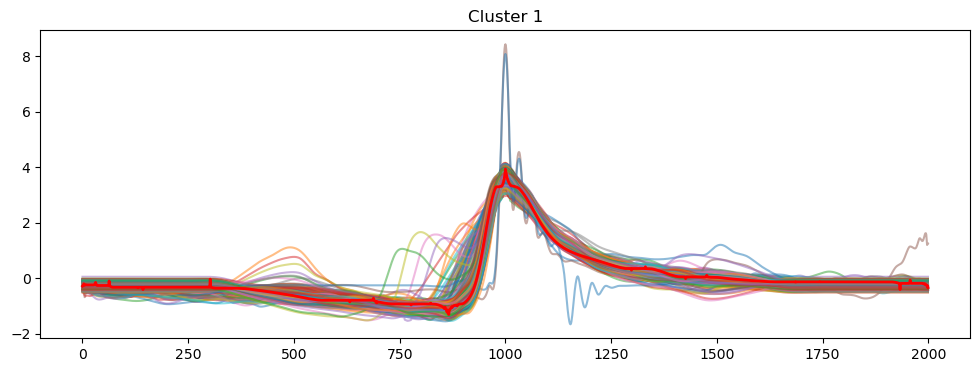

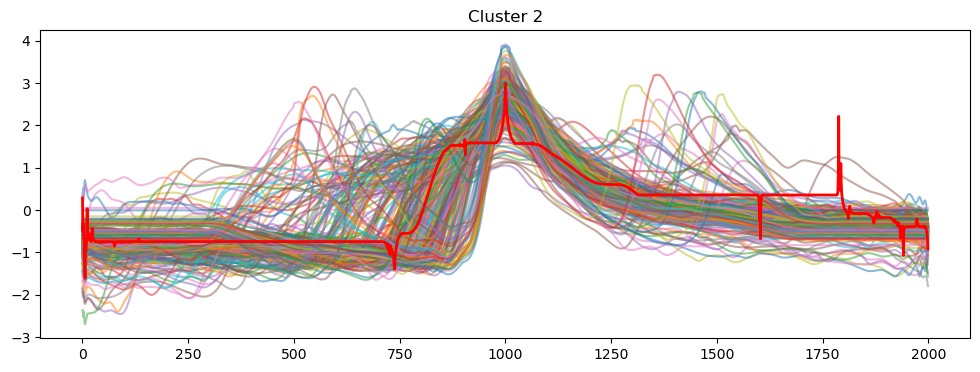

In [307]:
# DTW
for cluster_idx in range(n_clusters):
    plt.figure(figsize=(12, 4))
    plt.title(f"Cluster {cluster_idx + 1}")

    # Plot each time series in the cluster
    for i, series in enumerate(scaled_time_series_data[clusters == cluster_idx]):
        plt.plot(series.ravel(), alpha=0.5)

    # Plot the centroid
    plt.plot(model.cluster_centers_[cluster_idx].ravel(), color='red', linewidth=2)

    plt.show()

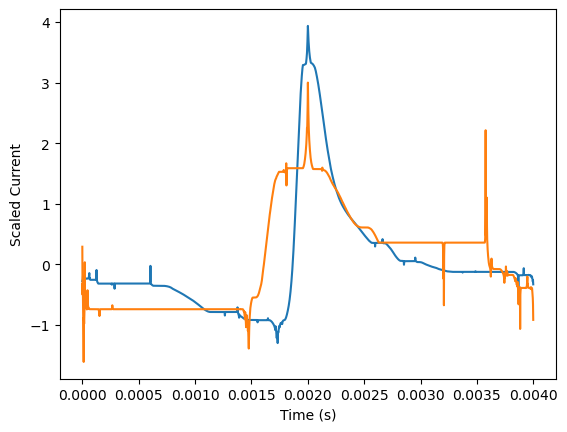

In [340]:
plt.plot(np.linspace(0, 2000*2e-6, 2000), model.cluster_centers_[0].ravel())
plt.plot(np.linspace(0, 2000*2e-6, 2000), model.cluster_centers_[1].ravel())
plt.xlabel("Time (s)")
plt.ylabel("Scaled Current")
plt.show()

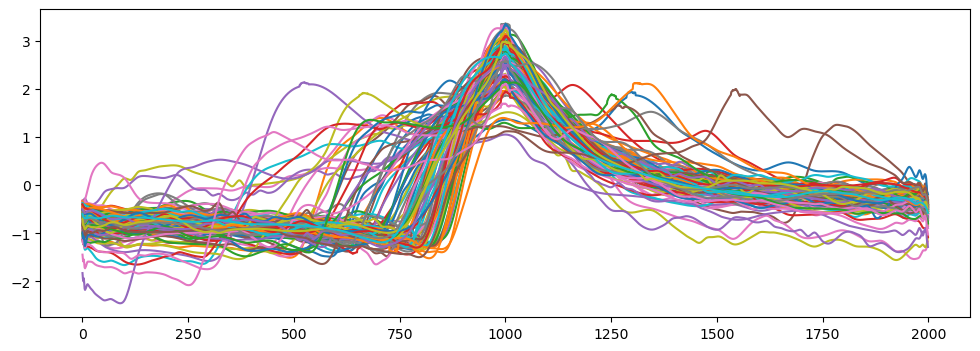

In [319]:
plt.figure(figsize=(12, 4))
for i in range(0,100):
    plt.plot(scaled_time_series_data[clusters == 1][i].ravel())

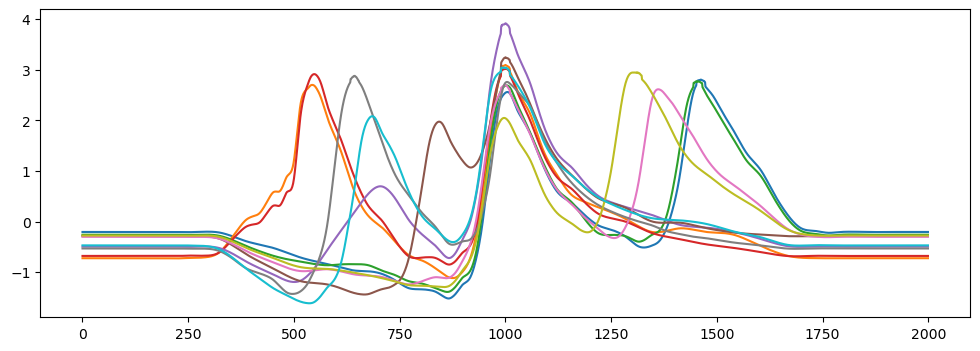

In [334]:
plt.figure(figsize=(12, 4))
for i in range(270,280):
    plt.plot(scaled_time_series_data[clusters == 1][i].ravel())

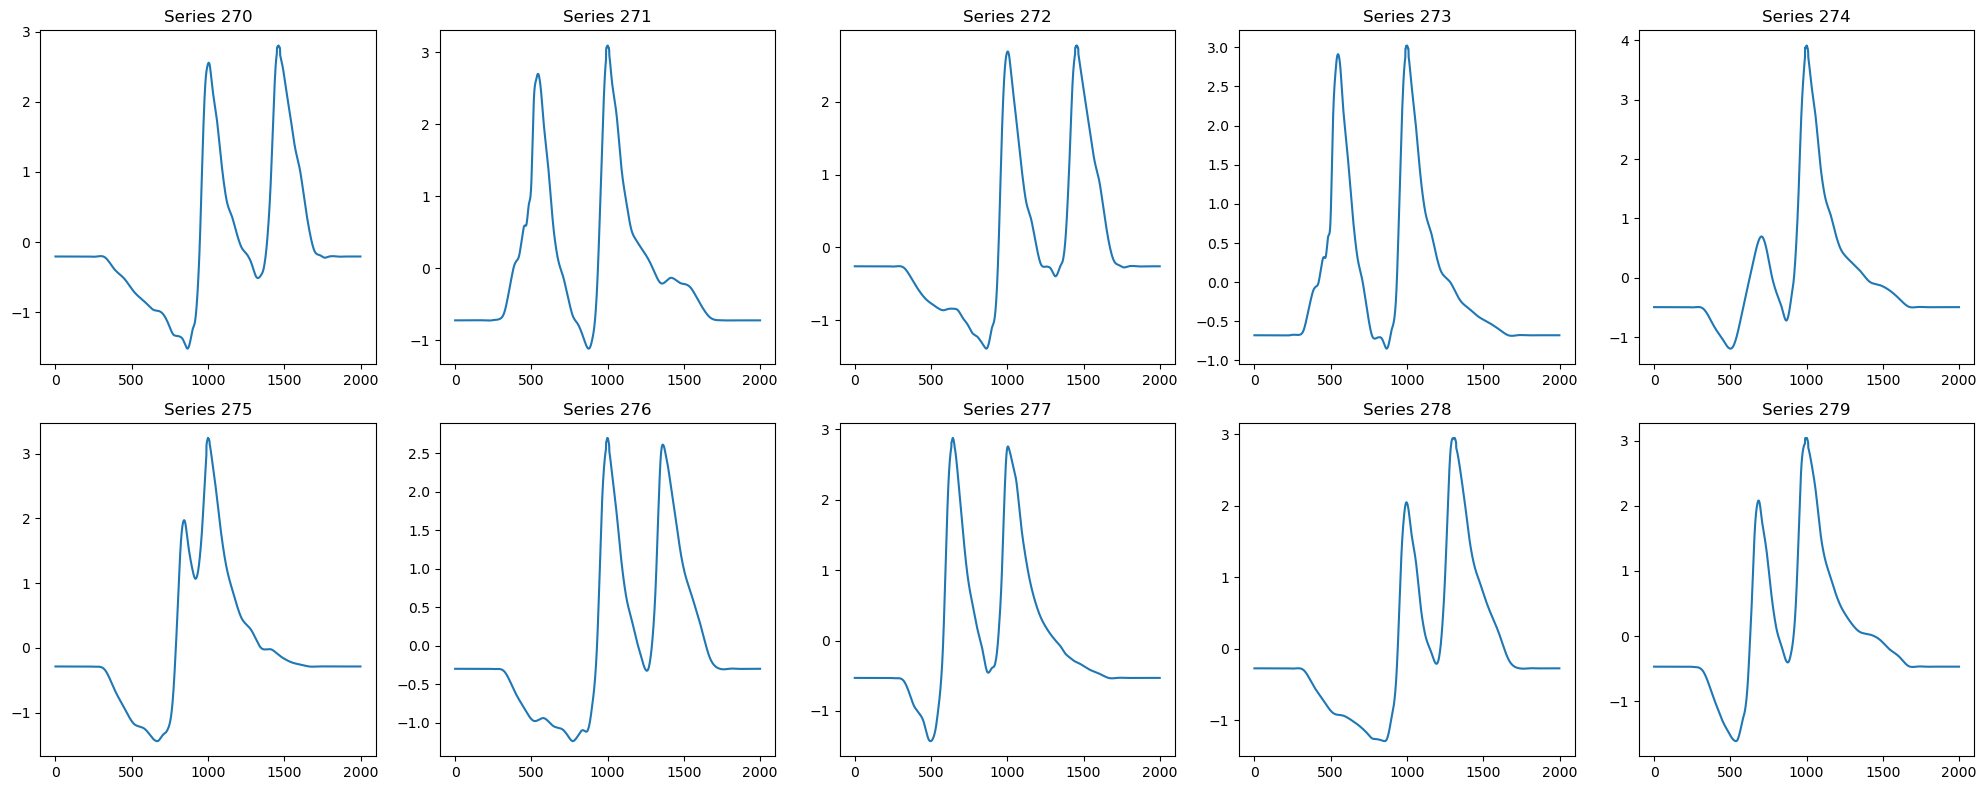

In [335]:
fig, axs = plt.subplots(2, 5, figsize=(20, 8))  # Adjust the size as needed

# Flatten the axs array for easy iteration
axs = axs.flatten()

# Plot data in each subplot
for i, ax in enumerate(axs, start=270):
    if i < 280:
        ax.plot(scaled_time_series_data[clusters == 1][i].ravel())
        ax.set_title(f"Series {i}")
    else:
        ax.axis('off')  # Turn off the axis if no data is to be plotted

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

Elbow method on NRNS data to see how many profiles

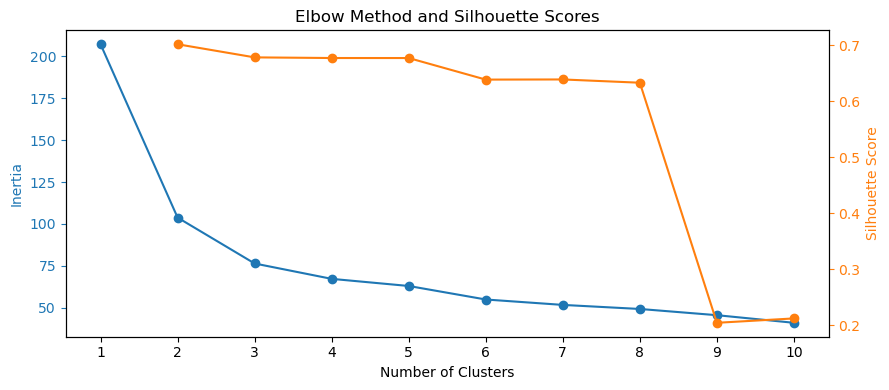

In [153]:
scaler = TimeSeriesScalerMeanVariance()
scaled_time_series_data = scaler.fit_transform(np.array(DWT_rec_padded_NRNS))
flattened_data = np.array([series.flatten() for series in scaled_time_series_data])


num_clusters_range = range(1, 11)  # Adjust the range as needed
models_dic = {}
labels_dic = {}

inertias = []
silhouette_scores = []

for n_clusters in num_clusters_range:
    model = TimeSeriesKMeans(n_clusters=n_clusters, metric="euclidean", max_iter=10, n_jobs=-1, random_state=42)#init='k-means++')
    #‘k-means++’ : selects initial cluster centroids using sampling based on an empirical 
    # probability distribution of the points’ contribution to the overall inertia. 
    # This technique speeds up convergence. The algorithm implemented is “greedy k-means++”. 
    # It differs from the vanilla k-means++ by making several trials at each sampling step and 
    # choosing the best centroid among them.
    
    labels = model.fit_predict(flattened_data)
    
    models_dic[f"n={n_clusters}"] = model
    labels_dic[f"n={n_clusters}"] = model.labels_

    inertias.append(model.inertia_)
    
    if n_clusters == 1:
        silhouette_score_value = None
    else:
        silhouette_score_value = silhouette_score(flattened_data, labels)
        
    silhouette_scores.append(silhouette_score_value)

fig, ax1 = plt.subplots(figsize=(9, 4))

# Plotting Inertia on the left y-axis
ax1.plot(num_clusters_range, inertias, color='#1f77b4', marker='o')
ax1.set_xlabel('Number of Clusters')
ax1.set_ylabel('Inertia', color='#1f77b4')
ax1.tick_params('y', colors='#1f77b4')
ax1.set_xticks(num_clusters_range)

# Create another y-axis for the Silhouette Score
ax2 = ax1.twinx()
ax2.plot(num_clusters_range, silhouette_scores, color='#ff7f0e', marker='o')
ax2.set_ylabel('Silhouette Score', color='#ff7f0e')
ax2.tick_params('y', colors="#ff7f0e")

plt.title('Elbow Method and Silhouette Scores')
plt.tight_layout()
#plt.savefig("MSci_python_images/NRNS_elbow_silhouette.png", dpi = 300)
plt.show()


In [154]:
def plot_timeseriesKMeans(num_clusters, file_name = None):
    model = models_dic[f"n={num_clusters}"]
    labels = labels_dic[f"n={num_clusters}"]
    # model = models_dic[f"n={num_clusters}"]
    # labels = labels_dic[f"n={num_clusters}"]

    # Set up the subplot grid: one row for each cluster and one for the centroids
    fig, axs = plt.subplots(num_clusters + 1, 1, figsize=(10, 3 * (num_clusters + 1)))#, dpi = 300)

    for cluster_idx in range(num_clusters):
        axs[cluster_idx].set_title(f"Cluster {cluster_idx + 1}")

        # Plot each time series in the cluster
        for series in flattened_data[labels == cluster_idx]:
            axs[cluster_idx].plot(series.ravel(), alpha=0.5)

        # Plot the centroid
        axs[cluster_idx].plot(model.cluster_centers_[cluster_idx].ravel(), color='red', linewidth=2, label = f"Cluster centroid {cluster_idx + 1}")
        axs[cluster_idx].set_xlabel("Data Index")
        axs[cluster_idx].set_ylabel("Scaled Current")
        axs[cluster_idx].legend()

    # Plot all centroids in the last subplot
    axs[num_clusters].set_title("All Cluster Centroids")
    for cluster_idx in range(num_clusters):
        axs[num_clusters].plot(np.linspace(0, 2000 * 2e-6, 2000), model.cluster_centers_[cluster_idx].ravel(), label=f'Centroid {cluster_idx + 1}')

    axs[num_clusters].set_xlabel("Time (s)")
    axs[num_clusters].set_ylabel("Scaled Current")
    axs[num_clusters].legend()

    plt.tight_layout()
    if file_name:
        plt.savefig("MSci_python_images/" + file_name + ".png", dpi = 300)
    plt.show()

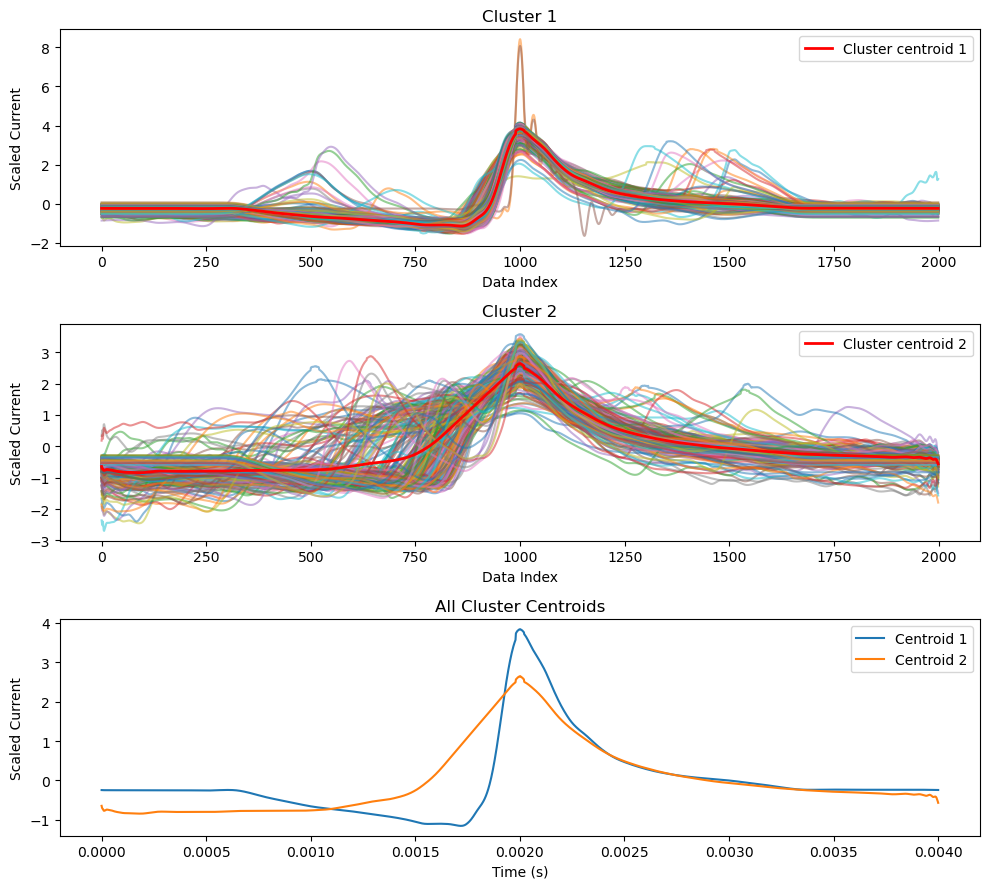

In [157]:
plot_timeseriesKMeans(2, file_name = "NRNS_kmeans_euclidean_2clusters")

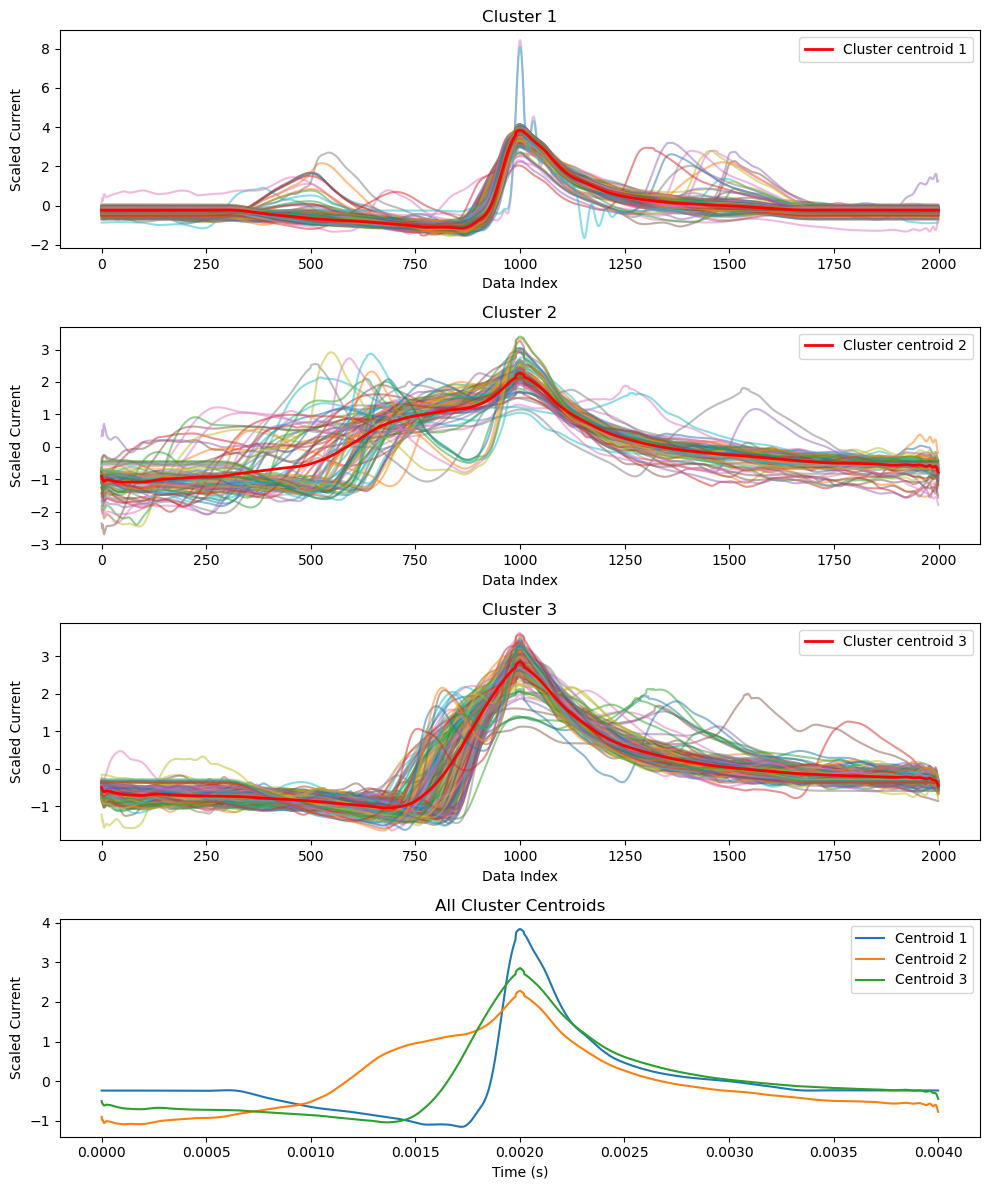

In [158]:
plot_timeseriesKMeans(3, file_name="NRNS_kmeans_euclidean_3clusters")